In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D   

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import resample
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture
import time

In [2]:
spotify_df = pd.read_csv('data\SpotifyFeatures.csv')

In [3]:
print(spotify_df.shape)
print(spotify_df.columns.tolist())

(232725, 18)
['genre', 'artist_name', 'track_name', 'track_id', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


In [4]:
spotify_df.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368  
3       0.0395  171.758            4/4    0.227  
4       0.0456  140.576            4/4    0.390

In [5]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [6]:
spotify_df.describe()

popularity   acousticness   danceability   duration_ms  \
count  232725.000000  232725.000000  232725.000000  2.327250e+05   
mean       41.127502       0.368560       0.554364  2.351223e+05   
std        18.189948       0.354768       0.185608  1.189359e+05   
min         0.000000       0.000000       0.056900  1.538700e+04   
25%        29.000000       0.037600       0.435000  1.828570e+05   
50%        43.000000       0.232000       0.571000  2.204270e+05   
75%        55.000000       0.722000       0.692000  2.657680e+05   
max       100.000000       0.996000       0.989000  5.552917e+06   

              energy  instrumentalness       liveness       loudness  \
count  232725.000000     232725.000000  232725.000000  232725.000000   
mean        0.570958          0.148301       0.215009      -9.569885   
std         0.263456          0.302768       0.198273       5.998204   
min         0.000020          0.000000       0.009670     -52.457000   
25%         0.385000          0.000000       0.097400     -11.771000   
50%         0.605000          0.000044       0.128000      -7.762000   
75%         0.787000          0.035800       0.264000      -5.501000   
max         0.999000          0.999000       1.000000       3.744000   

         speechiness          tempo        valence  
count  232725.000000  232725.000000  232725.000000  
mean        0.120765     117.666585       0.454917  
std         0.185518      30.898907       0.260065  
min         0.022200      30.379000       0.000000  
25%         0.036700      92.959000       0.237000  
50%         0.050100     115.778000       0.444000  
75%         0.105000     139.054000       0.660000  
max         0.967000     242.903000       1.000000

In [7]:
# Check for duplicates
duplicates = spotify_df.duplicated()
num_duplicates = duplicates.sum()

print(f"\nNumber of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    print("\nExample duplicates:")
    display(spotify_df[duplicates].head())


Number of duplicate rows: 0


In [8]:
numeric_feats = ['popularity','acousticness','danceability',
                 'energy','instrumentalness','liveness',
                 'loudness','speechiness','tempo','valence']

df = spotify_df[numeric_feats].copy()

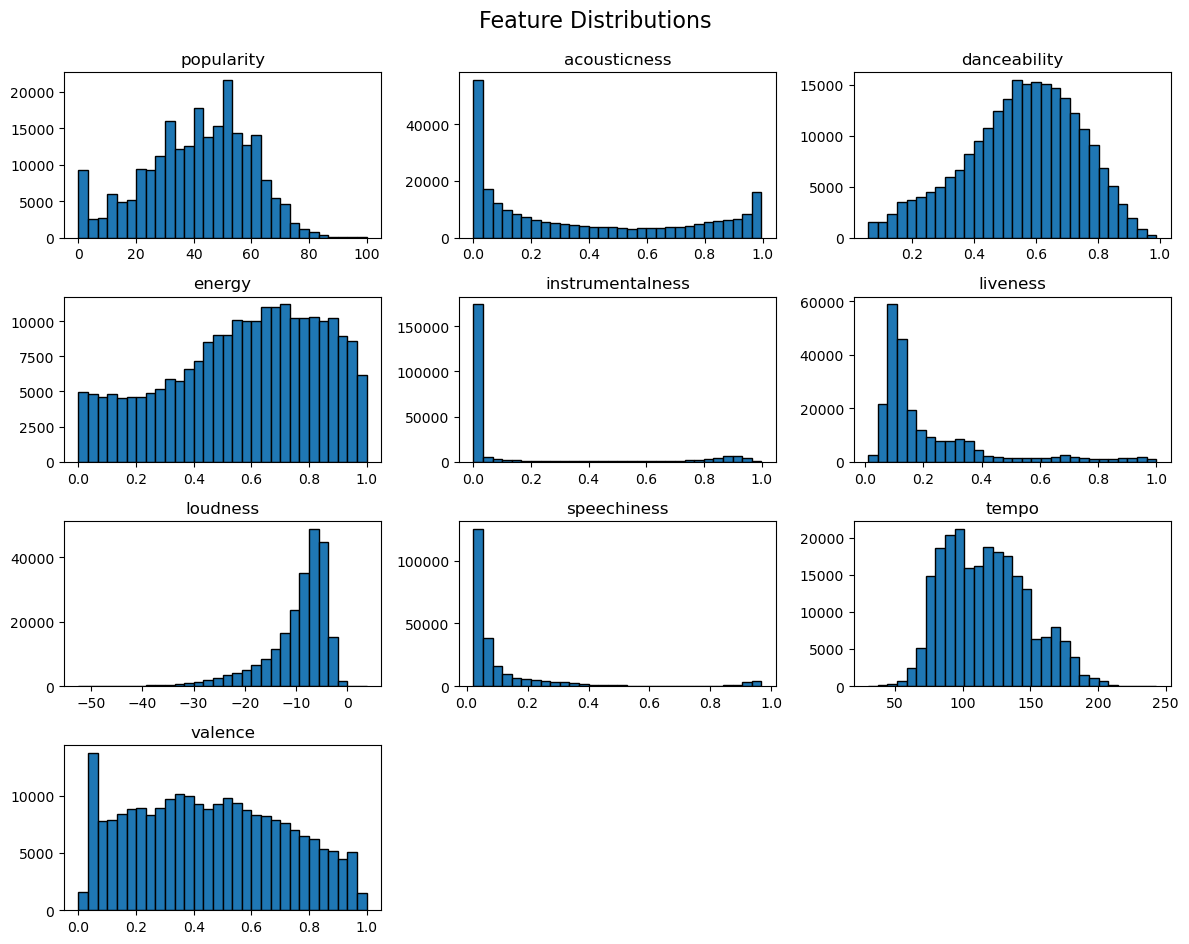

In [9]:
# Histograms
axes = df.hist(bins=30, figsize=(12,10), edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16, y=0.94)

# Remove grid from all subplots
for ax in axes.flatten():
    ax.grid(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


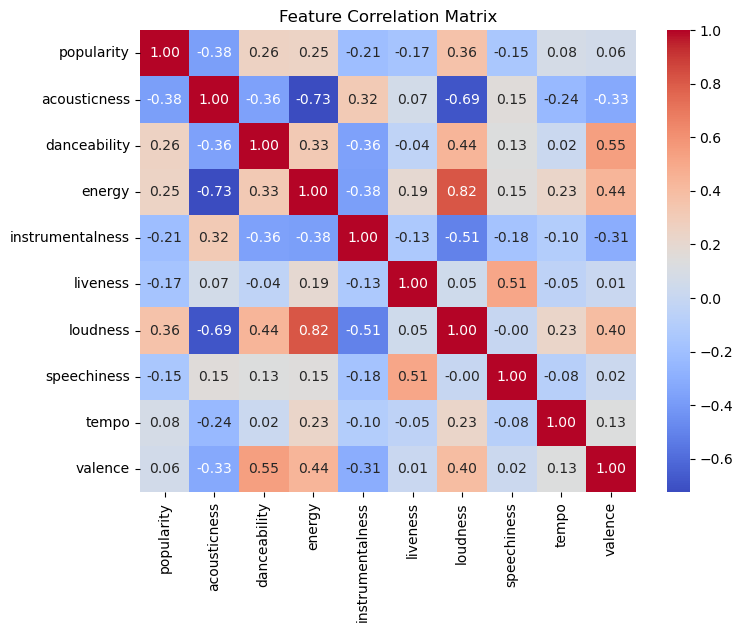

In [10]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_feats].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

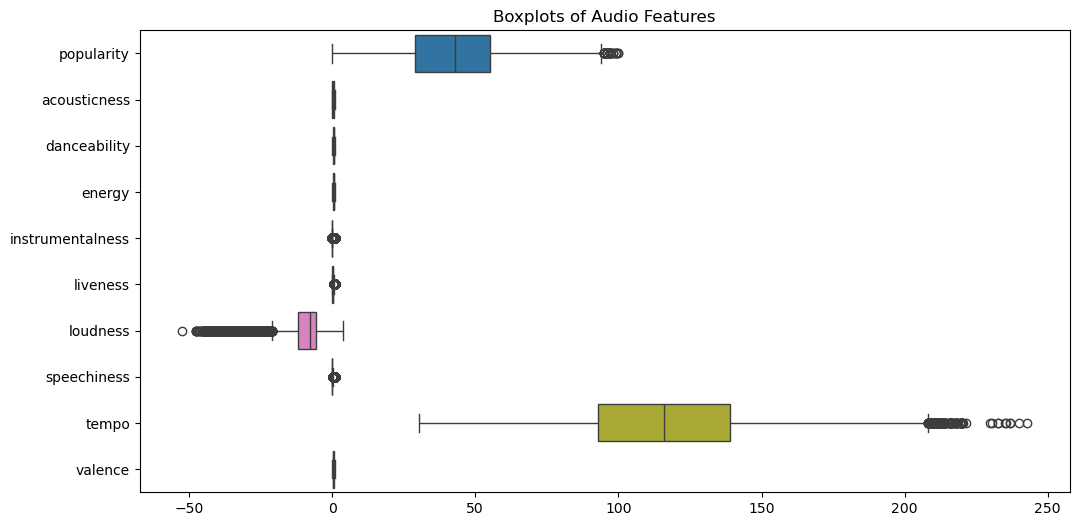

In [11]:
# Boxplots 
plt.figure(figsize=(12,6))
sns.boxplot(data=df, orient='h')
plt.title('Boxplots of Audio Features')
plt.show()

In [12]:
# Find the Outlier using IQR 
outlier_counts = {}

for col in numeric_feats:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_counts[col] = outliers.shape[0]

for col, count in sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {count}")

instrumentalness: 51545
speechiness: 32979
liveness: 21241
loudness: 14171
tempo: 168
popularity: 38
acousticness: 0
danceability: 0
energy: 0
valence: 0


In [13]:
# remove outliers
df_clean = df.copy()

for col in numeric_feats:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # Keep only rows where the value is within bounds
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")

Original shape: (232725, 10)
Cleaned shape: (137411, 10)


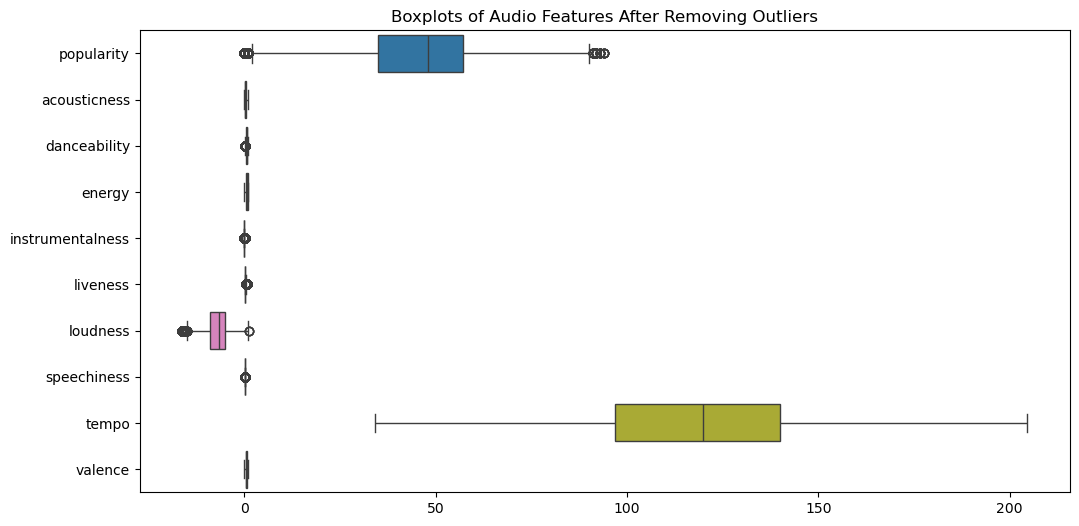

In [14]:
# Boxplots 
plt.figure(figsize=(12,6))
sns.boxplot(data=df_clean, orient='h')
plt.title('Boxplots of Audio Features After Removing Outliers')
plt.show()

In [15]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
X_scaled_clean = scaler.fit_transform(df_clean)

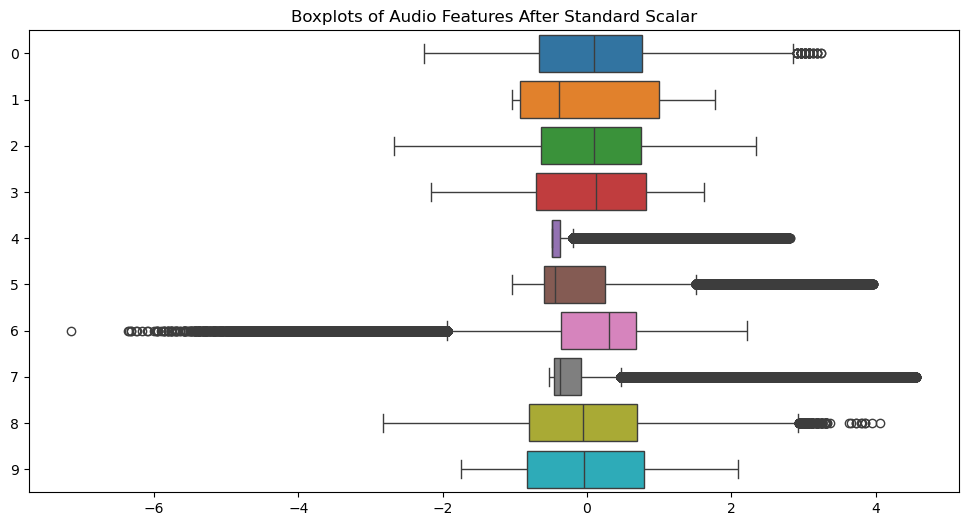

In [16]:
# Boxplots 
plt.figure(figsize=(12,6))
sns.boxplot(data=X_scaled, orient='h')
plt.title('Boxplots of Audio Features After Standard Scalar')
plt.show()

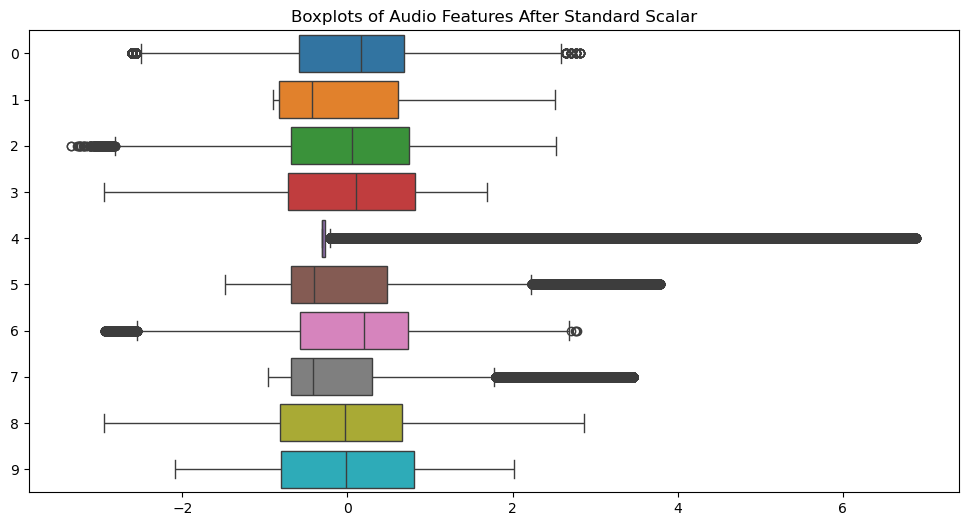

In [17]:
# Boxplots 
plt.figure(figsize=(12,6))
sns.boxplot(data=X_scaled_clean, orient='h')
plt.title('Boxplots of Audio Features After Standard Scalar')
plt.show()

# Find Optimal K

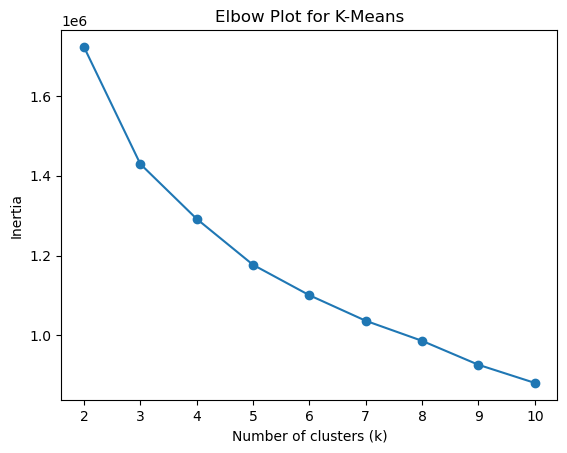

In [46]:
wcss = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means')
plt.show()

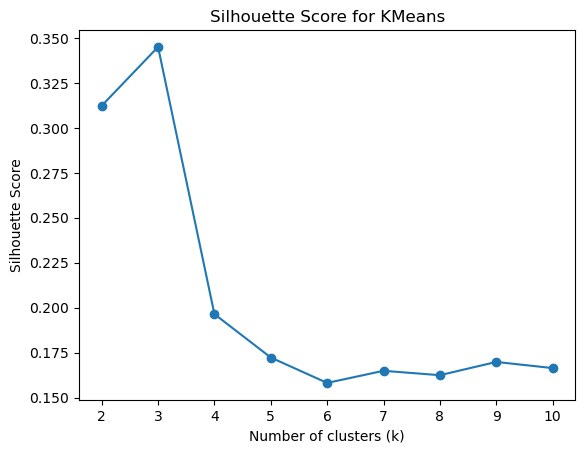

In [23]:
# Resample to smaller number of data
# X_sample = resample(X_scaled, n_samples=50000, random_state=42)
sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans')
plt.show()

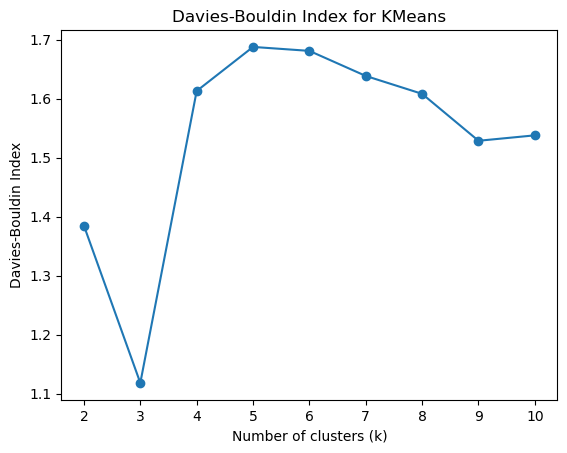

In [24]:
dbi_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    dbi = davies_bouldin_score(X_scaled, labels)
    dbi_scores.append(dbi)

plt.plot(range(2, 11), dbi_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for KMeans')
plt.show()

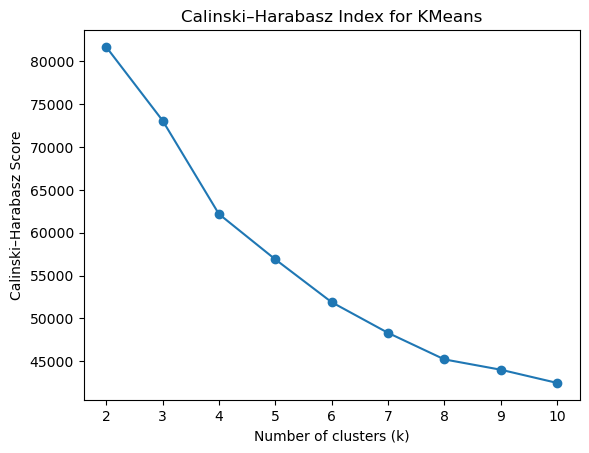

In [25]:
ch_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, labels)
    ch_scores.append(score)

plt.plot(range(2, 11), ch_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski–Harabasz Score')
plt.title('Calinski–Harabasz Index for KMeans')
plt.show()


### Gap Statistics

In [28]:
def compute_gap_statistic(X, k, n_refs=5):
    # Take X (datapoints) as input
    # k: num of clusters to evaluate
    # n_refs: also as b is the reference datasates to generate
    # runs kmeans and calculate the dispersion
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
    # pairwise_distances gives the distance between each point to own cluster
    orig_disp = np.mean(np.min(pairwise_distances(X, kmeans.cluster_centers_), axis=1))

    # Create reference dataset
    ref_disps = []
    for _ in range(n_refs):
        # Create reference dataset with uniformly distributed random points
        random_ref = np.random.uniform(X.min(axis=0), X.max(axis=0), size=X.shape)
        # compute kmeans and cal dispersion on the reference data
        kmeans_ref = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(random_ref)
        ref_disp = np.mean(np.min(pairwise_distances(random_ref, kmeans_ref.cluster_centers_), axis=1))
        ref_disps.append(ref_disp)

    # takes the log of the average dispersion from the random data
    # subtracts the log of the dispersion on real data
    log_ref = np.log(ref_disps)
    gap = np.mean(log_ref) - np.log(orig_disp)
    err = np.std(log_ref) * np.sqrt(1 + 1/n_refs)
    return gap, err

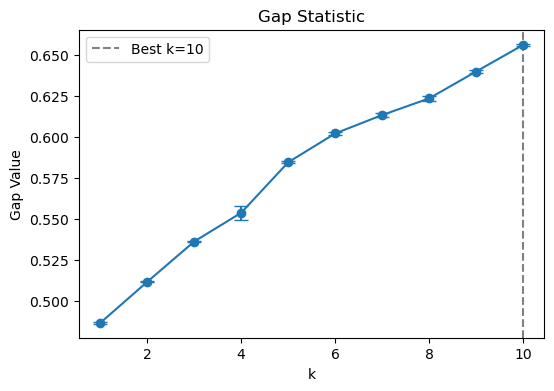

In [29]:
gap_scores = []
gap_errors = []
K = range(1, 11)

for k in K:
    gap, err = compute_gap_statistic(X_scaled, k=k, n_refs=20)
    gap_scores.append(gap)
    gap_errors.append(err)
    
best_gap_k = None
for i in range(len(K) - 1):
    if gap_scores[i] >= gap_scores[i + 1] - gap_errors[i + 1]:
        best_gap_k = K[i]
        break

if best_gap_k is None:
    best_gap_k = K[np.argmax(gap_scores)]
    
plt.figure(figsize=(6, 4))
plt.errorbar(K, gap_scores, yerr=gap_errors, marker='o', capsize=5)
plt.axvline(x=best_gap_k, linestyle='--', color='gray', label=f"Best k={best_gap_k}")
plt.title("Gap Statistic")
plt.xlabel("k")
plt.ylabel("Gap Value")
plt.legend()
plt.show()

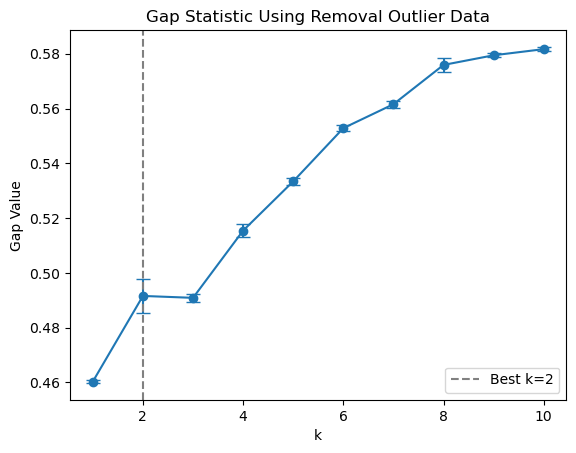

In [19]:
gap_scores = []
gap_errors = []
K = range(1, 11)

for k in K:
    gap, err = compute_gap_statistic(X_scaled_clean, k=k, n_refs=20)
    gap_scores.append(gap)
    gap_errors.append(err)

best_gap_k = None
for i in range(len(K) - 1):
    if gap_scores[i] >= gap_scores[i + 1] - gap_errors[i + 1]:
        best_gap_k = K[i]
        break

if best_gap_k is None:
    best_gap_k = K[np.argmax(gap_scores)]
    
plt.errorbar(K, gap_scores, yerr=gap_errors, marker='o', capsize=5)
plt.axvline(x=best_gap_k, linestyle='--', color='gray', label=f"Best k={best_gap_k}")
plt.title("Gap Statistic Using Removal Outlier Data")
plt.xlabel("k")
plt.ylabel("Gap Value")
plt.legend()
plt.show()

In [30]:
def gap_statistic(X, max_k=10, B=10, random_state=42, verbose=True):
    rng = np.random.default_rng(random_state)
    n, d = X.shape
    mins, maxs = X.min(axis=0), X.max(axis=0)

    logW = np.zeros(max_k)
    logW_ref = np.zeros((max_k, B))

    # Helper to compute inertia (within-cluster sum of squares)
    def compute_wk(data, k):
        return KMeans(n_clusters=k, random_state=random_state, n_init='auto').fit(data).inertia_

    for k in range(1, max_k + 1):
        logW[k - 1] = np.log(compute_wk(X, k))
        for b in range(B):
            Xb = rng.uniform(mins, maxs, size=(n, d))
            logW_ref[k - 1, b] = np.log(compute_wk(Xb, k))

    gaps = logW_ref.mean(axis=1) - logW
    sk = logW_ref.std(axis=1, ddof=1) * np.sqrt(1 + 1 / B)

    # Tibshirani rule: smallest k s.t. Gap(k) >= Gap(k+1) - s_{k+1}
    best_k = None
    for i in range(max_k - 1):
        if gaps[i] >= gaps[i + 1] - sk[i + 1]:
            best_k = i + 1
            break
    if best_k is None:
        best_k = max_k

    if verbose:
        print(f"{'k':>2}  {'Gap':>8}  {'s_k':>8}")
        for i in range(max_k):
            print(f"{i+1:>2}  {gaps[i]:8.3f}  {sk[i]:8.3f}")
        print(f"\nOptimal k according to Gap Statistic: {best_k}")

    return best_k, gaps, sk


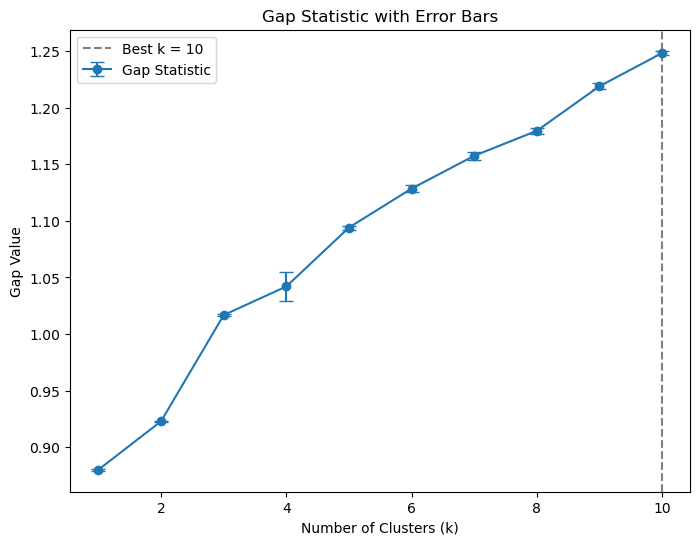

In [33]:
best_k, gaps, sk = gap_statistic(X_scaled, max_k=10, B=20, verbose=False)

K = range(1, len(gaps) + 1)

plt.figure(figsize=(8, 6))
plt.errorbar(K, gaps, yerr=sk, marker='o', capsize=5, label="Gap Statistic")
plt.axvline(x=best_k, linestyle='--', color='gray', label=f"Best k = {best_k}")
plt.title("Gap Statistic with Error Bars")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Gap Value")
plt.legend()
plt.show()

In [21]:
def plot_silhouette(k, X, title="Silhouette Plot"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)

    sil_vals = silhouette_samples(X, labels)
    sil_avg = silhouette_score(X, labels)
    
    print(f"Average Silhouette Score for k={k}: {sil_avg:.4f}")

    fig, ax = plt.subplots(figsize=(8, 6))

    y_lower = 10
    for i in range(k):
        ith_vals = sil_vals[labels == i]
        ith_vals.sort()
        size_i = ith_vals.shape[0]
        y_upper = y_lower + size_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10

    ax.axvline(x=sil_avg, color="green", linestyle="--")
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (k + 1) * 10])
    ax.set_title(f"{title}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster labels")
    plt.tight_layout()
    plt.show()


Average Silhouette Score for k=3: 0.3450


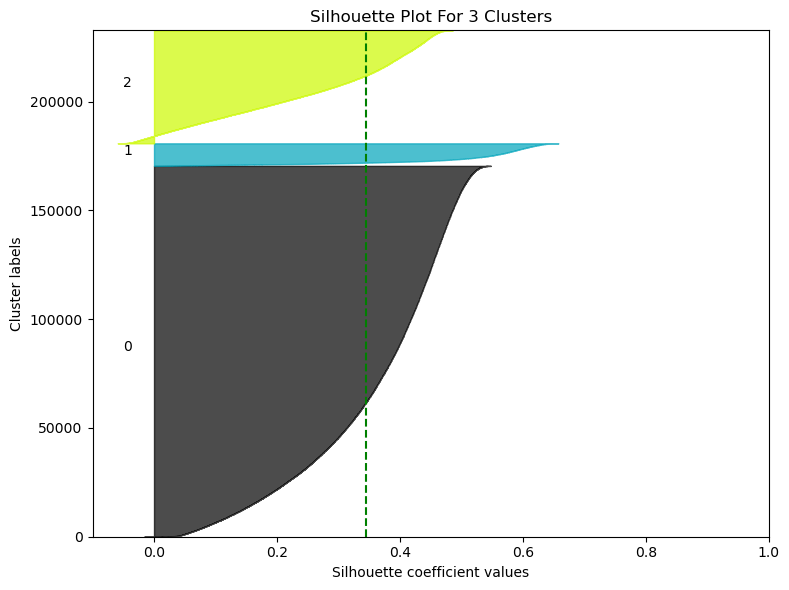

In [24]:
plot_silhouette(k=3, X=X_scaled, title="Silhouette Plot For 3 Clusters")

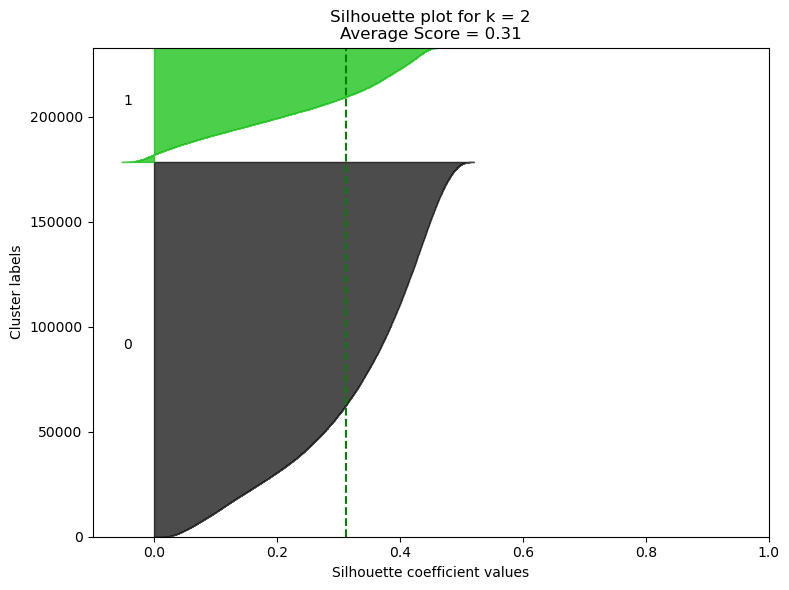

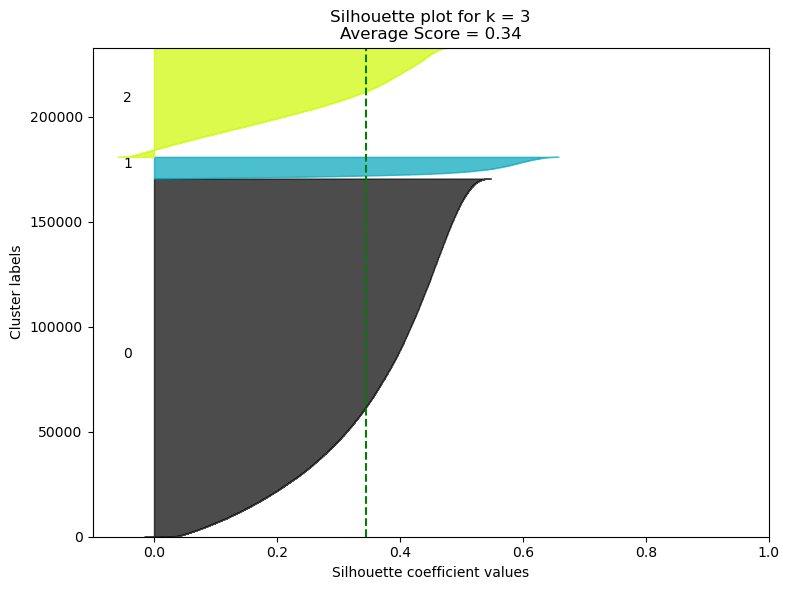

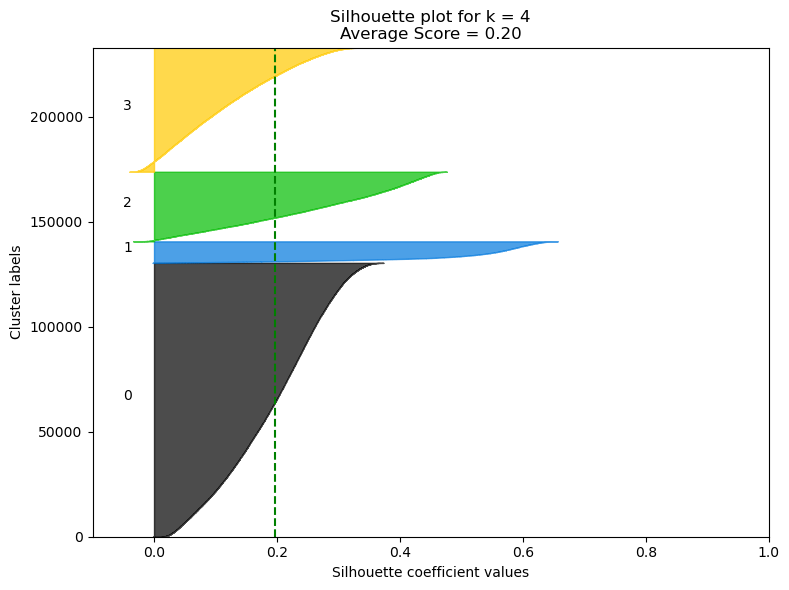

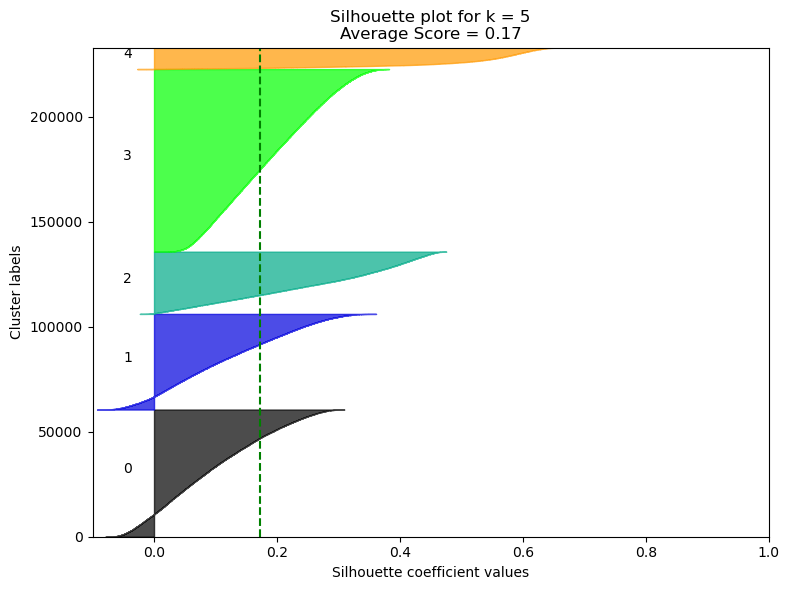

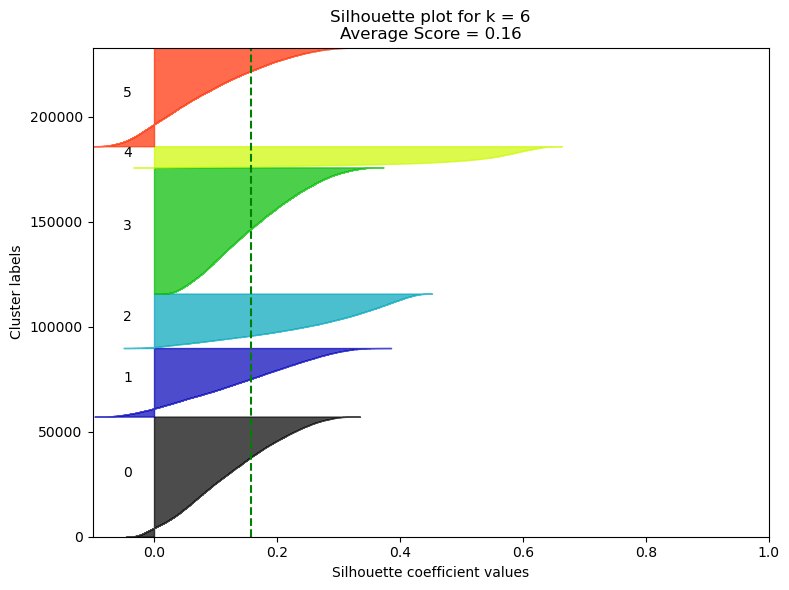

In [13]:
# Set k values to test
ks = range(2, 7)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    sil_avg = silhouette_score(X_scaled, labels)
    sil_vals = silhouette_samples(X_scaled, labels)

    # Create a new figure for each k
    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 10

    for i in range(k):
        ith_vals = sil_vals[labels == i]
        ith_vals.sort()
        size_i = ith_vals.shape[0]
        y_upper = y_lower + size_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10

    ax.axvline(x=sil_avg, color="green", linestyle="--")
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X_scaled) + (k + 1) * 10])
    ax.set_title(f"Silhouette plot for k = {k}\nAverage Score = {sil_avg:.2f}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster labels")
    plt.tight_layout()
    plt.show()

In [40]:
k_values = list(range(2, 11))

metrics_df = pd.DataFrame({
    "k": k_values,
    "WCSS": wcss,                              
    "Silhouette": sil_scores,                  
    "Davies-Bouldin": dbi_scores,              
    "Calinski-Harabasz": ch_scores,            
    "Gap": gaps[1:len(k_values)+1],            
    "Gap s_k": sk[1:len(k_values)+1]           
})


metrics_df = metrics_df.round(3)
metrics_df

k         WCSS  Silhouette  Davies-Bouldin  Calinski-Harabasz    Gap  \
0   2  1722617.419       0.312           1.385          81685.187  0.923   
1   3  1429381.388       0.345           1.118          73092.391  1.017   
2   4  1291833.324       0.196           1.613          62176.352  1.042   
3   5  1176721.881       0.172           1.688          56885.077  1.094   
4   6  1100504.549       0.158           1.681          51883.196  1.129   
5   7  1036483.406       0.165           1.639          48302.126  1.158   
6   8   986227.753       0.163           1.608          45205.481  1.180   
7   9   926233.168       0.170           1.529          44000.866  1.219   
8  10   880848.107       0.166           1.538          42459.133  1.248   

   Gap s_k  
0    0.000  
1    0.001  
2    0.013  
3    0.002  
4    0.003  
5    0.004  
6    0.003  
7    0.003  
8    0.002

## PCA Variance

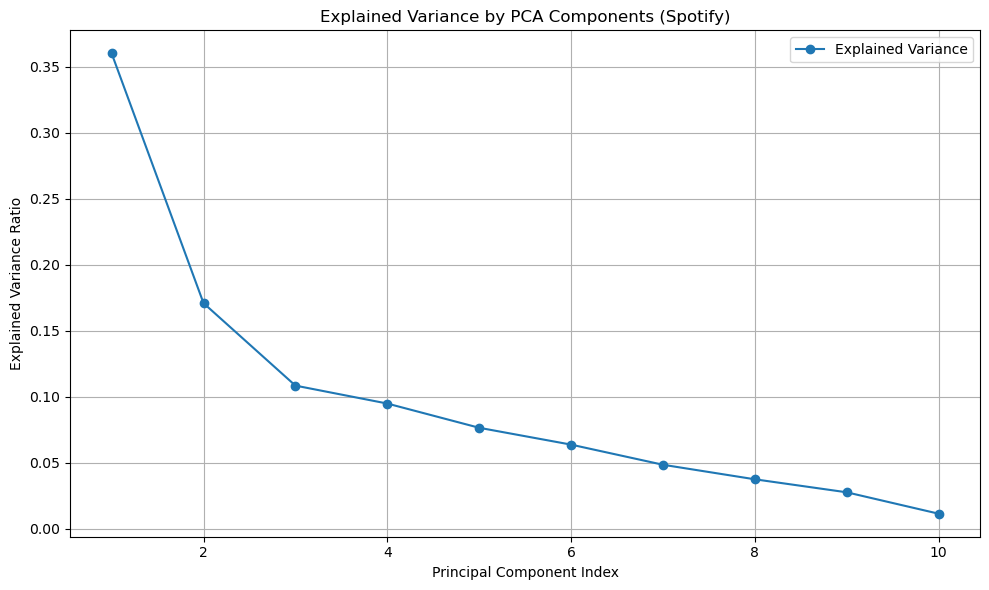

In [78]:
# plot explained variance for each PCA
n_feats = X_scaled.shape[1]
pca = PCA(n_components=n_feats, random_state=42)
pca.fit(X_scaled)
explained_var = pca.explained_variance_ratio_

# individual explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_feats + 1), explained_var, marker='o', label='Explained Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title("Explained Variance by PCA Components (Spotify)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

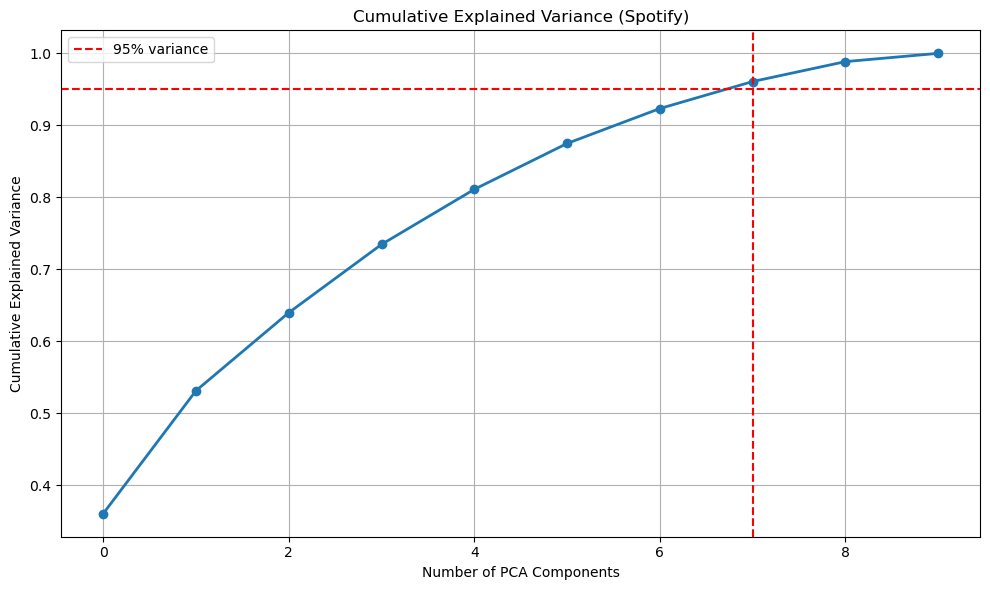

In [79]:
# plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_var), marker='o', linewidth=2)
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance (Spotify)')
plt.grid(True)

# plot red line at 95% threshold
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axvline(x=np.argmax(np.cumsum(explained_var) >= 0.95), color='r', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# KMeans Clustering

In [18]:
def run_kmeans(data, k, original_df=None, interpret=False):
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = model.fit_predict(data)

    # Cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    print(f"Cluster Sizes (k={k}):")
    for cluster_id, size in cluster_sizes.items():
        print(f"  Cluster {cluster_id}: {size}")

    # Validation metrics
    sil_score_val = silhouette_score(data, labels)
    dbi_score_val = davies_bouldin_score(data, labels)
    chi_score_val = calinski_harabasz_score(data, labels)

    n_samples, n_features = data.shape
    print(f"\nK-Means Results on data with shape: {n_samples} samples × {n_features} features")
    print(f"Silhouette Score (Range -1 to 1)           : {sil_score_val:.3f}")
    print(f"Davies-Bouldin Index (Lower is better)     : {dbi_score_val:.3f}")
    print(f"Calinski-Harabasz Index (Higher is better) : {chi_score_val:.1f}")
    
    cluster_means = None
    df_temp = None
    if original_df is not None:
        df_temp = original_df.copy()
        df_temp['cluster'] = labels
        cluster_means = df_temp.groupby('cluster').mean()

        if interpret:
            print(f"\nCluster Feature Means (k={k}):\n")
            print(cluster_means.round(3))
            
    return {
        "labels": labels,
        "model": model,
        "cluster_sizes": cluster_sizes,
        "silhouette": sil_score_val,
        "dbi": dbi_score_val,
        "chi": chi_score_val,
        "cluster_means": cluster_means
    }

In [20]:
def plot_results(X_2d, cluster_labels, title="Clustering (PCA 2D)"):
    plt.figure(figsize=(8, 6))

    if -1 in cluster_labels:
        # Plot noise points
        noise_mask = (cluster_labels == -1)
        plt.scatter(X_2d[noise_mask, 0], X_2d[noise_mask, 1],
                    c='lightgrey', s=8, label='Noise', alpha=0.6)
        
        # Plot clusters
        sc = plt.scatter(X_2d[~noise_mask, 0], X_2d[~noise_mask, 1],
                         c=cluster_labels[~noise_mask], cmap='tab10', s=8, alpha=0.8)
        
        plt.legend(loc='best', markerscale=2)
    else:
        sc = plt.scatter(X_2d[:, 0], X_2d[:, 1],
                         c=cluster_labels, cmap='tab10', s=8, alpha=0.8)

    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(sc, label="Cluster")
    plt.tight_layout()
    plt.show()


## Using original data
### k = 3

In [36]:
# Kmeans on full data
print("Kmeans on Full Data")
kmeans_full = run_kmeans(X_scaled, 3, original_df=df, interpret=True)

Kmeans on Full Data
Cluster Sizes (k=3):
  Cluster 0: 170450
  Cluster 1: 10350
  Cluster 2: 51925

K-Means Results on data with shape: 232725 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.345
Davies-Bouldin Index (Lower is better)     : 1.118
Calinski-Harabasz Index (Higher is better) : 73092.4

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            45.991         0.203         0.611   0.676             0.065   
1            20.703         0.789         0.562   0.659             0.001   
2            29.235         0.827         0.365   0.210             0.451   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.199    -6.958        0.097  122.324    0.528  
1           0.726   -12.008        0.866   98.440    0.417  
2           0.166  

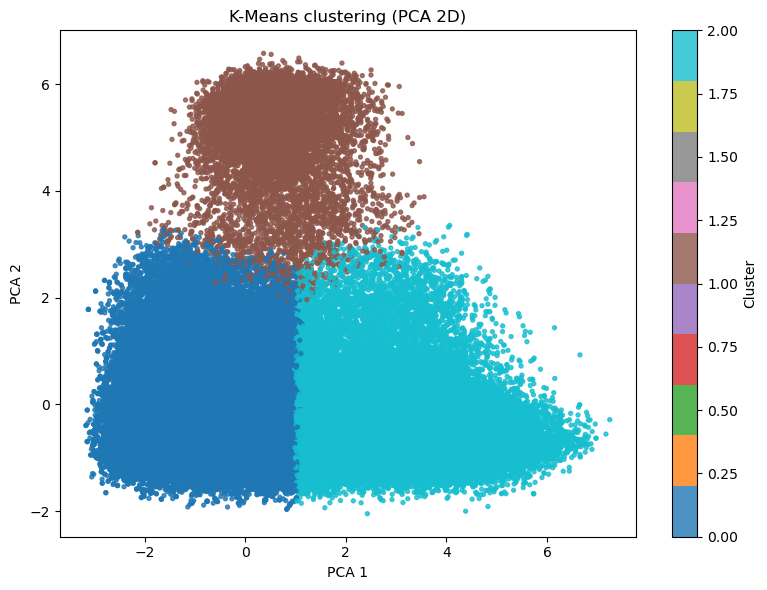

In [37]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled) 

plot_results(X_2d, kmeans_full['labels'], title="K-Means clustering (PCA 2D)")

In [40]:
# Kmeans on claned data
print("Kmeans on Cleaned Data")
kmeans_clean = run_kmeans(X_scaled_clean, 3, original_df=df_clean, interpret=True)

Kmeans on Cleaned Data
Cluster Sizes (k=3):
  Cluster 0: 91201
  Cluster 1: 40148
  Cluster 2: 6062

K-Means Results on data with shape: 137411 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.210
Davies-Bouldin Index (Lower is better)     : 1.606
Calinski-Harabasz Index (Higher is better) : 23705.3

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            47.504         0.123         0.615   0.743             0.001   
1            40.318         0.586         0.547   0.389             0.002   
2            43.336         0.262         0.567   0.633             0.055   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.177    -5.794        0.075  123.663    0.558  
1           0.147   -10.452        0.050  113.971    0.403  
2           0.162 

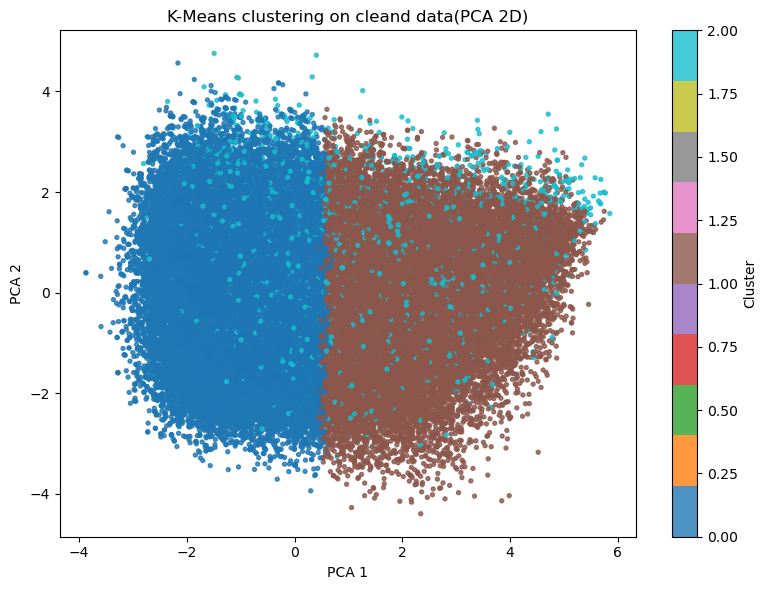

In [41]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d_clean = pca_2d.fit_transform(X_scaled_clean) 

plot_results(X_2d_clean, kmeans_clean['labels'], title="K-Means clustering on cleand data(PCA 2D)")

## PCA 2D

In [21]:
# Kmeans on PCA 2D full data 
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

print("Kmeans on PCA 2D Data")
kmeans_2d = run_kmeans(X_2d, 3, original_df=df, interpret=True)

Kmeans on PCA 2D Data
Cluster Sizes (k=3):
  Cluster 0: 170296
  Cluster 1: 50900
  Cluster 2: 11529

K-Means Results on data with shape: 232725 samples × 2 features
Silhouette Score (Range -1 to 1)           : 0.600
Davies-Bouldin Index (Lower is better)     : 0.554
Calinski-Harabasz Index (Higher is better) : 292538.4

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            46.041         0.205         0.612   0.674             0.065   
1            29.262         0.826         0.363   0.207             0.459   
2            20.930         0.761         0.556   0.651             0.005   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.196    -6.968        0.096  122.432    0.528  
1           0.161   -17.771        0.051  105.897    0.217  
2           0.738

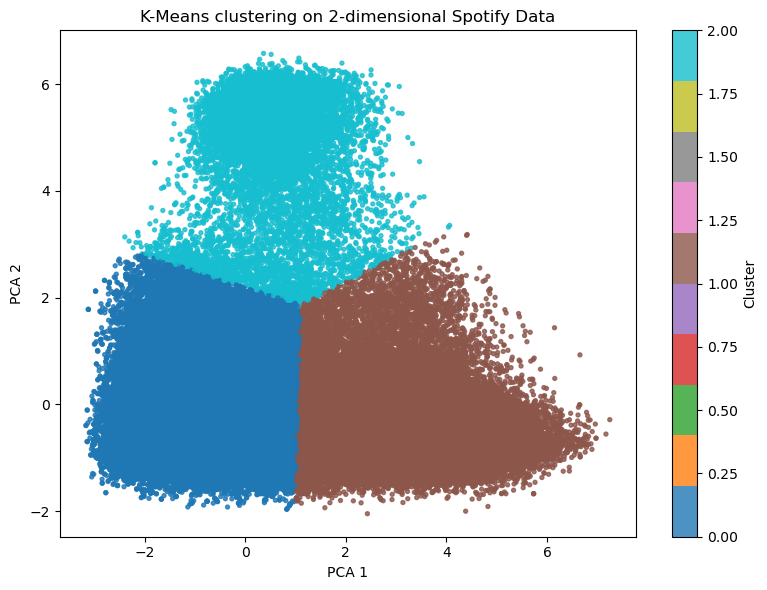

In [22]:
# PCA 2D for visualisation
plot_results(X_2d, kmeans_2d['labels'], title="K-Means clustering on 2-dimensional Spotify Data")

In [43]:
# Kmeans on PCA 2D clean data 
pca_2d = PCA(n_components=2)
X_2d_clean = pca_2d.fit_transform(X_scaled_clean)

print("Kmeans on PCA 2D Cleaned Data")
kmeans_2d_clean = run_kmeans(X_2d_clean, 3, original_df=df_clean, interpret=True)

Kmeans on PCA 2D Cleaned Data
Cluster Sizes (k=3):
  Cluster 0: 52773
  Cluster 1: 35824
  Cluster 2: 48814

K-Means Results on data with shape: 137411 samples × 2 features
Silhouette Score (Range -1 to 1)           : 0.370
Davies-Bouldin Index (Lower is better)     : 0.921
Calinski-Harabasz Index (Higher is better) : 114864.6

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            46.473         0.194         0.720   0.678             0.002   
1            40.503         0.618         0.527   0.370             0.006   
2            47.329         0.081         0.504   0.783             0.004   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.153    -6.721        0.083  114.194    0.669  
1           0.146   -10.693        0.047  113.017    0.367  
2         

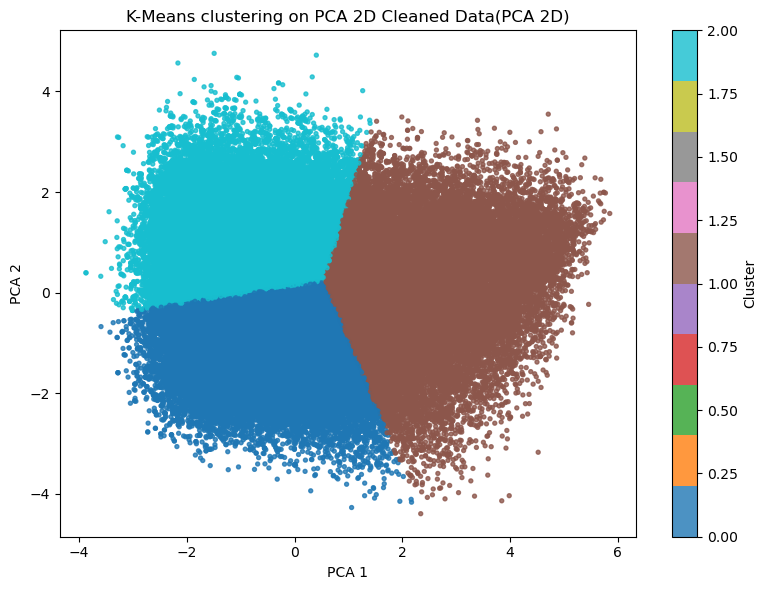

In [44]:
plot_results(X_2d_clean, kmeans_2d_clean['labels'], title="K-Means clustering on PCA 2D Cleaned Data(PCA 2D)")

## PCA 3D

In [45]:
# Kmeans on PCA 3D full data 
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_scaled)

print("Kmeans on PCA 3D Data")
kmeans_3d = run_kmeans(X_3d, 3, original_df=df, interpret=True)

Kmeans on PCA 3D Data
Cluster Sizes (k=3):
  Cluster 0: 169804
  Cluster 1: 51205
  Cluster 2: 11716

K-Means Results on data with shape: 232725 samples × 3 features
Silhouette Score (Range -1 to 1)           : 0.498
Davies-Bouldin Index (Lower is better)     : 0.717
Calinski-Harabasz Index (Higher is better) : 170571.2

Cluster Feature Means (k=3):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            46.064         0.204         0.612   0.675             0.065   
1            29.341         0.825         0.364   0.208             0.457   
2            21.091         0.754         0.553   0.653             0.005   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.195    -6.961        0.096  122.438    0.529  
1           0.161   -17.730        0.051  105.949    0.218  
2           0.741

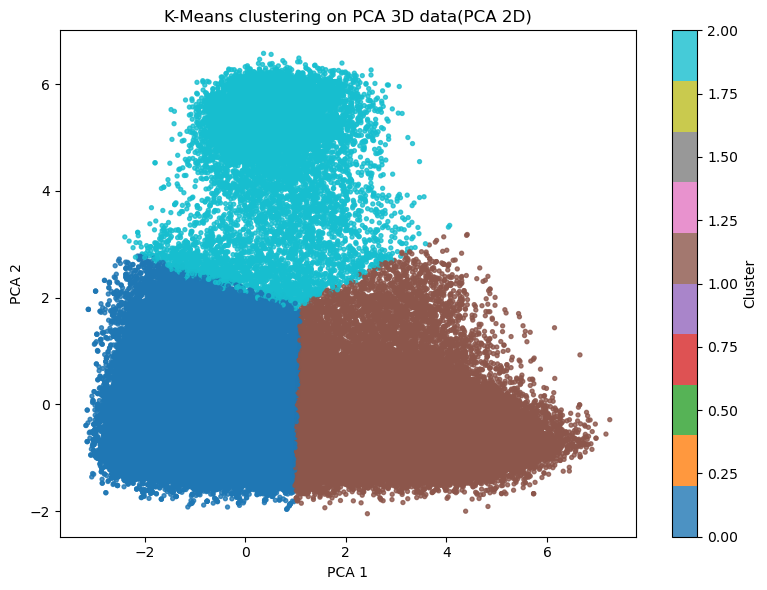

In [46]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d_from_3d = pca_2d.fit_transform(X_3d) 

plot_results(X_2d_from_3d, kmeans_3d['labels'], title="K-Means clustering on PCA 3D data(PCA 2D)")

### PCA Componenet VS Validation Metrics on FUll Data

In [102]:
# Store results
sil_results = {}
dbi_results = {}
chi_results = {}

pca_dimensions = [2, 3, 4, 5, 6, 7]

for dim in pca_dimensions:
    X_pca = PCA(n_components=dim, random_state=42).fit_transform(X_scaled)
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)
    
    key = f"{dim}D"
    sil_results[key] = silhouette_score(X_pca, labels)
    dbi_results[key] = davies_bouldin_score(X_pca, labels)
    chi_results[key] = calinski_harabasz_score(X_pca, labels)

# Full data (no PCA)
full_key = f"{X_scaled.shape[1]}D"
kmeans_full = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_full = kmeans_full.fit_predict(X_scaled)

sil_results[full_key] = silhouette_score(X_scaled, labels_full)
dbi_results[full_key] = davies_bouldin_score(X_scaled, labels_full)
chi_results[full_key] = calinski_harabasz_score(X_scaled, labels_full)

In [104]:
k_means_spo_results_df = pd.DataFrame({
    "Silhouette": sil_results,
    "DBI": dbi_results,
    "CHI": chi_results
}).loc[[f"{d}D" for d in pca_dimensions] + [full_key]]

# Save to CSV
results_path = "k_means_spo_results.csv"
k_means_spo_results_df.to_csv(results_path, index=False)

print(f"Results saved to {results_path}")

Results saved to k_means_spo_results.csv


In [105]:
k_means_spo_results_df 

Silhouette       DBI            CHI
2D     0.600114  0.553938  292538.394417
3D     0.497797  0.716794  170571.224310
4D     0.437898  0.841203  125306.657534
5D     0.401789  0.931470  103286.025806
6D     0.384177  1.009875   90444.060277
7D     0.368966  1.040975   83045.554297
10D    0.344963  1.118007   73092.391273

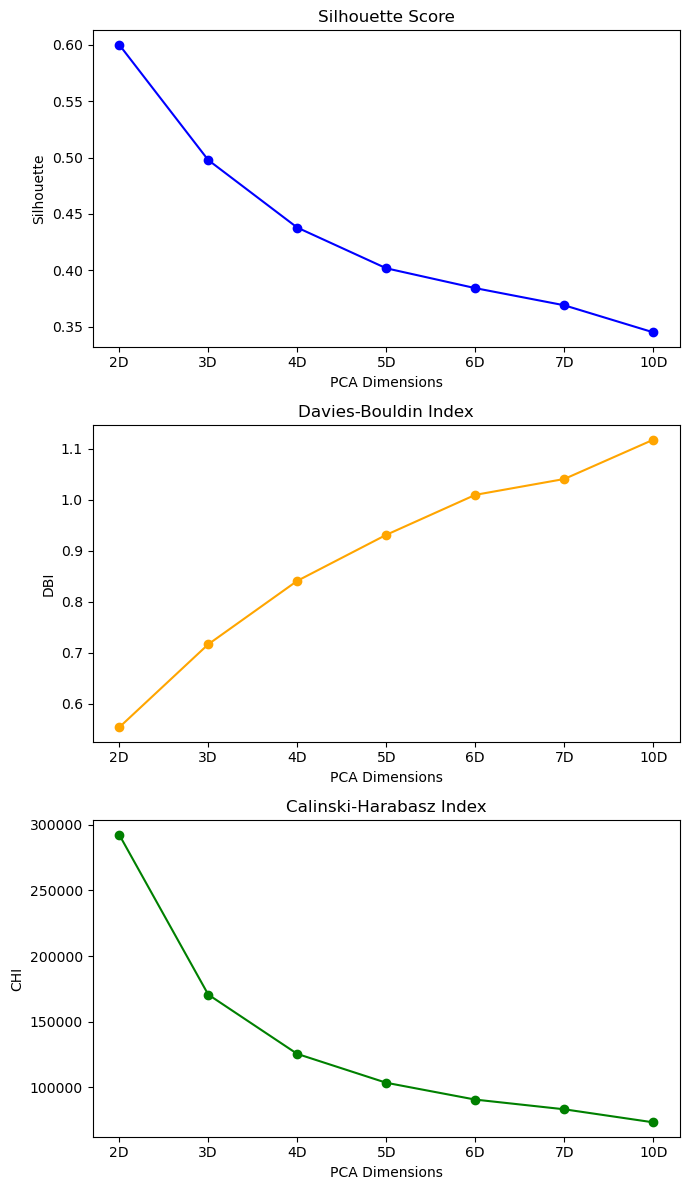

In [107]:
fig, axes = plt.subplots(3, 1, figsize=(7, 12))

axes[0].plot(k_means_spo_results_df.index, k_means_spo_results_df["Silhouette"], marker='o', color='blue')
axes[0].set_title("Silhouette Score")
axes[0].set_xlabel("PCA Dimensions")
axes[0].set_ylabel("Silhouette")

axes[1].plot(k_means_spo_results_df.index, k_means_spo_results_df["DBI"], marker='o', color='orange')
axes[1].set_title("Davies-Bouldin Index")
axes[1].set_xlabel("PCA Dimensions")
axes[1].set_ylabel("DBI")

axes[2].plot(k_means_spo_results_df.index, k_means_spo_results_df["CHI"], marker='o', color='green')
axes[2].set_title("Calinski-Harabasz Index")
axes[2].set_xlabel("PCA Dimensions")
axes[2].set_ylabel("CHI")

plt.tight_layout()
plt.show()

### PCA Componenet VS Validation Metrics on Removal Outliers Data

In [108]:
# Store results for cleaned dataset
sil_results_clean = {}
dbi_results_clean = {}
chi_results_clean = {}

pca_dimensions = [2, 3, 4, 5, 6, 7]

for dim in pca_dimensions:
    X_pca_clean = PCA(n_components=dim, random_state=42).fit_transform(X_scaled_clean)
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
    labels_clean = kmeans.fit_predict(X_pca_clean)
    
    key = f"{dim}D"
    sil_results_clean[key] = silhouette_score(X_pca_clean, labels_clean)
    dbi_results_clean[key] = davies_bouldin_score(X_pca_clean, labels_clean)
    chi_results_clean[key] = calinski_harabasz_score(X_pca_clean, labels_clean)

# Full data (no PCA) baseline for cleaned dataset
full_key_clean = f"{X_scaled_clean.shape[1]}D"
kmeans_full_clean = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_full_clean = kmeans_full_clean.fit_predict(X_scaled_clean)

sil_results_clean[full_key_clean] = silhouette_score(X_scaled_clean, labels_full_clean)
dbi_results_clean[full_key_clean] = davies_bouldin_score(X_scaled_clean, labels_full_clean)
chi_results_clean[full_key_clean] = calinski_harabasz_score(X_scaled_clean, labels_full_clean)


In [109]:
k_means_spo_results_clean_df = pd.DataFrame({
    "Silhouette": sil_results_clean,
    "DBI": dbi_results_clean,
    "CHI": chi_results_clean
}).loc[[f"{d}D" for d in pca_dimensions] + [full_key_clean]]

# Save to CSV
results_path_clean = "k_means_spo_results_clean.csv"
k_means_spo_results_clean_df.to_csv(results_path_clean, index=False)

print(f"Cleaned results saved to {results_path_clean}")


Cleaned results saved to k_means_spo_results_clean.csv


## Cluster Componenet VS Validation Metrics on different dimesnions of data

In [110]:
# store results
silhouette_scores = {}
dbi_scores = {}
chi_scores = {}

k_values = list(range(2, 11))  

# Full 10D (no PCA)
sil_vals, dbi_vals, chi_vals = [], [], []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    sil_vals.append(silhouette_score(X_scaled, labels))
    dbi_vals.append(davies_bouldin_score(X_scaled, labels))
    chi_vals.append(calinski_harabasz_score(X_scaled, labels))
silhouette_scores["Full_10D"] = sil_vals
dbi_scores["Full_10D"] = dbi_vals
chi_scores["Full_10D"] = chi_vals

# PCA 2..7
for d in [2, 3, 4, 5, 6, 7]:
    X_pca = PCA(n_components=d, random_state=42).fit_transform(X_scaled)
    sil_vals, dbi_vals, chi_vals = [], [], []
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = km.fit_predict(X_pca)
        sil_vals.append(silhouette_score(X_pca, labels))
        dbi_vals.append(davies_bouldin_score(X_pca, labels))
        chi_vals.append(calinski_harabasz_score(X_pca, labels))
    silhouette_scores[f"PCA_{d}D"] = sil_vals
    dbi_scores[f"PCA_{d}D"] = dbi_vals
    chi_scores[f"PCA_{d}D"] = chi_vals

# DataFrames
kmeans_spo_sil_df = pd.DataFrame(silhouette_scores, index=k_values)
kmeans_spo_dbi_df = pd.DataFrame(dbi_scores,        index=k_values)
kmeans_spo_chi_df = pd.DataFrame(chi_scores,        index=k_values)

In [113]:
# Save to CSV files
kmeans_spo_sil_df.to_csv("kmeans_spo_silhouette.csv")
kmeans_spo_dbi_df.to_csv("kmeans_spo_dbi.csv")
kmeans_spo_chi_df.to_csv("kmeans_spo_chi.csv")

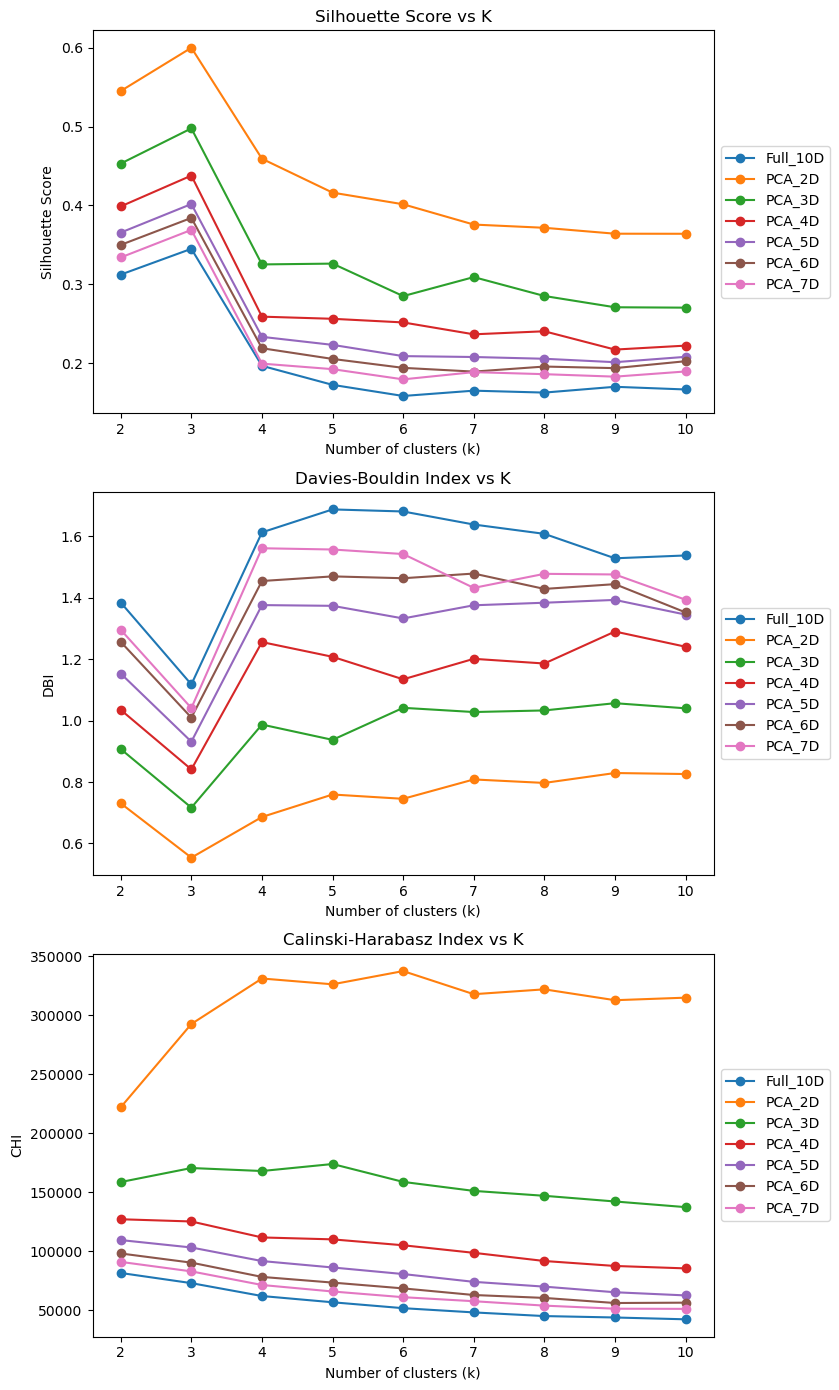

In [117]:
fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# Silhouette plot
for col in kmeans_spo_sil_df.columns:
    axes[0].plot(kmeans_spo_sil_df.index, kmeans_spo_sil_df[col], marker='o', label=col)
axes[0].set_title("Silhouette Score vs K")
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Silhouette Score")
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# DBI plot
for col in kmeans_spo_dbi_df.columns:
    axes[1].plot(kmeans_spo_dbi_df.index, kmeans_spo_dbi_df[col], marker='o', label=col)
axes[1].set_title("Davies-Bouldin Index vs K")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("DBI")
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# CHI plot
for col in kmeans_spo_chi_df.columns:
    axes[2].plot(kmeans_spo_chi_df.index, kmeans_spo_chi_df[col], marker='o', label=col)
axes[2].set_title("Calinski-Harabasz Index vs K")
axes[2].set_xlabel("Number of clusters (k)")
axes[2].set_ylabel("CHI")
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# DBSCAN

Is big or small eps better?

Too small: Almost every point is an outlier (cluster = noise), few or zero clusters formed.

Too large: Merges everything into one big cluster, lose useful separation.

In [25]:
def plot_k_distance_graph(X, k, title_prefix=""):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    k_distances_sorted = np.sort(distances[:, k - 1])

    plt.figure(figsize=(10, 6))
    plt.plot(k_distances_sorted)
    plt.xlabel("Data Points (sorted)")
    plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
    plt.title(f"K-Distance Graph ({title_prefix}, k={k})")
    plt.grid(True)
    plt.show()

In [23]:
def run_dbscan(data, eps=0.8, min_samples=10, original_df=None, interpret=False, top_n=10):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(data)

    # Cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))

    # Noise stats
    noise_points = cluster_sizes.get(-1, 0)
    noise_pct = 100.0 * noise_points / len(labels)

    # Sort non-noise clusters by size
    non_noise_clusters = {cid: size for cid, size in cluster_sizes.items() if cid != -1}
    sorted_clusters = sorted(non_noise_clusters.items(), key=lambda x: x[1], reverse=True)

    print(f"Cluster Sizes (DBSCAN, eps={eps}, min_samples={min_samples}):")
    for cluster_id, size in sorted_clusters[:top_n]:
        print(f"  Cluster {cluster_id}: {size}")
    if len(sorted_clusters) > top_n:
        print(f"  ... plus {len(sorted_clusters) - top_n} more clusters")

    # Print noise info
    print(f"Noise points: {noise_points} ({noise_pct:.2f}%)")

    # Validation metrics (non-noise points only)
    mask = labels != -1
    sil_score_val = dbi_score_val = chi_score_val = None
    if mask.any() and len(np.unique(labels[mask])) >= 2:
        sil_score_val = silhouette_score(data[mask], labels[mask])
        dbi_score_val = davies_bouldin_score(data[mask], labels[mask])
        chi_score_val = calinski_harabasz_score(data[mask], labels[mask])

    print(f"\nDBSCAN Results on {data.shape[0]} samples × {data.shape[1]} features")
    if sil_score_val is not None:
        print(f"Silhouette Score (non-noise)        : {sil_score_val:.3f}")
        print(f"Davies-Bouldin Index (non-noise)    : {dbi_score_val:.3f}")
        print(f"Calinski-Harabasz Index (non-noise) : {chi_score_val:.1f}")
    else:
        print("Silhouette / DBI / CHI: N/A (need ≥2 non-noise clusters)")

    # Optional cluster means
    cluster_means = None
    if original_df is not None and interpret:
        df_temp = original_df.copy()
        df_temp['cluster'] = labels
        top_clusters = [cid for cid, _ in sorted_clusters[:top_n]]
        cluster_means = df_temp[df_temp['cluster'].isin(top_clusters)].groupby('cluster').mean()
        print(f"\nCluster Feature Means (Top {top_n} non-noise clusters):")
        print(cluster_means.round(3))

    return {
        "labels": labels,
        "model": model,
        "cluster_sizes": cluster_sizes,
        "silhouette": sil_score_val,
        "dbi": dbi_score_val,
        "chi": chi_score_val,
        "cluster_means": cluster_means
    }


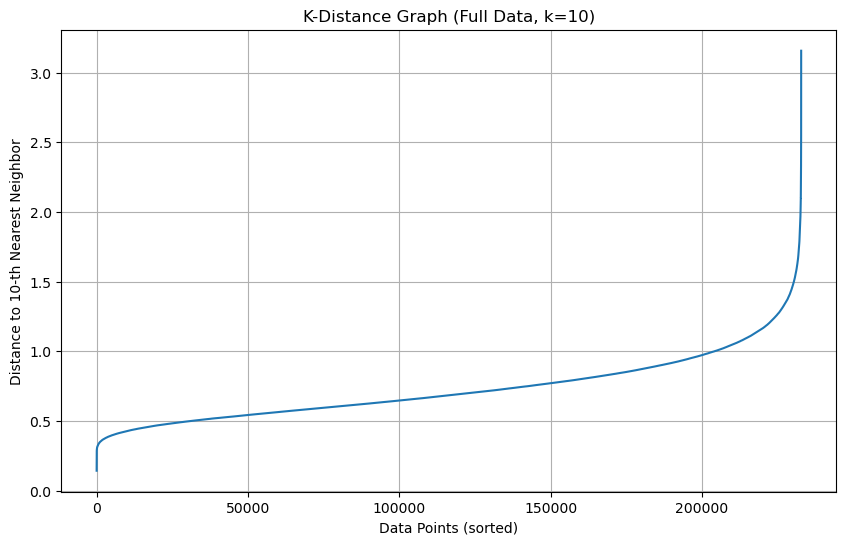

In [122]:
plot_k_distance_graph(X_scaled, k=10, title_prefix="Full Data")

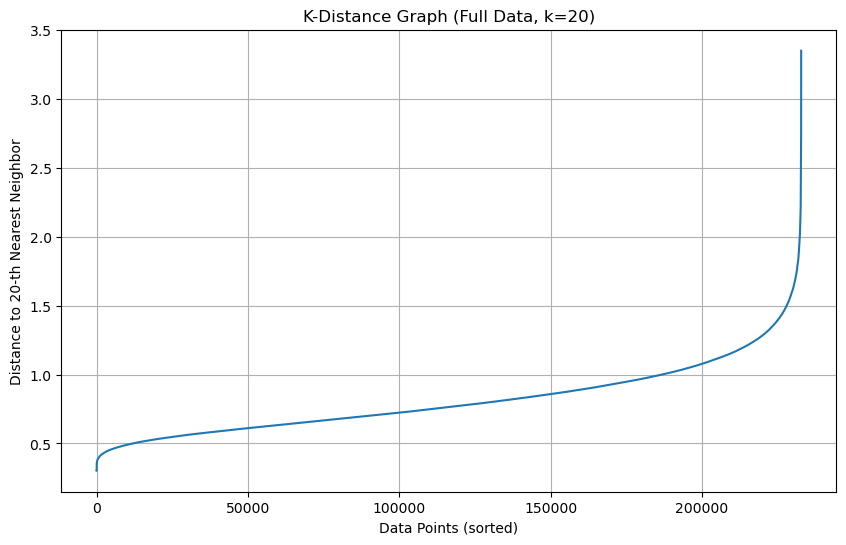

In [123]:
plot_k_distance_graph(X_scaled, k=20, title_prefix="Full Data")

In [124]:
def suggest_eps(X2d, k):
    nn = NearestNeighbors(n_neighbors=k).fit(X2d)
    dists, _ = nn.kneighbors(X2d)
    kd = np.sort(dists[:, -1])  # k-distance
    # simple heuristics
    return {
        "median_kdist": float(np.median(kd)),
        "p80_kdist": float(np.percentile(kd, 80)),
        "p90_kdist": float(np.percentile(kd, 90))
    }

suggest_eps(X_scaled, k=10)

{'median_kdist': 0.6840016059324974,
 'p80_kdist': 0.8994639985271196,
 'p90_kdist': 1.0437696546665796}

In [128]:
suggest_eps(X_scaled, k=20)

{'median_kdist': 0.7636729159225827,
 'p80_kdist': 0.997374940330529,
 'p90_kdist': 1.1533329301286348}

## Full Data (No PCA)

In [47]:
# DBSCAN on full data (k=10)
dbscan_full = run_dbscan(X_scaled, eps=0.8, min_samples=10, original_df=df, interpret=True, top_n=3)

Cluster Sizes (DBSCAN, eps=0.8, min_samples=10):
  Cluster 0: 181902
  Cluster 42: 6947
  Cluster 56: 45
  ... plus 88 more clusters
Noise points: 42895 (18.43%)

DBSCAN Results on 232725 samples × 10 features
Silhouette Score (non-noise)        : -0.393
Davies-Bouldin Index (non-noise)    : 1.132
Calinski-Harabasz Index (non-noise) : 344.3

Cluster Feature Means (Top 3 non-noise clusters):
         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            43.199         0.333         0.556   0.573             0.123   
42           21.118         0.815         0.559   0.709             0.000   
56            0.489         0.968         0.787   0.247             0.897   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.166    -9.193        0.076  117.162    0.452  
42          0.796   -11.430        0.

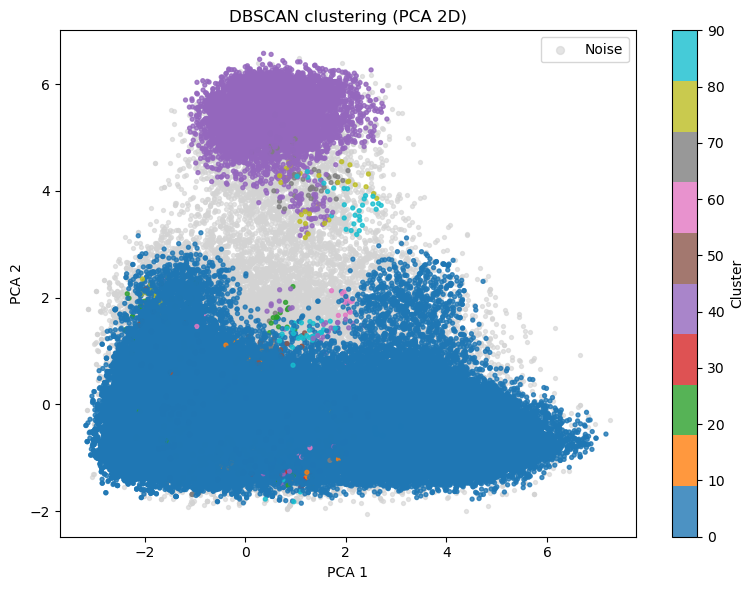

In [48]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled) 

plot_results(X_2d, dbscan_full['labels'], title="DBSCAN clustering (PCA 2D)")

In [24]:
# DBSCAN on full data (k=20)
dbscan_full_k20 = run_dbscan(X_scaled, eps=1.0, min_samples=20, original_df=df, interpret=True, top_n=3)

Cluster Sizes (DBSCAN, eps=1.0, min_samples=20):
  Cluster 0: 205563
  Cluster 1: 8163
  Cluster 2: 38
Noise points: 18961 (8.15%)

DBSCAN Results on 232725 samples × 10 features
Silhouette Score (non-noise)        : 0.387
Davies-Bouldin Index (non-noise)    : 0.737
Calinski-Harabasz Index (non-noise) : 15972.2

Cluster Feature Means (Top 3 non-noise clusters):
         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            42.699         0.341         0.556   0.570              0.14   
1            20.974         0.814         0.560   0.695              0.00   
2             0.579         0.844         0.684   0.165              0.00   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.177    -9.303        0.081  117.807    0.455  
1           0.773   -11.698        0.917   95.555    0.396  
2     

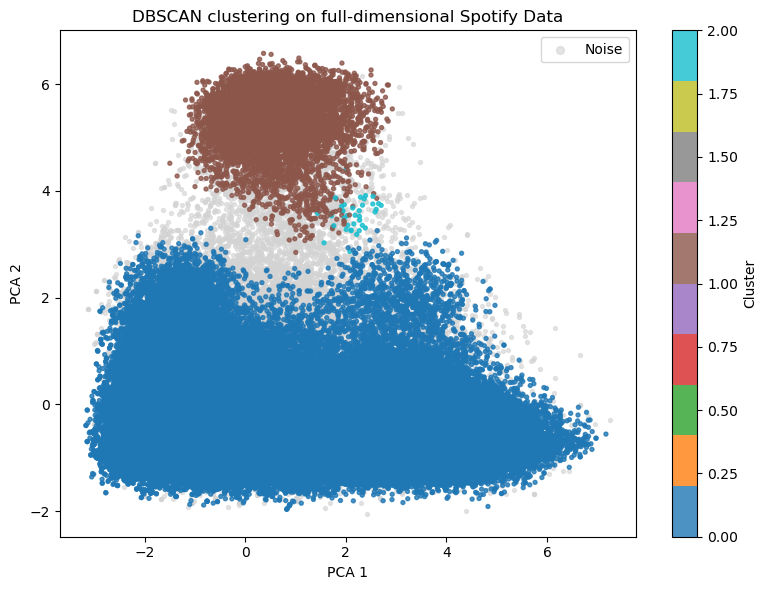

In [25]:
plot_results(X_2d, dbscan_full_k20['labels'], title="DBSCAN clustering on full-dimensional Spotify Data")

In [31]:
eps_values = [0.8, 0.9, 1.00, 1.10, 1.20]
min_samples_values = [5, 10, 15, 20]

results_list = []

for eps in eps_values:
    for min_samp in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X_scaled)

        # Noise info
        noise_points = np.sum(labels == -1)
        noise_pct = 100 * noise_points / len(labels)

        # Metrics on non-noise points
        mask = labels != -1
        if mask.sum() > 0 and len(np.unique(labels[mask])) >= 2:
            sil = silhouette_score(X_scaled[mask], labels[mask])
            dbi = davies_bouldin_score(X_scaled[mask], labels[mask])
            chi = calinski_harabasz_score(X_scaled[mask], labels[mask])
        else:
            sil = dbi = chi = np.nan

        results_list.append({
            "eps": eps,
            "min_samples": min_samp,
            "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
            "noise_pct": noise_pct,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

# Convert to DataFrame
dbscan_full_spo_df = pd.DataFrame(results_list)

In [34]:
dbscan_full_spo_df.to_csv("dbscan_full_spo.csv")

In [35]:
dbscan_full_spo_df

eps  min_samples  n_clusters  noise_pct  silhouette       dbi  \
0   0.8            5         539  13.003330   -0.513636  1.013006   
1   0.8           10          91  18.431625   -0.393164  1.131973   
2   0.8           15          29  22.390805   -0.294258  1.115620   
3   0.8           20          14  25.645719   -0.292338  1.297893   
4   0.9            5         270   7.211945   -0.444714  0.983782   
5   0.9           10          37  10.292835   -0.286364  1.038372   
6   0.9           15          12  12.696960   -0.090200  0.994064   
7   0.9           20          11  14.576431   -0.240882  1.233220   
8   1.0            5         132   3.906757   -0.343360  0.945263   
9   1.0           10          19   5.599312   -0.105897  1.016972   
10  1.0           15           5   6.958857    0.188445  1.118012   
11  1.0           20           3   8.147384    0.387142  0.737036   
12  1.1            5          68   2.103341   -0.328148  0.910530   
13  1.1           10           8   3.109249   -0.068592  1.005550   
14  1.1           15           3   3.824686    0.314002  0.783132   
15  1.1           20           3   4.486841    0.201752  0.880655   
16  1.2            5          33   1.132667   -0.190565  0.866719   
17  1.2           10           8   1.671930    0.010790  0.935145   
18  1.2           15           4   2.112794    0.185878  1.022731   
19  1.2           20           3   2.478032    0.301148  0.805605   

             chi  
0      66.524429  
1     344.278139  
2    1025.447181  
3    2114.008059  
4     127.535494  
5     894.631003  
6    2860.841588  
7    3070.182568  
8     256.089385  
9    1809.722237  
10   8059.673935  
11  15972.176012  
12      9.066041  
13   4643.625294  
14  16204.049801  
15  16164.597863  
16      9.486809  
17     16.209792  
18  10834.362748  
19  16228.502641

## PCA 2D

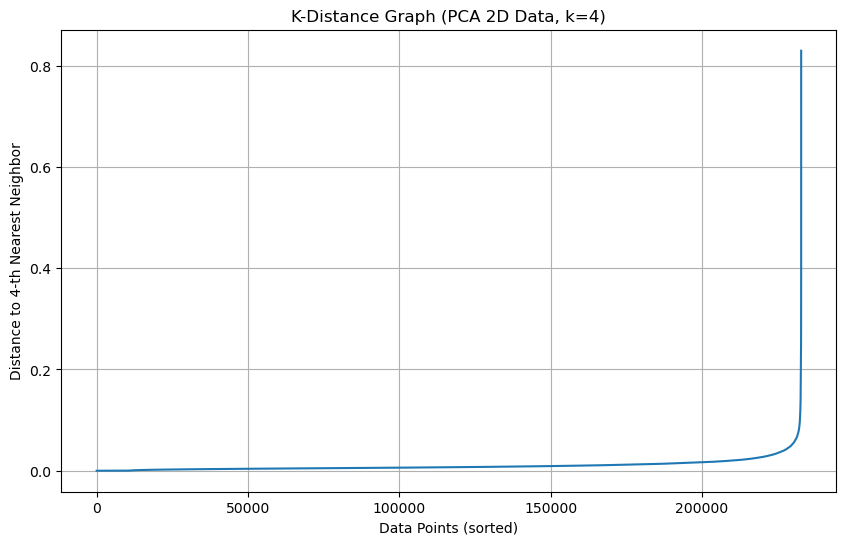

In [21]:
# Kmeans on PCA 2D full data 
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

plot_k_distance_graph(X_2d, k=4, title_prefix="PCA 2D Data")

In [25]:
suggest_eps(X_2d, k=4)

{'median_kdist': 0.006885992361334709,
 'p80_kdist': 0.013631783062726046,
 'p90_kdist': 0.01994201689722865}

In [28]:
dbscan_2d = run_dbscan(X_2d, eps=0.01, min_samples=4, original_df=df, interpret=True, top_n=3)

Cluster Sizes (DBSCAN, eps=0.01, min_samples=4):
  Cluster 0: 111717
  Cluster 24: 335
  Cluster 150: 322
  ... plus 6667 more clusters
Noise points: 59449 (25.54%)

DBSCAN Results on 232725 samples × 2 features
Silhouette Score (non-noise)        : -0.345
Davies-Bouldin Index (non-noise)    : 0.571
Calinski-Harabasz Index (non-noise) : 152.9

Cluster Feature Means (Top 3 non-noise clusters):
         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            46.967         0.171         0.616   0.689             0.052   
24           48.197         0.584         0.518   0.383             0.173   
150          47.606         0.551         0.525   0.412             0.175   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.158    -6.687        0.084  122.414    0.525  
24          0.114   -10.813        

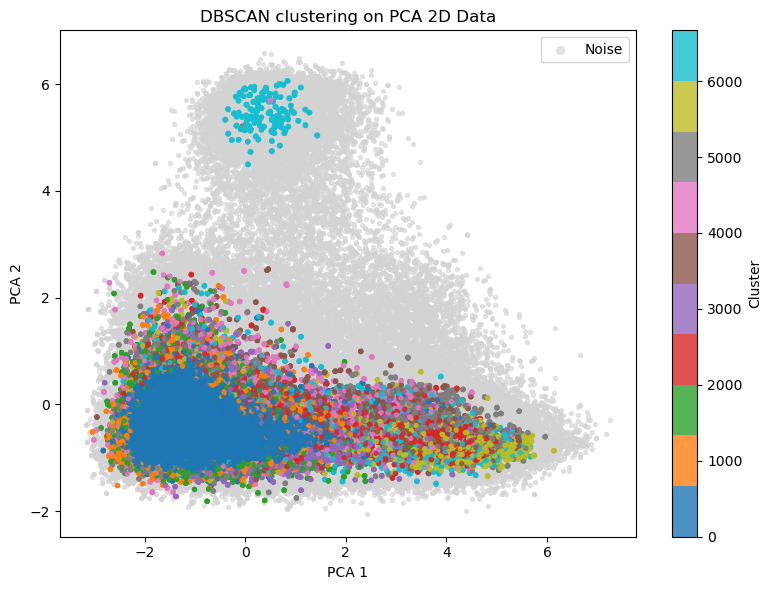

In [46]:
# PCA 2D for visualisation
plot_results(X_2d, dbscan_2d['labels'], title="DBSCAN clustering on PCA 2D Data")

In [71]:
dbscan_2d = run_dbscan(X_2d, eps=0.04, top_n=3)

Cluster Sizes (DBSCAN, eps=0.04, min_samples=10):
  Cluster 0: 211572
  Cluster 1: 5082
  Cluster 16: 91
  ... plus 203 more clusters
Noise points: 12681 (5.45%)

DBSCAN Results on 232725 samples × 2 features
Silhouette Score (non-noise)        : -0.551
Davies-Bouldin Index (non-noise)    : 0.690
Calinski-Harabasz Index (non-noise) : 277.0


In [73]:
eps_values = [0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
min_samples_values = [4, 5, 6, 8, 10]

pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

results_list_2d = []

for eps in eps_values:
    for min_samp in min_samples_values:
        labels = DBSCAN(eps=eps, min_samples=min_samp).fit_predict(X_2d)

        noise_points = np.sum(labels == -1)
        noise_pct = 100.0 * noise_points / len(labels)

        mask = labels != -1
        if mask.sum() > 0 and len(np.unique(labels[mask])) >= 2:
            sil = silhouette_score(X_2d[mask], labels[mask])
            dbi = davies_bouldin_score(X_2d[mask], labels[mask])
            chi = calinski_harabasz_score(X_2d[mask], labels[mask])
        else:
            sil = dbi = chi = np.nan

        results_list_2d.append({
            "eps": eps,
            "min_samples": min_samp,
            "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
            "noise_pct": noise_pct,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

dbscan_2d_df = pd.DataFrame(results_list_2d)

In [54]:
eps_values = [0.01, 0.012, 0.015, 0.018, 0.02]
min_samples_values = [3, 4, 5, 6]

pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

results_list_2d = []

for eps in eps_values:
    for min_samp in min_samples_values:
        labels = DBSCAN(eps=eps, min_samples=min_samp).fit_predict(X_2d)

        noise_points = np.sum(labels == -1)
        noise_pct = 100.0 * noise_points / len(labels)

        mask = labels != -1
        if mask.sum() > 0 and len(np.unique(labels[mask])) >= 2:
            sil = silhouette_score(X_2d[mask], labels[mask])
            dbi = davies_bouldin_score(X_2d[mask], labels[mask])
            chi = calinski_harabasz_score(X_2d[mask], labels[mask])
        else:
            sil = dbi = chi = np.nan

        results_list_2d.append({
            "eps": eps,
            "min_samples": min_samp,
            "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
            "noise_pct": noise_pct,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

dbscan_2d_df = pd.DataFrame(results_list_2d)

In [63]:
dbscan_2d_df.to_csv("dbscan_2d_spo.csv")

In [69]:
dbscan_2d_df

eps  min_samples  n_clusters  noise_pct  silhouette       dbi        chi
0   0.010            3       10329  18.818348   -0.488220  6.353219  16.099348
1   0.010            4        6670  25.544742   -0.453049  6.965991  17.655935
2   0.010            5        4733  31.419057   -0.413774  7.441239  18.060850
3   0.010            6        3630  36.606725   -0.400028  7.855555  16.954965
4   0.012            3        8160  13.696853   -0.474162  6.410315  20.371475
5   0.012            4        5573  18.915028   -0.435358  7.061541  23.101112
6   0.012            5        4131  23.910624   -0.410601  7.461746  24.329292
7   0.012            6        3178  28.507466   -0.399731  7.757280  24.077778
8   0.015            3        5330   9.069073   -0.460307  6.118945  30.055850
9   0.015            4        3721  12.650124   -0.417303  6.881393  36.626453
10  0.015            5        3032  16.108282   -0.398617  7.493459  38.648778
11  0.015            6        2549  19.637340   -0.370015  7.848541  39.204152
12  0.018            3        3661   6.341820   -0.482922  5.747394  17.212248
13  0.018            4        2533   8.890321   -0.446751  6.488257  21.548655
14  0.018            5        2043  11.372220   -0.417804  7.022769  27.094994
15  0.018            6        1746  14.005801   -0.356676  7.435476  63.135406
16  0.020            3        2999   5.186379   -0.476042  5.557940  18.290194
17  0.020            4        2058   7.284563   -0.432623  6.250079  22.998252
18  0.020            5        1672   9.309700   -0.412634  6.764169  25.199901
19  0.020            6        1392  11.493823   -0.405549  7.112961  26.427084

## PCA 5D

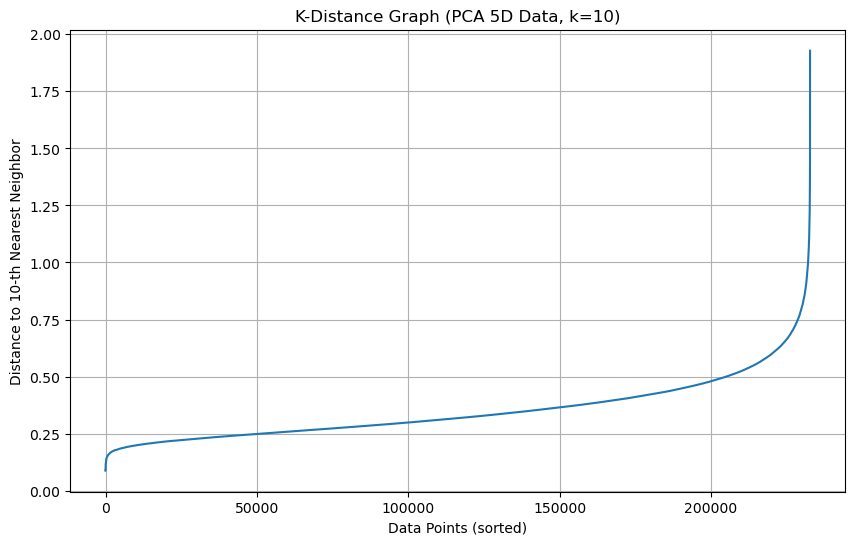

In [22]:
# DBSCAN on PCA 5D full data 
pca_5d = PCA(n_components=5)
X_5d = pca_5d.fit_transform(X_scaled)

plot_k_distance_graph(X_5d, k=10, title_prefix="PCA 5D Data")

In [26]:
suggest_eps(X_5d, k=10)


{'median_kdist': 0.31789884112040806,
 'p80_kdist': 0.4365583728470049,
 'p90_kdist': 0.5211451224048012}

In [72]:
dbscan_5d = run_dbscan(X_5d, eps=0.4, min_samples=10, original_df=df, interpret=True, top_n=3)

Cluster Sizes (DBSCAN, eps=0.4, min_samples=10):
  Cluster 0: 188413
  Cluster 57: 5453
  Cluster 1: 344
  ... plus 147 more clusters
Noise points: 37027 (15.91%)

DBSCAN Results on 232725 samples × 5 features
Silhouette Score (non-noise)        : -0.513
Davies-Bouldin Index (non-noise)    : 0.983
Calinski-Harabasz Index (non-noise) : 224.7

Cluster Feature Means (Top 3 non-noise clusters):
         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            43.773         0.325         0.564   0.580             0.132   
1            15.462         0.957         0.223   0.127             0.026   
57           20.806         0.811         0.555   0.720             0.000   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.167    -9.069        0.080  116.678    0.459  
1           0.120   -19.004        0.

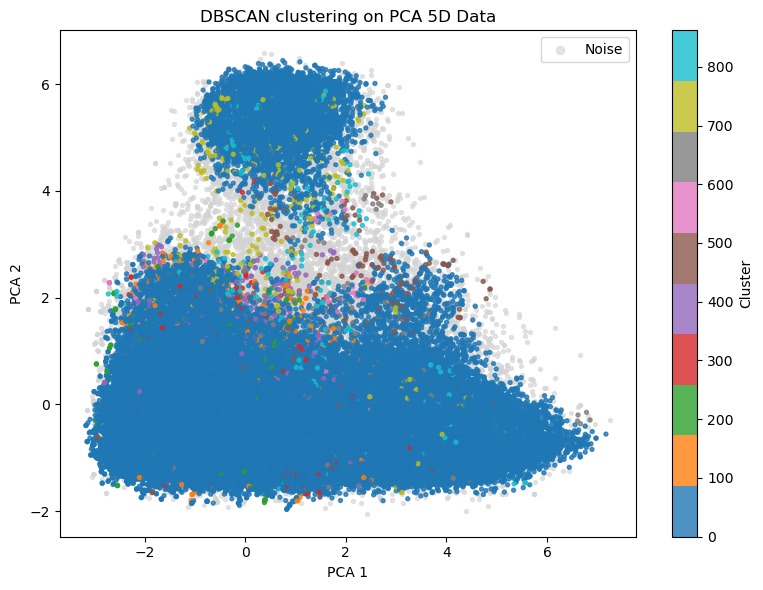

In [51]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d_from_5d = pca_2d.fit_transform(X_5d) 

plot_results(X_2d_from_5d, dbscan_5d['labels'], title="DBSCAN clustering on PCA 5D Data")

In [74]:
eps_values = [0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
min_samples_values = [5, 7, 8, 10]

pca_5d = PCA(n_components=5)
X_5d = pca_5d.fit_transform(X_scaled)

results_list_5d = []

for eps in eps_values:
    for min_samp in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X_5d)

        # Noise info
        noise_points = np.sum(labels == -1)
        noise_pct = 100.0 * noise_points / len(labels)

        # Metrics on non-noise points (computed in 5D space)
        mask = labels != -1
        if mask.sum() > 0 and len(np.unique(labels[mask])) >= 2:
            sil = silhouette_score(X_5d[mask], labels[mask])
            dbi = davies_bouldin_score(X_5d[mask], labels[mask])
            chi = calinski_harabasz_score(X_5d[mask], labels[mask])
        else:
            sil = dbi = chi = np.nan

        results_list_5d.append({
            "eps": eps,
            "min_samples": min_samp,
            "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
            "noise_pct": noise_pct,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

# Convert to DataFrame 
dbscan_5d_df = pd.DataFrame(results_list_5d)

In [76]:
dbscan_5d_df.to_csv("dbscan_5d_spo.csv")

In [77]:
dbscan_5d_df

eps  min_samples  n_clusters  noise_pct  silhouette       dbi  \
0   0.35            5        1019  15.335697   -0.635024  0.945998   
1   0.35            7         492  20.256956   -0.616271  0.976416   
2   0.35            8         390  22.399828   -0.611497  1.005759   
3   0.35           10         249  26.297561   -0.584189  1.060289   
4   0.40            5         574   8.973681   -0.588075  0.910779   
5   0.40            7         280  11.874530   -0.537276  0.935772   
6   0.40            8         210  13.295520   -0.545601  0.946009   
7   0.40           10         150  15.910194   -0.513131  0.982858   
8   0.45            5         293   5.278333   -0.540339  0.875681   
9   0.45            7         170   7.051241   -0.474623  0.909421   
10  0.45            8         130   7.914491   -0.455929  0.939776   
11  0.45           10          76   9.631539   -0.414753  0.967730   
12  0.50            5         153   3.178000   -0.466092  0.850354   
13  0.50            7          80   4.219143   -0.370538  0.870621   
14  0.50            8          73   4.747234   -0.347450  0.901311   
15  0.50           10          38   5.807283   -0.309294  0.893251   
16  0.55            5          91   1.926738   -0.405527  0.845543   
17  0.55            7          35   2.584166   -0.265236  0.885714   
18  0.55            8          28   2.928779   -0.237526  0.878147   
19  0.55           10          23   3.525620   -0.112352  0.813778   
20  0.60            5          38   1.185519   -0.285016  0.821157   
21  0.60            7          24   1.552046   -0.176511  0.828497   
22  0.60            8          20   1.747126   -0.156539  0.847812   
23  0.60           10           9   2.184553   -0.081673  0.874946   

            chi  
0     41.567246  
1     69.557024  
2     86.024669  
3    118.080657  
4     71.061924  
5    130.097849  
6    165.475929  
7    224.714421  
8    137.679207  
9    225.898709  
10   287.654710  
11   469.943725  
12   260.131749  
13   487.102768  
14   532.353266  
15  1008.590849  
16     9.727928  
17    12.718919  
18    13.980909  
19  1749.079695  
20    11.383048  
21    14.577789  
22    14.913464  
23    19.534880

## PCA 7D

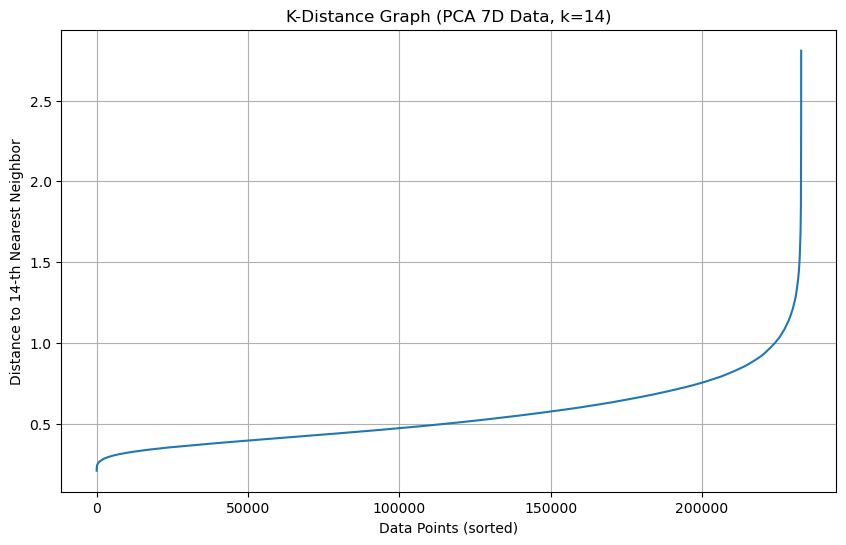

In [23]:
# DBSCAN on PCA 7D full data 
pca_7d = PCA(n_components=7)
X_7d = pca_7d.fit_transform(X_scaled)

plot_k_distance_graph(X_7d, k=14, title_prefix="PCA 7D Data")

In [27]:
suggest_eps(X_7d, k=14)

{'median_kdist': 0.5008230778158447,
 'p80_kdist': 0.6892173197436929,
 'p90_kdist': 0.8153193994698762}

In [30]:
dbscan_7d = run_dbscan(X_7d, eps=0.6, min_samples=14, original_df=df, interpret=True, top_n=3)

Cluster Sizes (DBSCAN, eps=0.6, min_samples=14):
  Cluster 0: 182106
  Cluster 29: 6506
  Cluster 10: 35
  ... plus 56 more clusters
Noise points: 43225 (18.57%)

DBSCAN Results on 232725 samples × 7 features
Silhouette Score (non-noise)        : -0.379
Davies-Bouldin Index (non-noise)    : 1.071
Calinski-Harabasz Index (non-noise) : 561.7

Cluster Feature Means (Top 3 non-noise clusters):
         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            43.496         0.332         0.560   0.574             0.116   
10           49.571         0.726         0.736   0.348             0.007   
29           20.851         0.811         0.560   0.708             0.000   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.163    -9.145        0.079  116.869    0.456  
10          0.125   -11.178        0.3

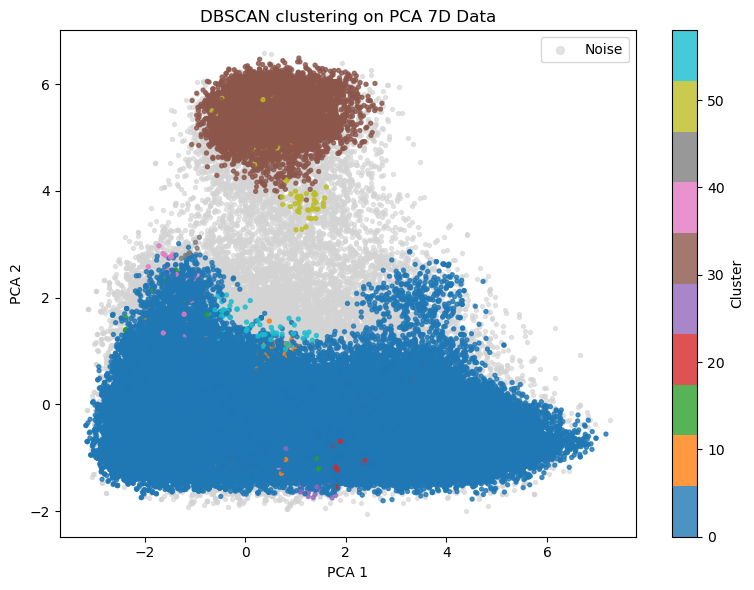

In [52]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d_from_7d = pca_2d.fit_transform(X_7d) 

plot_results(X_2d_from_7d, dbscan_7d['labels'], title="DBSCAN clustering on PCA 7D Data")

In [78]:
dbscan_7d_1 = run_dbscan(X_7d, eps=0.7, min_samples=14, original_df=df, interpret=True, top_n=3)

Cluster Sizes (DBSCAN, eps=0.7, min_samples=14):
  Cluster 0: 202936
  Cluster 8: 7619
  Cluster 13: 197
  ... plus 14 more clusters
Noise points: 21758 (9.35%)

DBSCAN Results on 232725 samples × 7 features
Silhouette Score (non-noise)        : -0.200
Davies-Bouldin Index (non-noise)    : 0.983
Calinski-Harabasz Index (non-noise) : 2154.9

Cluster Feature Means (Top 3 non-noise clusters):
         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            42.879         0.340         0.557   0.570             0.136   
8            20.809         0.810         0.563   0.692             0.000   
13           20.873         0.798         0.492   0.768             0.000   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.174    -9.289        0.081  117.526    0.455  
8           0.776   -11.772        0.9

In [79]:
eps_values = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
min_samples_values = [10, 12, 14, 16]

pca_7d = PCA(n_components=7)
X_7d = pca_7d.fit_transform(X_scaled)

results_list_7d = []

for eps in eps_values:
    for min_samp in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X_7d)

        # Noise info
        noise_points = np.sum(labels == -1)
        noise_pct = 100.0 * noise_points / len(labels)

        # Metrics on non-noise points 
        mask = labels != -1
        if mask.sum() > 0 and len(np.unique(labels[mask])) >= 2:
            sil = silhouette_score(X_7d[mask], labels[mask])
            dbi = davies_bouldin_score(X_7d[mask], labels[mask])
            chi = calinski_harabasz_score(X_7d[mask], labels[mask])
        else:
            sil = dbi = chi = np.nan

        results_list_7d.append({
            "eps": eps,
            "min_samples": min_samp,
            "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
            "noise_pct": noise_pct,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

# Convert to DataFrame 
dbscan_7d_df = pd.DataFrame(results_list_7d)

In [80]:
dbscan_7d_df.to_csv("dbscan_7d_spo.csv")

In [81]:
dbscan_7d_df

eps  min_samples  n_clusters  noise_pct  silhouette       dbi  \
0   0.55           10         153  21.515523   -0.483952  1.048957   
1   0.55           12          99  23.689763   -0.458290  1.095401   
2   0.55           14          73  25.620797   -0.445793  1.136332   
3   0.55           16          63  27.474917   -0.438162  1.189797   
4   0.60           10          92  15.325384   -0.443615  1.065344   
5   0.60           12          72  17.064776   -0.397643  1.082810   
6   0.60           14          59  18.573424   -0.379122  1.070836   
7   0.60           16          39  20.018906   -0.375688  1.094877   
8   0.65           10          65  10.676550   -0.387410  1.004726   
9   0.65           12          55  12.074766   -0.364019  1.027064   
10  0.65           14          38  13.288216   -0.349242  1.035072   
11  0.65           16          35  14.417016   -0.339274  1.102532   
12  0.70           10          39   7.463315   -0.296606  0.907943   
13  0.70           12          30   8.400902   -0.299014  1.009352   
14  0.70           14          17   9.349232   -0.199536  0.983207   
15  0.70           16          18  10.169513   -0.256947  1.080227   
16  0.75           10          25   5.170480   -0.259251  0.965002   
17  0.75           12          21   5.819315   -0.185383  0.950000   
18  0.75           14           8   6.504243   -0.062777  0.894728   
19  0.75           16          11   7.142335   -0.083109  0.918758   
20  0.80           10          15   3.647653   -0.134146  0.887486   
21  0.80           12          11   4.104415   -0.090139  1.019013   
22  0.80           14           7   4.516060    0.086362  0.981648   
23  0.80           16           6   4.940165    0.052580  0.783348   

            chi  
0    215.131680  
1    316.886221  
2    428.549048  
3    496.929290  
4    372.952353  
5    467.217197  
6    561.672180  
7    835.941778  
8    545.125052  
9    636.557008  
10   905.706888  
11   983.808402  
12   923.485834  
13  1199.407075  
14  2154.910085  
15  2016.483675  
16  1459.996272  
17  1748.168953  
18  4939.983625  
19  3467.088565  
20  2512.732596  
21  3508.853175  
22  5821.259994  
23  6960.898906

# Agglomerative Hierarchical Clustering

In [29]:
complete_clustering = linkage(X_scaled, method="complete", metric="euclidean")
average_clustering = linkage(X_scaled, method="average", metric="euclidean")
single_clustering = linkage(X_scaled, method="single", metric="euclidean")
ward_clustering = linkage(X_scaled, method="ward", metric="euclidean")

MemoryError: Unable to allocate 202. GiB for an array with shape (27080346450,) and data type float64

In [26]:
def run_agglomerative(data, k, original_df=None, interpret=False, linkage="ward"):
    model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = model.fit_predict(data)

    # Cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    print(f"Cluster Sizes (Agglomerative, k={k}, linkage={linkage}):")
    for cid, size in cluster_sizes.items():
        print(f"  Cluster {cid}: {size}")

    # Validation metrics
    sil = silhouette_score(data, labels)
    dbi = davies_bouldin_score(data, labels)
    chi = calinski_harabasz_score(data, labels)

    n_samples, n_features = data.shape
    print(f"\nAgglomerative Results on data with shape: {n_samples} samples × {n_features} features")
    print(f"Silhouette Score (Range -1 to 1)           : {sil:.3f}")
    print(f"Davies-Bouldin Index (Lower is better)     : {dbi:.3f}")
    print(f"Calinski-Harabasz Index (Higher is better) : {chi:.1f}")

    # Optional cluster means from original_df
    cluster_means = None
    if original_df is not None:
        df_temp = original_df.copy()
        df_temp["cluster"] = labels
        cluster_means = df_temp.groupby("cluster").mean()
        if interpret:
            print(f"\nCluster Feature Means (k={k}, linkage={linkage}):\n")
            print(cluster_means.round(3))

    return {
        "labels": labels,
        "model": model,
        "cluster_sizes": cluster_sizes,
        "silhouette": sil,
        "dbi": dbi,
        "chi": chi,
        "cluster_means": cluster_means
    }


## Resample the num of data

In [28]:
X_sample, df_sample = resample(X_scaled, df, n_samples=10000, random_state=42)
X_sample_clean, df_sample_clean = resample(X_scaled_clean, df_clean, n_samples=10000, random_state=42)

## Plot Dendogram

In [88]:
complete_clustering = linkage(X_sample, method="complete", metric="euclidean")
average_clustering = linkage(X_sample, method="average", metric="euclidean")
ward_clustering = linkage(X_sample, method="ward", metric="euclidean")
single_clustering = linkage(X_sample, method="single", metric="euclidean")

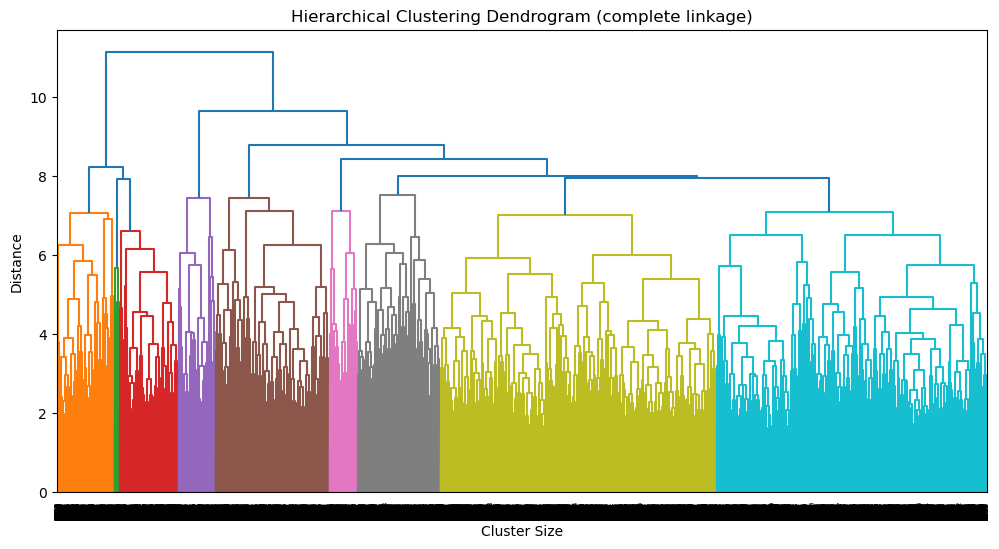

In [86]:
plt.figure(figsize=(12, 6))
dendrogram(complete_clustering)
plt.title('Hierarchical Clustering Dendrogram (complete linkage)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

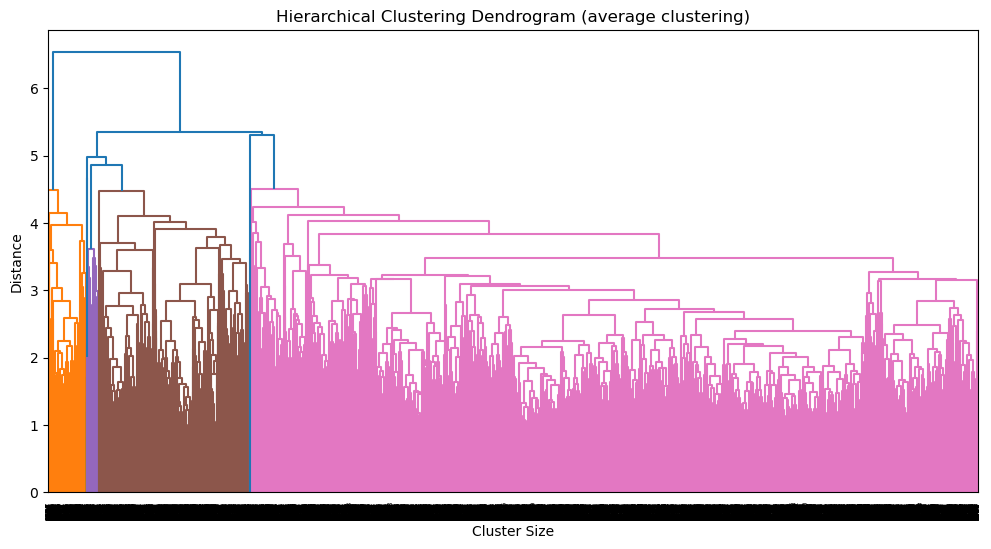

In [18]:
plt.figure(figsize=(12, 6))
dendrogram(average_clustering)
plt.title('Hierarchical Clustering Dendrogram (average clustering)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

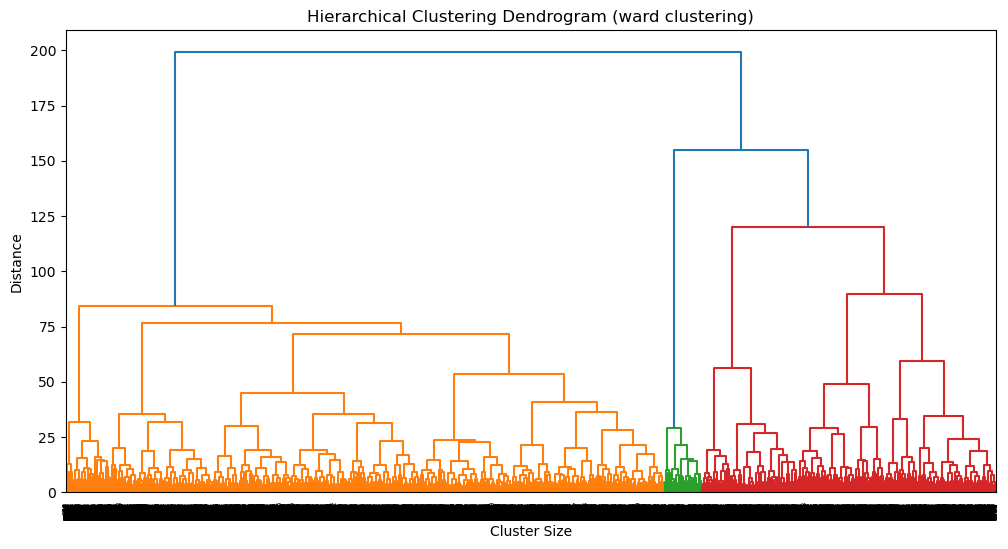

In [17]:
plt.figure(figsize=(12, 6))
dendrogram(ward_clustering)
plt.title('Hierarchical Clustering Dendrogram (ward clustering)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

In [15]:
X_sample = resample(X_scaled, n_samples=5000, random_state=42)
single_clustering = linkage(X_sample, method="single", metric="euclidean")

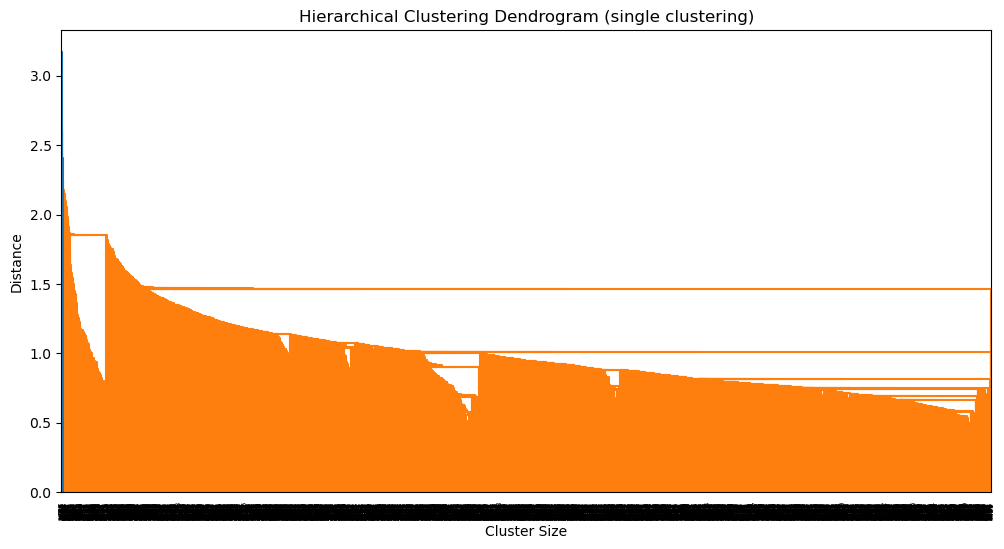

In [16]:
plt.figure(figsize=(12, 6))
dendrogram(single_clustering)
plt.title('Hierarchical Clustering Dendrogram (single clustering)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

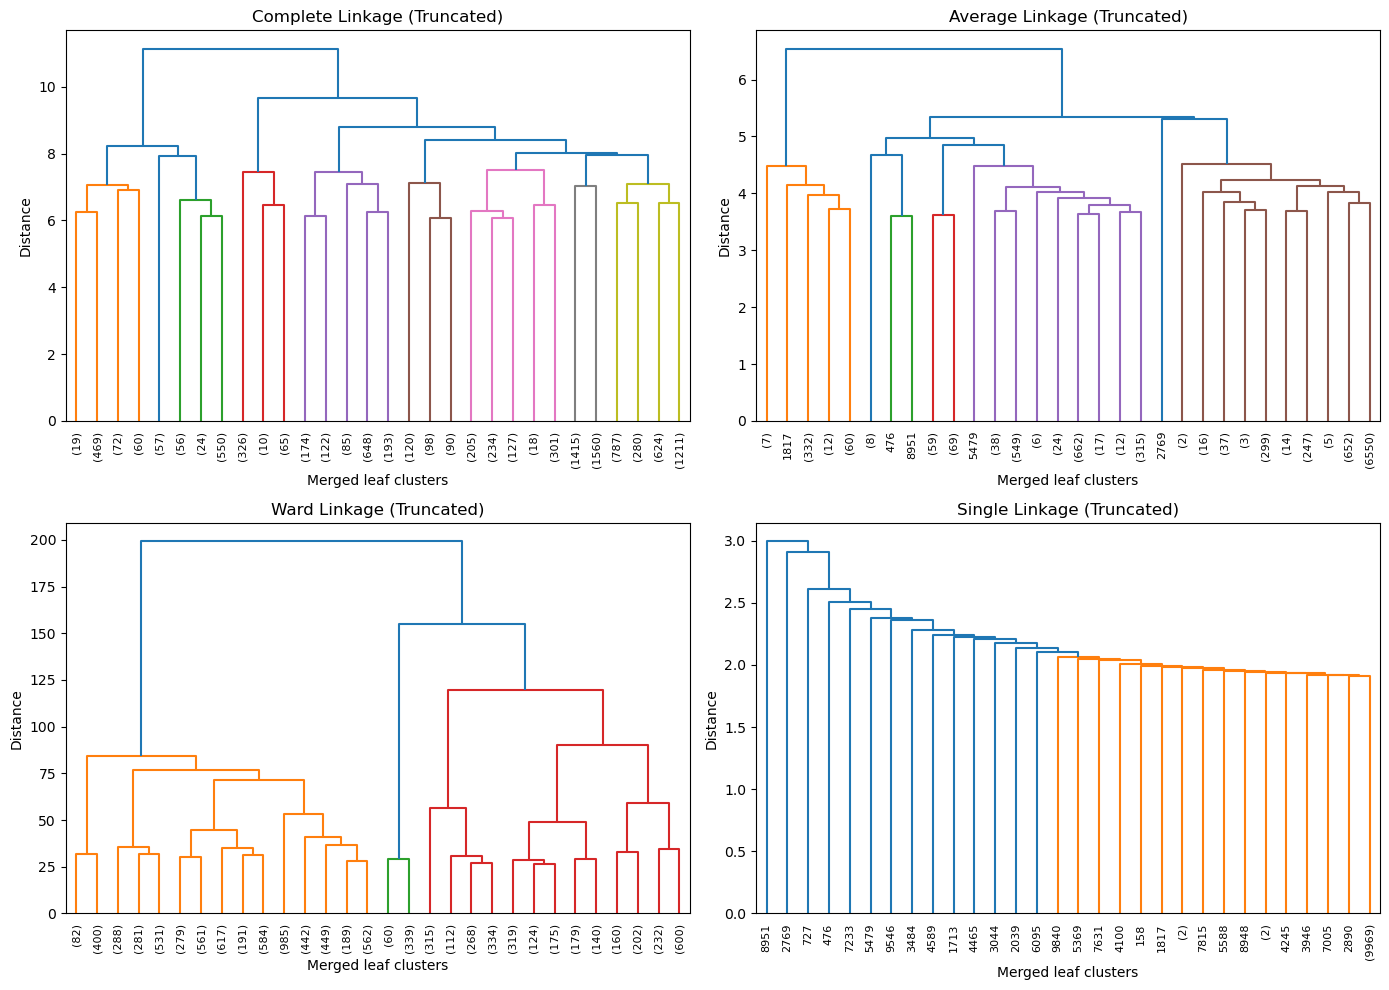

In [89]:
linkage_methods = {
    "Complete": complete_clustering,
    "Average": average_clustering,
    "Ward": ward_clustering,
    "Single": single_clustering
}

plt.figure(figsize=(14, 10))

for i, (name, Z) in enumerate(linkage_methods.items(), 1):
    plt.subplot(2, 2, i)
    dendrogram(
        Z,
        truncate_mode='lastp',  # only show the last p merged clusters
        p=30,                   # number of leaf clusters to show
        show_leaf_counts=True,
        leaf_rotation=90.,
        leaf_font_size=8.
    )
    plt.title(f'{name} Linkage (Truncated)')
    plt.xlabel('Merged leaf clusters')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()


## Fit to agglomerative clustering

In [104]:
linkage_methods = ["ward", "complete", "average", "single"]
agg_results_list = []

for linkage_method in linkage_methods:
    for k in range(2, 11):
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
        labels = model.fit_predict(X_sample)

        sil = silhouette_score(X_sample, labels)
        dbi = davies_bouldin_score(X_sample, labels)
        chi = calinski_harabasz_score(X_sample, labels)

        agg_results_list.append({
            "Linkage": linkage_method,
            "k": k,
            "Silhouette": sil,
            "Davies-Bouldin": dbi,
            "Calinski-Harabasz": chi
        })

agg_results_df = pd.DataFrame(agg_results_list)
agg_results_df.to_csv("agg_clustering_results.csv", index=False)

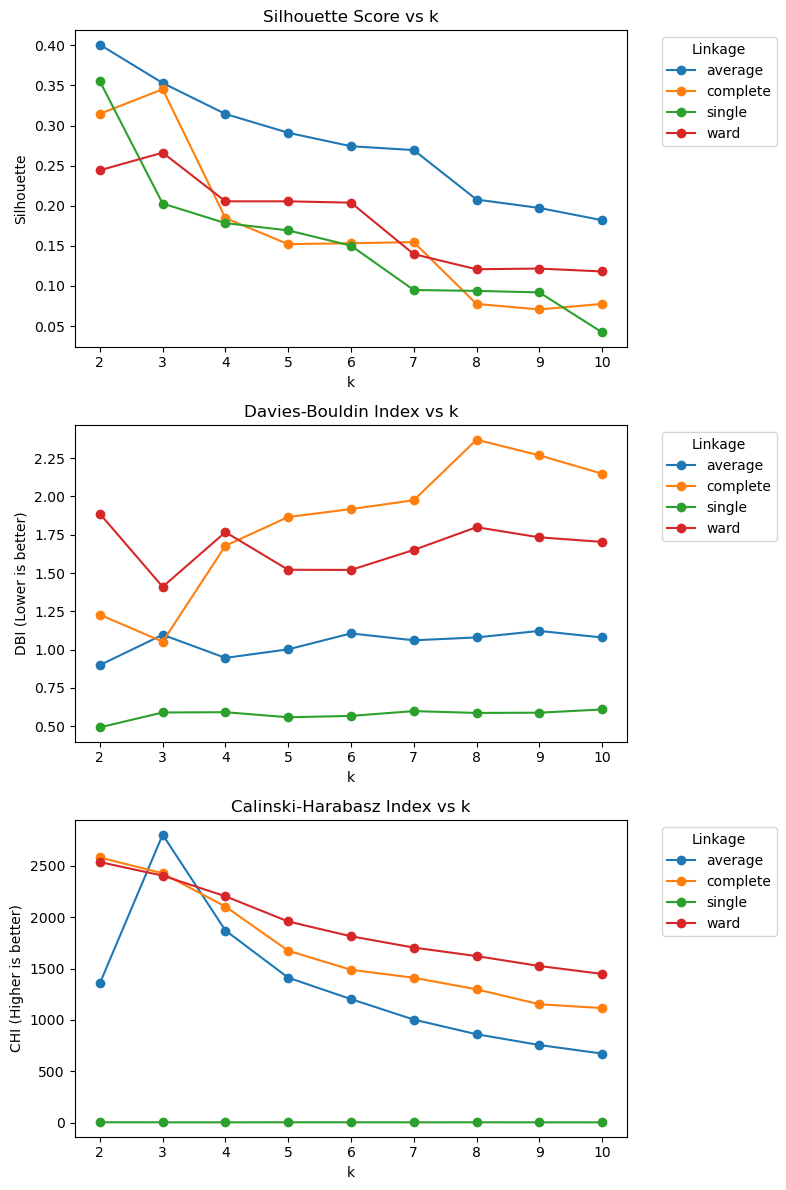

In [105]:
# Pivot data for plotting
pivot_sil = agg_results_df.pivot(index="k", columns="Linkage", values="Silhouette")
pivot_dbi = agg_results_df.pivot(index="k", columns="Linkage", values="Davies-Bouldin")
pivot_chi = agg_results_df.pivot(index="k", columns="Linkage", values="Calinski-Harabasz")

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Silhouette
pivot_sil.plot(marker="o", ax=axes[0])
axes[0].set_title("Silhouette Score vs k")
axes[0].set_ylabel("Silhouette")
axes[0].legend(title="Linkage", bbox_to_anchor=(1.05, 1), loc="upper left")

# DBI
pivot_dbi.plot(marker="o", ax=axes[1])
axes[1].set_title("Davies-Bouldin Index vs k")
axes[1].set_ylabel("DBI (Lower is better)")
axes[1].legend(title="Linkage", bbox_to_anchor=(1.05, 1), loc="upper left")

# CHI
pivot_chi.plot(marker="o", ax=axes[2])
axes[2].set_title("Calinski-Harabasz Index vs k")
axes[2].set_ylabel("CHI (Higher is better)")
axes[2].legend(title="Linkage", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [112]:
agg_results_full = run_agglomerative(data=X_sample, k=3, original_df=df_sample, 
                                interpret=True, linkage="ward")

Cluster Sizes (Agglomerative, k=3, linkage=ward):
  Cluster 0: 3160
  Cluster 1: 6441
  Cluster 2: 399

Agglomerative Results on data with shape: 10000 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.266
Davies-Bouldin Index (Lower is better)     : 1.410
Calinski-Harabasz Index (Higher is better) : 2405.2

Cluster Feature Means (k=3, linkage=ward):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            32.310         0.660         0.448   0.340             0.431   
1            47.106         0.186         0.612   0.686             0.017   
2            20.110         0.801         0.569   0.651             0.000   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.154   -14.638        0.055  109.707    0.324  
1           0.213    -6.776        0.102  123.048    0.527

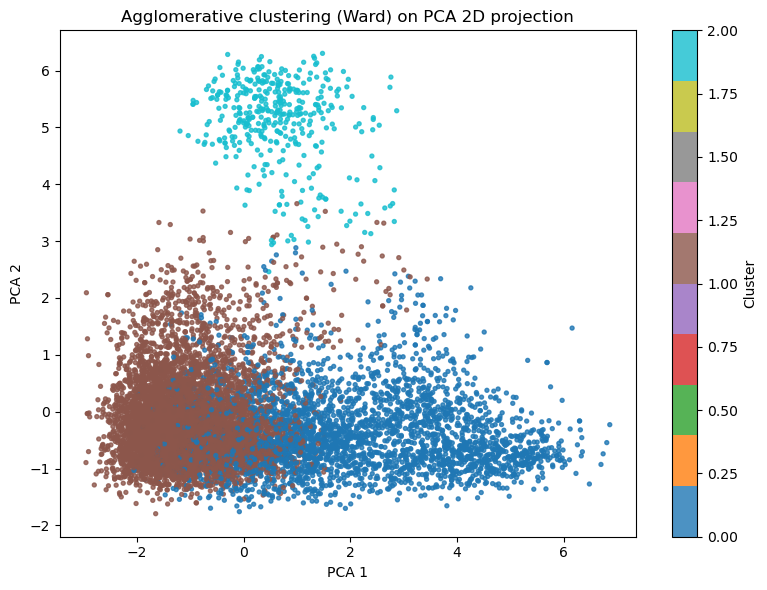

In [113]:
# PCA to 2D for visualization
pca_2d = PCA(n_components=2)
X_sample_2d = pca_2d.fit_transform(X_sample)

plot_results(X_sample_2d, agg_results_full["labels"], title="Agglomerative clustering (Ward) on PCA 2D projection")

In [141]:
agg_results_clean = run_agglomerative(data=X_sample_clean, k=3, original_df=df_sample_clean, 
                                interpret=True, linkage="ward")

Cluster Sizes (Agglomerative, k=3, linkage=ward):
  Cluster 0: 6745
  Cluster 1: 2629
  Cluster 2: 626

Agglomerative Results on data with shape: 10000 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.168
Davies-Bouldin Index (Lower is better)     : 1.872
Calinski-Harabasz Index (Higher is better) : 1313.1

Cluster Feature Means (k=3, linkage=ward):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            47.617         0.139         0.612   0.726             0.001   
1            38.338         0.566         0.548   0.416             0.001   
2            46.703         0.292         0.571   0.611             0.043   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.170    -6.020        0.076  123.759    0.553  
1           0.168   -10.138        0.047  112.927    0.421

In [106]:
linkages = ["ward", "complete", "average", "single"]

for method in linkages:
    print(f"\n=== Linkage: {method} ===")
    run_agglomerative(data=X_sample, k=3, linkage=method)


=== Linkage: ward ===
Cluster Sizes (Agglomerative, k=3, linkage=ward):
  Cluster 0: 3160
  Cluster 1: 6441
  Cluster 2: 399

Agglomerative Results on data with shape: 10000 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.266
Davies-Bouldin Index (Lower is better)     : 1.410
Calinski-Harabasz Index (Higher is better) : 2405.2

=== Linkage: complete ===
Cluster Sizes (Agglomerative, k=3, linkage=complete):
  Cluster 0: 8292
  Cluster 1: 1307
  Cluster 2: 401

Agglomerative Results on data with shape: 10000 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.345
Davies-Bouldin Index (Lower is better)     : 1.052
Calinski-Harabasz Index (Higher is better) : 2427.7

=== Linkage: average ===
Cluster Sizes (Agglomerative, k=3, linkage=average):
  Cluster 0: 7826
  Cluster 1: 412
  Cluster 2: 1762

Agglomerative Results on data with shape: 10000 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.353
Davies-Bouldin Index (Lower is bette

In [142]:
linkages = ["ward", "complete", "average", "single"]

for method in linkages:
    print(f"\n=== Linkage: {method} ===")
    run_agglomerative(data=X_sample_clean, k=3, linkage=method)


=== Linkage: ward ===
Cluster Sizes (Agglomerative, k=3, linkage=ward):
  Cluster 0: 6745
  Cluster 1: 2629
  Cluster 2: 626

Agglomerative Results on data with shape: 10000 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.168
Davies-Bouldin Index (Lower is better)     : 1.872
Calinski-Harabasz Index (Higher is better) : 1313.1

=== Linkage: complete ===
Cluster Sizes (Agglomerative, k=3, linkage=complete):
  Cluster 0: 7684
  Cluster 1: 434
  Cluster 2: 1882

Agglomerative Results on data with shape: 10000 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.193
Davies-Bouldin Index (Lower is better)     : 1.673
Calinski-Harabasz Index (Higher is better) : 1296.7

=== Linkage: average ===
Cluster Sizes (Agglomerative, k=3, linkage=average):
  Cluster 0: 9997
  Cluster 1: 2
  Cluster 2: 1

Agglomerative Results on data with shape: 10000 samples × 10 features
Silhouette Score (Range -1 to 1)           : 0.351
Davies-Bouldin Index (Lower is better)   

## PCA 2D

In [29]:
# Agglo on PCA 2D full data 
pca_2d = PCA(n_components=2)
X_sample_2d = pca_2d.fit_transform(X_sample)

# Run agglomerative clustering on PCA 2D data
agg_results_pca2 = run_agglomerative(data=X_sample_2d, k=3, original_df=df_sample, 
                                     interpret=True, linkage="ward")

Cluster Sizes (Agglomerative, k=3, linkage=ward):
  Cluster 0: 8205
  Cluster 1: 1329
  Cluster 2: 466

Agglomerative Results on data with shape: 10000 samples × 2 features
Silhouette Score (Range -1 to 1)           : 0.603
Davies-Bouldin Index (Lower is better)     : 0.493
Calinski-Harabasz Index (Higher is better) : 9908.3

Cluster Feature Means (k=3, linkage=ward):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            45.244         0.249         0.600   0.642             0.088   
1            24.658         0.898         0.304   0.147             0.563   
2            20.451         0.778         0.557   0.630             0.004   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.195    -7.524        0.091  121.802    0.508  
1           0.160   -20.636        0.050   99.632    0.169 

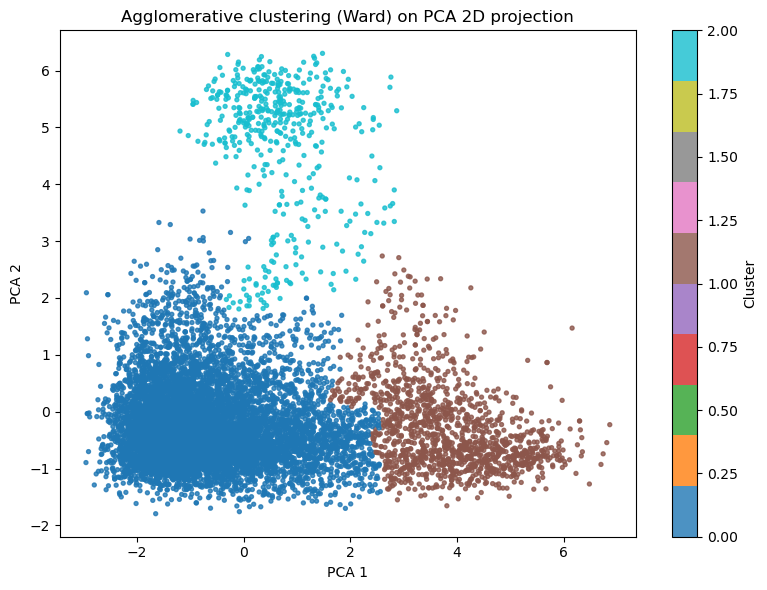

In [30]:
plot_results(X_sample_2d ,agg_results_pca2["labels"], 
             title="Agglomerative clustering (Ward) on PCA 2D projection")

## PCA 3D

In [116]:
# Agglo on PCA 3D full data 
pca_3d = PCA(n_components=3)
X_sample_3d = pca_3d.fit_transform(X_sample)

# Run agglomerative clustering on PCA 3D data
agg_results_pca3 = run_agglomerative(data=X_sample_3d, k=3, original_df=df_sample, 
                                     interpret=True, linkage="ward")

Cluster Sizes (Agglomerative, k=3, linkage=ward):
  Cluster 0: 7706
  Cluster 1: 1871
  Cluster 2: 423

Agglomerative Results on data with shape: 10000 samples × 3 features
Silhouette Score (Range -1 to 1)           : 0.504
Davies-Bouldin Index (Lower is better)     : 0.679
Calinski-Harabasz Index (Higher is better) : 6816.8

Cluster Feature Means (k=3, linkage=ward):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            45.533         0.218         0.608   0.665             0.071   
1            28.963         0.846         0.351   0.192             0.493   
2            20.009         0.791         0.574   0.642             0.000   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.203    -7.161        0.095  122.214    0.522  
1           0.152   -18.418        0.050  104.311    0.204 

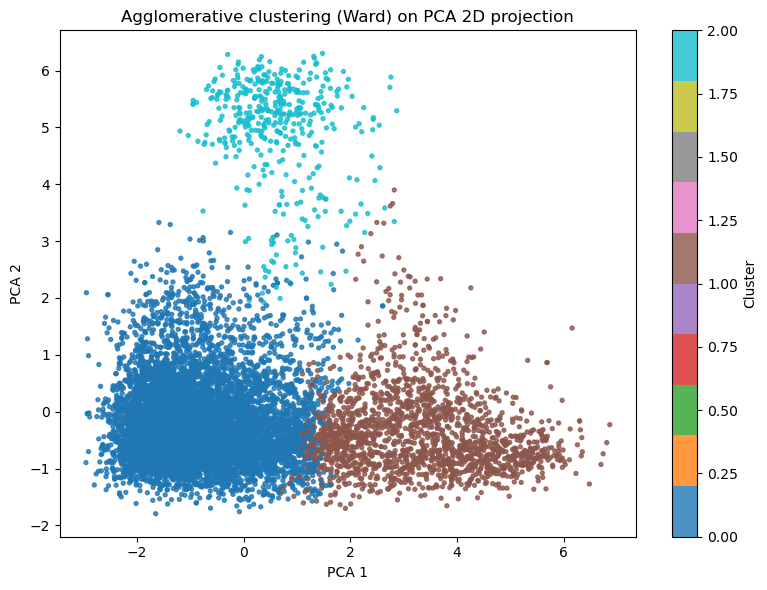

In [117]:
# PCA to 2D for visualization
pca_2d = PCA(n_components=2)
X_sample_2d_from_3d = pca_2d.fit_transform(X_sample_3d)

plot_results(X_sample_3d ,agg_results_pca3["labels"], 
             title="Agglomerative clustering (Ward) on PCA 2D projection")

## PCA 5D

In [118]:
# Agglo on PCA 5D full data 
pca_5d = PCA(n_components=5)
X_sample_5d = pca_5d.fit_transform(X_sample)

# Run agglomerative clustering on PCA 3D data
agg_results_pca5 = run_agglomerative(data=X_sample_5d, k=3, original_df=df_sample, 
                                     interpret=True, linkage="ward")

Cluster Sizes (Agglomerative, k=3, linkage=ward):
  Cluster 0: 8124
  Cluster 1: 1394
  Cluster 2: 482

Agglomerative Results on data with shape: 10000 samples × 5 features
Silhouette Score (Range -1 to 1)           : 0.417
Davies-Bouldin Index (Lower is better)     : 0.854
Calinski-Harabasz Index (Higher is better) : 3822.2

Cluster Feature Means (k=3, linkage=ward):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            45.424         0.246         0.601   0.644             0.079   
1            24.618         0.876         0.316   0.165             0.595   
2            21.141         0.785         0.546   0.615             0.003   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.195    -7.484        0.092  121.372    0.509  
1           0.155   -20.191        0.051  102.676    0.182 

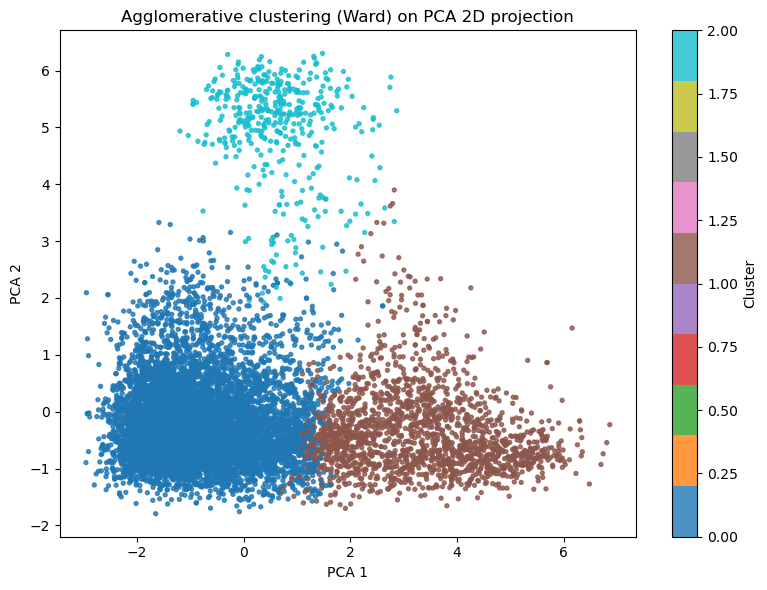

In [119]:
# PCA to 2D for visualization
pca_2d = PCA(n_components=2)
X_sample_2d_from_5d = pca_2d.fit_transform(X_sample_5d)

plot_results(X_sample_5d ,agg_results_pca3["labels"], 
             title="Agglomerative clustering (Ward) on PCA 2D projection")

## PCA 7D

In [120]:
# Agglo on PCA 7D full data 
pca_7d = PCA(n_components=7)
X_sample_7d = pca_7d.fit_transform(X_sample)

# Run agglomerative clustering on PCA 3D data
agg_results_pca7 = run_agglomerative(data=X_sample_7d, k=3, original_df=df_sample, 
                                     interpret=True, linkage="ward")

Cluster Sizes (Agglomerative, k=3, linkage=ward):
  Cluster 0: 8224
  Cluster 1: 1346
  Cluster 2: 430

Agglomerative Results on data with shape: 10000 samples × 7 features
Silhouette Score (Range -1 to 1)           : 0.387
Davies-Bouldin Index (Lower is better)     : 0.945
Calinski-Harabasz Index (Higher is better) : 3025.6

Cluster Feature Means (k=3, linkage=ward):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            45.155         0.252         0.599   0.640             0.079   
1            25.134         0.879         0.305   0.168             0.607   
2            19.412         0.794         0.574   0.630             0.000   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.200    -7.590        0.092  121.276    0.507  
1           0.152   -20.075        0.047  102.807    0.174 

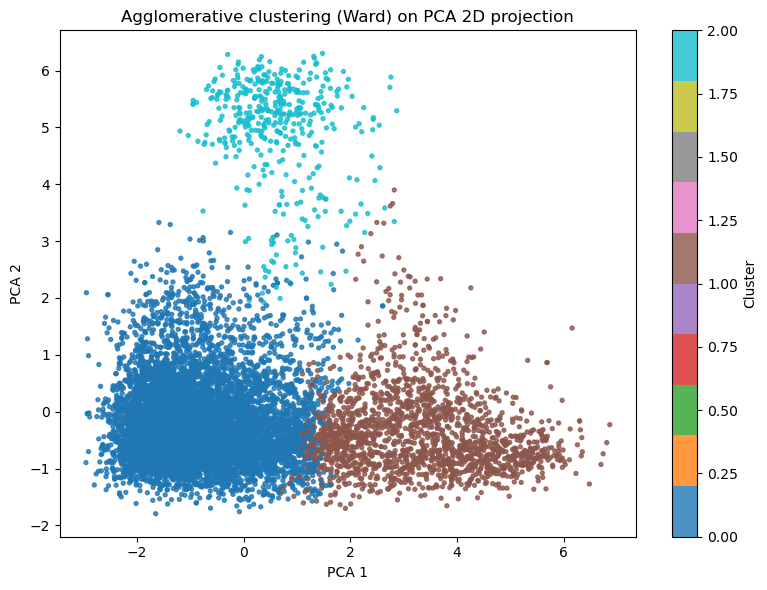

In [121]:
# PCA to 2D for visualization
pca_2d = PCA(n_components=2)
X_sample_2d_from_7d = pca_2d.fit_transform(X_sample_7d)

plot_results(X_sample_7d ,agg_results_pca3["labels"], 
             title="Agglomerative clustering (Ward) on PCA 2D projection")

In [135]:
agg_rows = []

for linkage_method in linkages:
    for dim in pca_dimensions + [X_sample.shape[1]]:
        if dim == X_sample.shape[1]:  # Full data
            X_use = X_sample
        else:  # PCA data
            X_use = PCA(n_components=dim, random_state=42).fit_transform(X_sample)
        
        agg = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
        labels = agg.fit_predict(X_use)

        agg_rows.append({
            "Linkage": linkage_method,
            "PCA_Dim": dim,
            "Silhouette": silhouette_score(X_use, labels),
            "DBI": davies_bouldin_score(X_use, labels),
            "CHI": calinski_harabasz_score(X_use, labels)
        })

# Convert to DataFrame
agg_results_df = pd.DataFrame(agg_rows)

In [136]:
agg_results_df.to_csv("agglo_results_spo.csv")

In [78]:
agg_results_df = pd.read_csv("agglo_results_spo.csv", index_col=0)
agg_results_df 

Linkage  PCA_Dim  Silhouette       DBI           CHI
0       ward        2    0.603072  0.492740   9908.316694
1       ward        3    0.503949  0.679197   6816.765594
2       ward        4    0.456168  0.722787   4365.740137
3       ward        5    0.417413  0.854121   3822.193519
4       ward        6    0.401230  0.910724   3270.786532
5       ward        7    0.387355  0.945345   3025.648295
6       ward       10    0.266201  1.410164   2405.226102
7   complete        2    0.513579  0.776116   6363.814169
8   complete        3    0.505090  0.636268   5388.094733
9   complete        4    0.386833  0.996277   4003.492749
10  complete        5    0.373542  0.945072   3507.461400
11  complete        6    0.325649  1.396924   2335.917245
12  complete        7    0.387758  0.884241   2738.362398
13  complete       10    0.345364  1.051552   2427.670747
14   average        2    0.608093  0.482723  10009.488422
15   average        3    0.497990  0.642888   5408.760430
16   average        4    0.455219  0.749097   4526.926013
17   average        5    0.379389  0.949662   3822.205981
18   average        6    0.399045  0.934218   3451.706008
19   average        7    0.389053  0.929416   3069.892196
20   average       10    0.353104  1.096792   2803.753702
21    single        2    0.428741  0.357736      6.143090
22    single        3    0.410443  0.381053      5.680882
23    single        4    0.365225  0.421150      4.946160
24    single        5    0.337559  0.448379      4.580935
25    single        6    0.323039  0.463243      4.307197
26    single        7    0.241884  0.537495      3.718168
27    single       10    0.202763  0.589280      2.891713

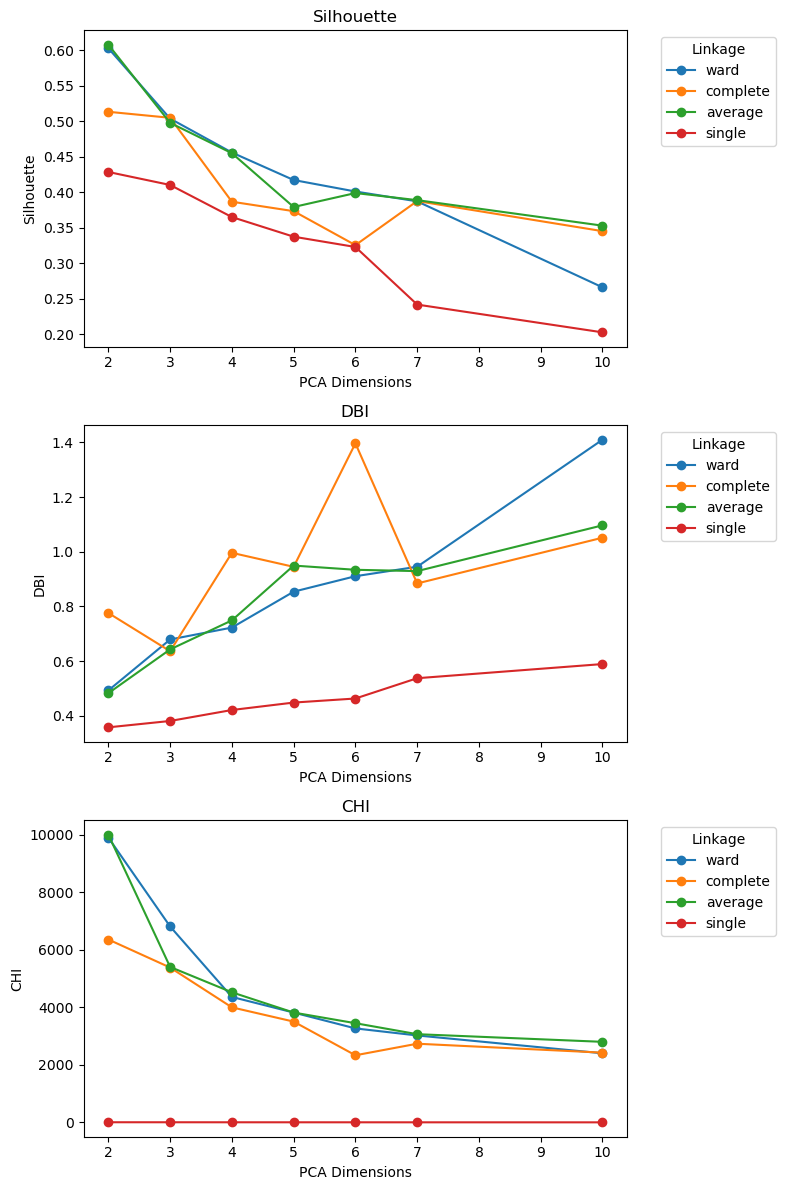

In [139]:
metrics = ["Silhouette", "DBI", "CHI"]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

for i, metric in enumerate(metrics):
    for linkage_method in agg_results_df["Linkage"].unique():
        subset = agg_results_df[agg_results_df["Linkage"] == linkage_method]
        axes[i].plot(
            subset["PCA_Dim"], 
            subset[metric], 
            marker="o", 
            label=linkage_method
        )
    
    axes[i].set_title(metric)
    axes[i].set_xlabel("PCA Dimensions")
    axes[i].set_ylabel(metric)
    axes[i].legend(title="Linkage", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [123]:
# Store results
silhouette_scores_agg = {}
dbi_scores_agg = {}
chi_scores_agg = {}

k_values = list(range(2, 11))

# Full (resampled) data
sil_vals, dbi_vals, chi_vals = [], [], []
for k in k_values:
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = model.fit_predict(X_sample)
    sil_vals.append(silhouette_score(X_sample, labels))
    dbi_vals.append(davies_bouldin_score(X_sample, labels))
    chi_vals.append(calinski_harabasz_score(X_sample, labels))
silhouette_scores_agg["Full_10D"] = sil_vals
dbi_scores_agg["Full_10D"] = dbi_vals
chi_scores_agg["Full_10D"] = chi_vals

# PCA 2..7 on resampled data
for d in [2, 3, 4, 5, 6, 7]:
    X_pca = PCA(n_components=d, random_state=42).fit_transform(X_sample)
    sil_vals, dbi_vals, chi_vals = [], [], []
    for k in k_values:
        model = AgglomerativeClustering(n_clusters=k, linkage="ward")
        labels = model.fit_predict(X_pca)
        sil_vals.append(silhouette_score(X_pca, labels))
        dbi_vals.append(davies_bouldin_score(X_pca, labels))
        chi_vals.append(calinski_harabasz_score(X_pca, labels))
    silhouette_scores_agg[f"PCA_{d}D"] = sil_vals
    dbi_scores_agg[f"PCA_{d}D"] = dbi_vals
    chi_scores_agg[f"PCA_{d}D"] = chi_vals

# DataFrames
agg_spo_sil_df = pd.DataFrame(silhouette_scores_agg, index=k_values)
agg_spo_dbi_df = pd.DataFrame(dbi_scores_agg,        index=k_values)
agg_spo_chi_df = pd.DataFrame(chi_scores_agg,        index=k_values)

In [124]:
# Save results
agg_spo_sil_df.to_csv("agg_spo_silhouette.csv")
agg_spo_dbi_df.to_csv("agg_spo_dbi.csv")
agg_spo_chi_df.to_csv("agg_spo_chi.csv")

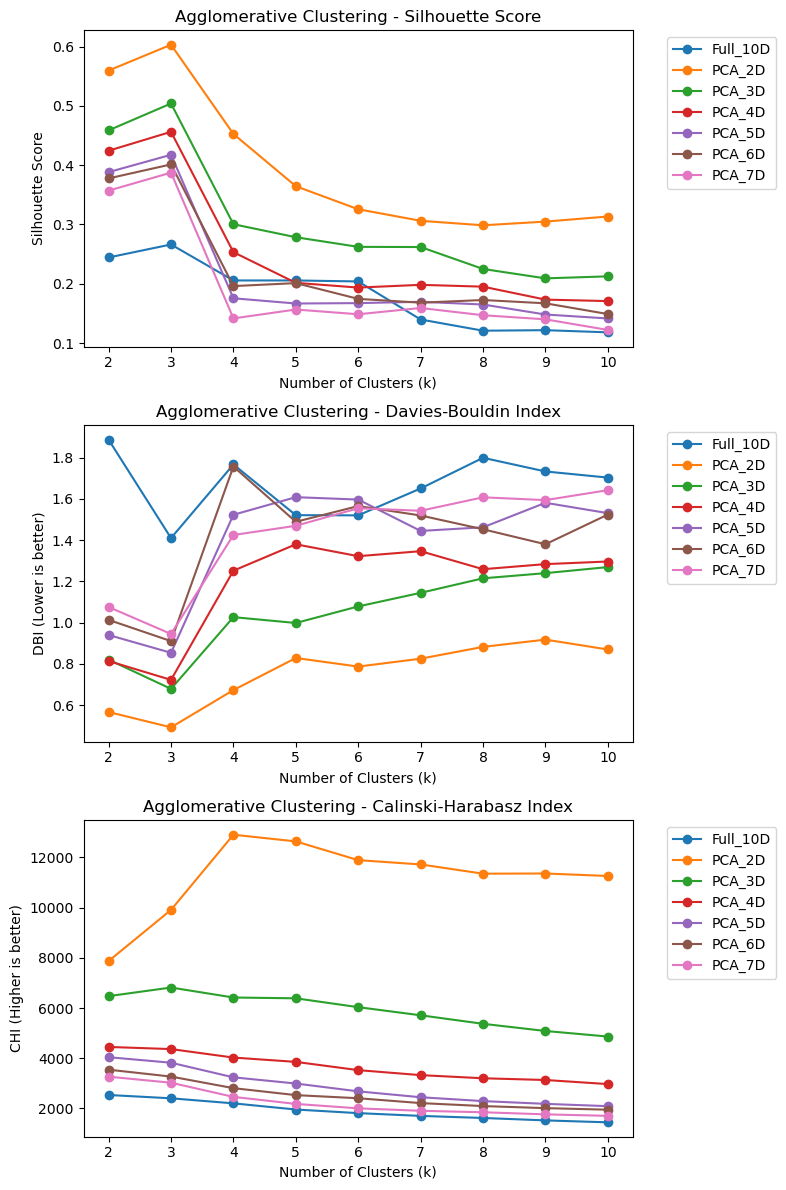

In [125]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Silhouette
for col in agg_spo_sil_df.columns:
    axes[0].plot(agg_spo_sil_df.index, agg_spo_sil_df[col], marker='o', label=col)
axes[0].set_title("Agglomerative Clustering - Silhouette Score")
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Silhouette Score")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# DBI
for col in agg_spo_dbi_df.columns:
    axes[1].plot(agg_spo_dbi_df.index, agg_spo_dbi_df[col], marker='o', label=col)
axes[1].set_title("Agglomerative Clustering - Davies-Bouldin Index")
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].set_ylabel("DBI (Lower is better)")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# CHI
for col in agg_spo_chi_df.columns:
    axes[2].plot(agg_spo_chi_df.index, agg_spo_chi_df[col], marker='o', label=col)
axes[2].set_title("Agglomerative Clustering - Calinski-Harabasz Index")
axes[2].set_xlabel("Number of Clusters (k)")
axes[2].set_ylabel("CHI (Higher is better)")
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# GMM

In [23]:
n_components_range = range(2, 15)
gmm_covariance_types = ['full', 'tied', 'diag', 'spherical']

# Store results in a dictionary
bic_results = {}
aic_results = {}

for cov in gmm_covariance_types:
    bic_scores = []
    aic_scores = []
    for k in n_components_range:
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
        gmm.fit(X_scaled)
        bic_scores.append(gmm.bic(X_scaled))
        aic_scores.append(gmm.aic(X_scaled))
    bic_results[cov] = bic_scores
    aic_results[cov] = aic_scores


In [28]:
gmm_bic_aic_spo_df = pd.DataFrame([
    {"Covariance_Type": cov, 
     "n_components": k, 
     "BIC": bic_results[cov][i], 
     "AIC": aic_results[cov][i]}
    for cov in gmm_covariance_types
    for i, k in enumerate(n_components_range)
])

# Save to CSV
results_path = "gmm_bic_aic_spo_results.csv"
gmm_bic_aic_spo_df.to_csv(results_path, index=False)

print(f"Results saved to {results_path}")

Results saved to gmm_bic_aic_spo_results.csv


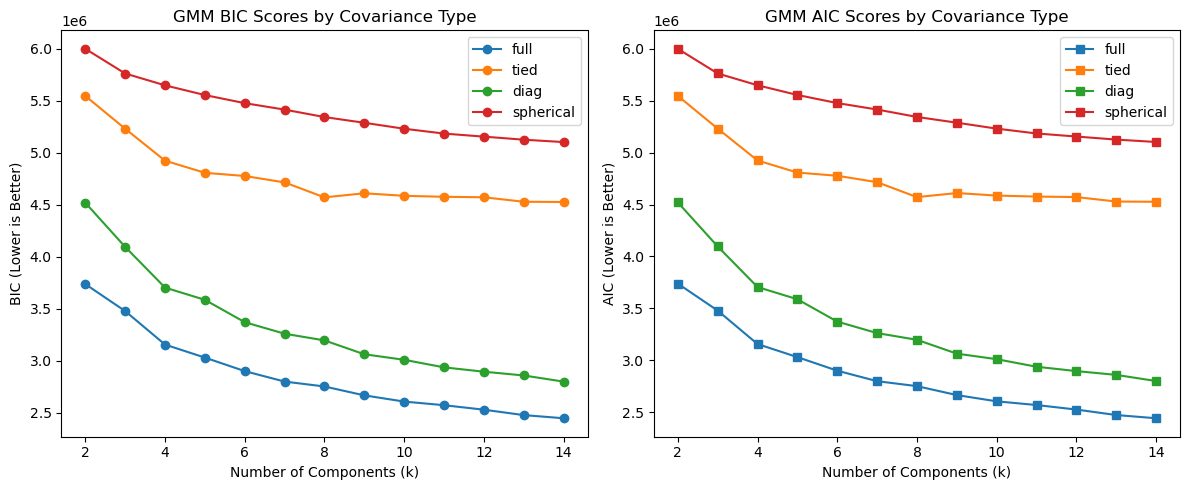

In [30]:
plt.figure(figsize=(12, 5))

# --- BIC Plot ---
plt.subplot(1, 2, 1)
for cov in gmm_covariance_types:
    plt.plot(n_components_range, bic_results[cov], marker='o', label=cov)
plt.title("GMM BIC Scores by Covariance Type")
plt.xlabel("Number of Components (k)")
plt.ylabel("BIC (Lower is Better)")
plt.legend()

# --- AIC Plot ---
plt.subplot(1, 2, 2)
for cov in gmm_covariance_types:
    plt.plot(n_components_range, aic_results[cov], marker='s', label=cov)
plt.title("GMM AIC Scores by Covariance Type")
plt.xlabel("Number of Components (k)")
plt.ylabel("AIC (Lower is Better)")
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
n_components_range = range(2, 15)
gmm_covariance_types = ['full', 'tied', 'diag', 'spherical']

# Store GMM results
# Initialize result storage
sil_GMM_results = {}
dbi_GMM_results = {}
chi_GMM_results = {}

for cov in gmm_covariance_types:
    print(f"\n Running GMM evaluation for covariance_type = '{cov}'...")
    
    sil_scores = []
    dbi_scores = []
    chi_scores = []
    
    for k in n_components_range:
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
        labels = gmm.fit_predict(X_scaled)

        sil = silhouette_score(X_scaled, labels)
        dbi = davies_bouldin_score(X_scaled, labels)
        chi = calinski_harabasz_score(X_scaled, labels)

        sil_scores.append(sil)
        dbi_scores.append(dbi)
        chi_scores.append(chi)

        print(f"  k = {k:2d} | Sil: {sil:.3f} | DBI: {dbi:.3f} | CHI: {chi:.1f}")
    
    # Save for later use
    sil_GMM_results[cov] = sil_scores
    dbi_GMM_results[cov] = dbi_scores
    chi_GMM_results[cov] = chi_scores

    print(f"Finished '{cov}' covariance type.")


 Running GMM evaluation for covariance_type = 'full'...
  k =  2 | Sil: 0.118 | DBI: 2.741 | CHI: 26876.3
  k =  3 | Sil: 0.065 | DBI: 4.013 | CHI: 19449.4
  k =  4 | Sil: 0.055 | DBI: 3.108 | CHI: 27547.5
  k =  5 | Sil: 0.044 | DBI: 3.544 | CHI: 20684.2
  k =  6 | Sil: -0.003 | DBI: 3.499 | CHI: 17457.5
  k =  7 | Sil: -0.001 | DBI: 3.542 | CHI: 16421.8
  k =  8 | Sil: -0.019 | DBI: 3.586 | CHI: 17680.0
  k =  9 | Sil: -0.014 | DBI: 3.455 | CHI: 17056.0
  k = 10 | Sil: -0.010 | DBI: 4.872 | CHI: 18328.8
  k = 11 | Sil: -0.005 | DBI: 4.249 | CHI: 17420.9
  k = 12 | Sil: -0.016 | DBI: 5.326 | CHI: 16366.4
  k = 13 | Sil: -0.009 | DBI: 4.044 | CHI: 15829.2
  k = 14 | Sil: -0.012 | DBI: 4.614 | CHI: 14989.0
Finished 'full' covariance type.

 Running GMM evaluation for covariance_type = 'tied'...
  k =  2 | Sil: 0.233 | DBI: 1.704 | CHI: 61857.2
  k =  3 | Sil: 0.265 | DBI: 1.383 | CHI: 57681.8
  k =  4 | Sil: 0.222 | DBI: 1.609 | CHI: 50439.1
  k =  5 | Sil: 0.211 | DBI: 1.521 | CHI: 45

In [20]:
# Combine all scores into a single DataFrame
gmm_eval_spo_df = pd.DataFrame([
    {
        "Covariance_Type": cov,
        "n_components": k,
        "Silhouette": sil_GMM_results[cov][i],
        "DBI": dbi_GMM_results[cov][i],
        "CHI": chi_GMM_results[cov][i]
    }
    for cov in gmm_covariance_types
    for i, k in enumerate(n_components_range)
])

# Save to CSV
results_path = "gmm_eval_spo_results.csv"
gmm_eval_spo_df.to_csv(results_path, index=False)

print(f"GMM evaluation results saved to '{results_path}'")

GMM evaluation results saved to 'gmm_eval_spo_results.csv'


In [66]:
df = pd.read_csv("gmm_eval_spo_results.csv")
df = df[(df["n_components"] >= 2) & (df["n_components"] <= 10)]

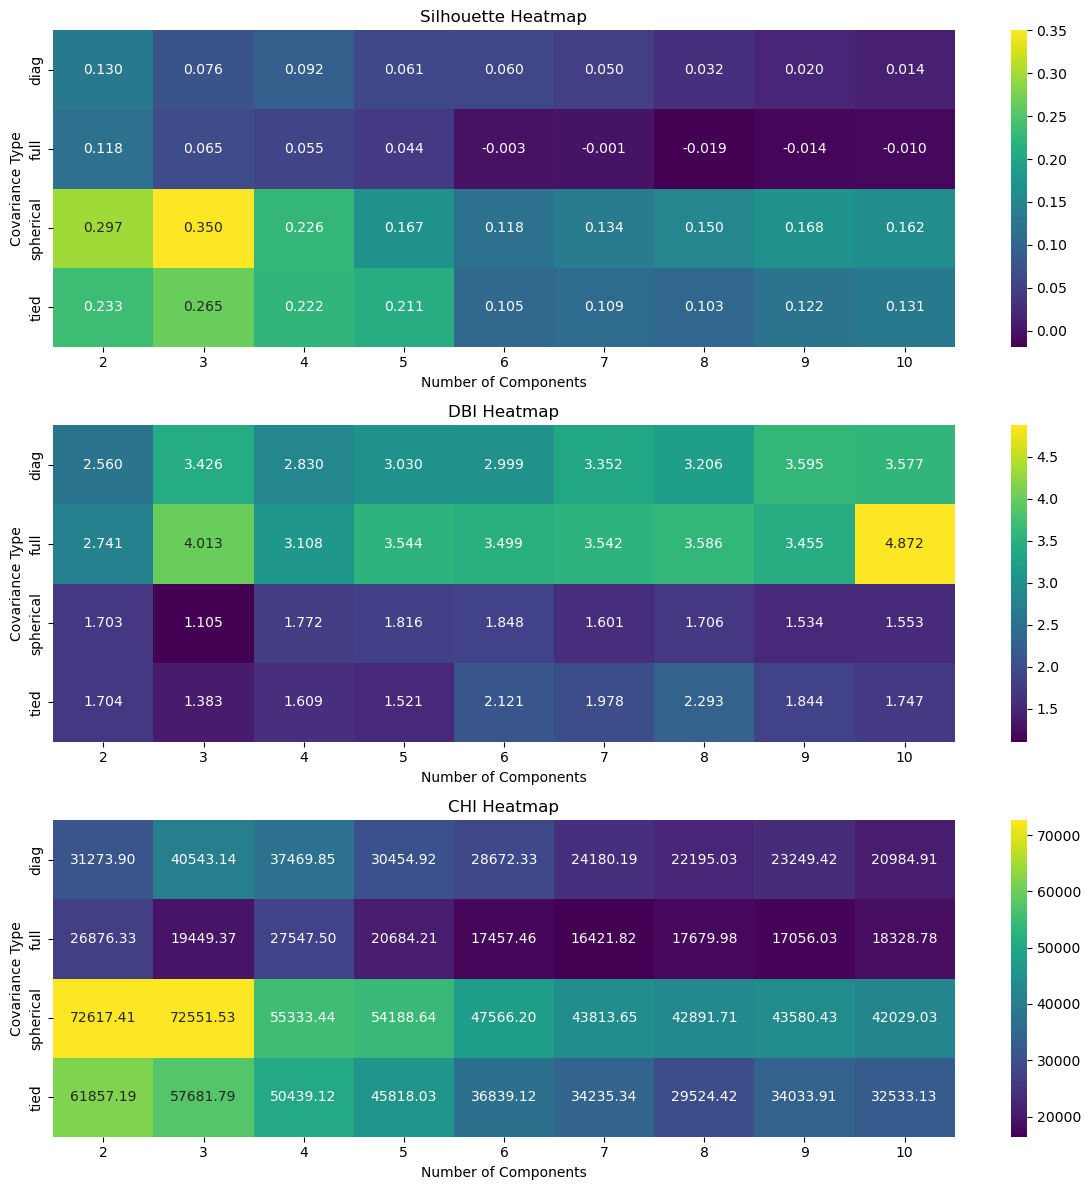

In [76]:
metrics = ["Silhouette", "DBI", "CHI"]
k_order = list(range(2, 11))
cov_order = sorted(df["Covariance_Type"].unique())

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

for ax, metric in zip(axes, metrics):
    pivot_df = (
        df.pivot(index="Covariance_Type", columns="n_components", values=metric)
          .reindex(index=cov_order, columns=k_order)
    )

    fmt = ".2f" if metric == "CHI" else ".3f"

    sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="viridis", ax=ax, cbar=True)

    ax.set_title(f"{metric} Heatmap")
    ax.set_xlabel("Number of Components")
    ax.set_ylabel("Covariance Type")

plt.tight_layout()
plt.show()

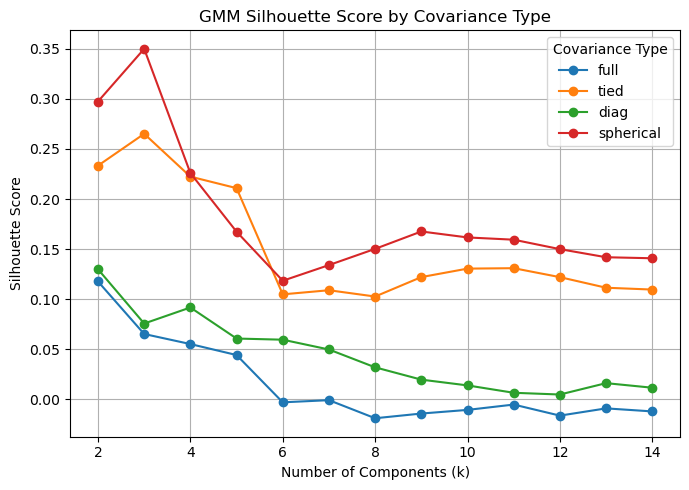

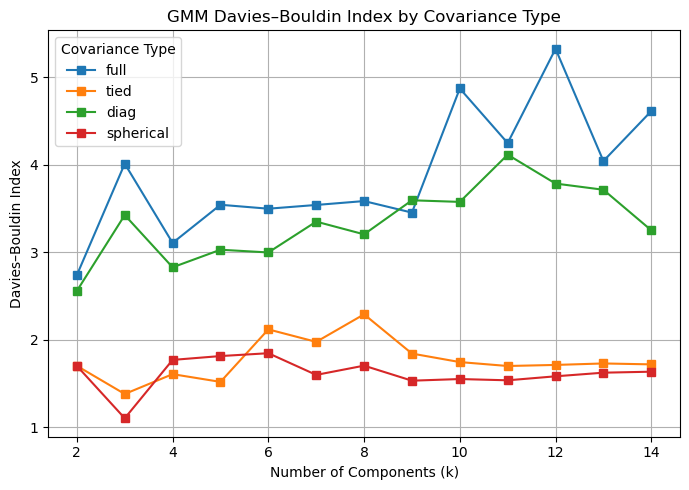

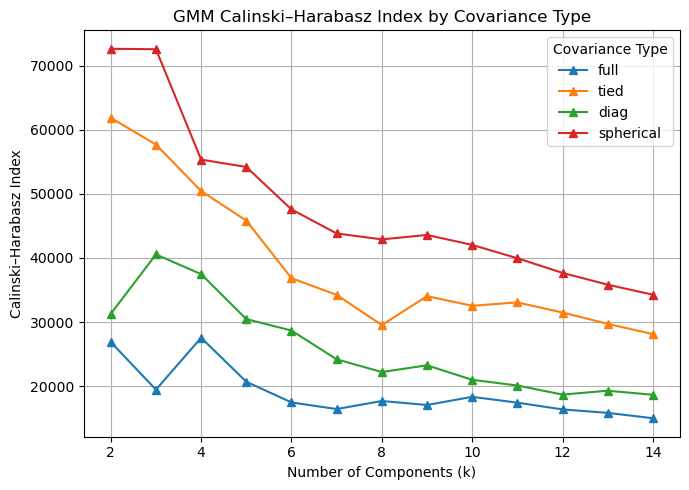

In [23]:
# Plot Silhouette Score
plt.figure(figsize=(7, 5))
for cov in gmm_covariance_types:
    plt.plot(n_components_range, sil_GMM_results[cov], marker='o', label=cov)
plt.title('GMM Silhouette Score by Covariance Type')
plt.xlabel('Number of Components (k)')
plt.ylabel('Silhouette Score')
plt.legend(title='Covariance Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Davies-Bouldin Index 
plt.figure(figsize=(7, 5))
for cov in gmm_covariance_types:
    plt.plot(n_components_range, dbi_GMM_results[cov], marker='s', label=cov)
plt.title('GMM Davies–Bouldin Index by Covariance Type')
plt.xlabel('Number of Components (k)')
plt.ylabel('Davies–Bouldin Index')
plt.legend(title='Covariance Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Calinski–Harabasz Index
plt.figure(figsize=(7, 5))
for cov in gmm_covariance_types:
    plt.plot(n_components_range, chi_GMM_results[cov], marker='^', label=cov)
plt.title('GMM Calinski–Harabasz Index by Covariance Type')
plt.xlabel('Number of Components (k)')
plt.ylabel('Calinski–Harabasz Index')
plt.legend(title='Covariance Type')
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
def run_gmm(data, n_components=3, covariance_type="full", original_df=None, interpret=False):
    start_time = time.time()
    
    # Fit model
    model = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
    labels = model.fit_predict(data)
    elapsed = time.time() - start_time

    # Cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    print(f"Cluster Sizes (GMM, n_components={n_components}, covariance_type={covariance_type}):")
    for cid, size in cluster_sizes.items():
        print(f"  Cluster {cid}: {size}")

    # Validation metrics
    sil = silhouette_score(data, labels)
    dbi = davies_bouldin_score(data, labels)
    chi = calinski_harabasz_score(data, labels)

    n_samples, n_features = data.shape
    print(f"\nGMM Results on data with shape: {n_samples} samples × {n_features} features")
    print(f"Time taken                               : {elapsed:.2f} sec")
    print(f"Silhouette Score (Range -1 to 1)         : {sil:.3f}")
    print(f"Davies-Bouldin Index (Lower is better)   : {dbi:.3f}")
    print(f"Calinski-Harabasz Index (Higher is better): {chi:.1f}")

    # Optional cluster means from original_df
    cluster_means = None
    if original_df is not None:
        df_temp = original_df.copy()
        df_temp["cluster"] = labels
        cluster_means = df_temp.groupby("cluster").mean()
        if interpret:
            print(f"\nCluster Feature Means (n_components={n_components}, covariance_type={covariance_type}):\n")
            print(cluster_means.round(3))

    return {
        "labels": labels,
        "model": model,
        "cluster_sizes": cluster_sizes,
        "silhouette": sil,
        "dbi": dbi,
        "chi": chi,
        "time_sec": elapsed,
        "cluster_means": cluster_means
    }

## FUll data

In [147]:
gmm_covariance_types = ['full', 'tied', 'diag', 'spherical']

for cov_type in gmm_covariance_types:
    print(f"\n=== Covariance Type: {cov_type} ===")
    run_gmm(data=X_scaled, n_components=3, covariance_type=cov_type)


=== Covariance Type: full ===
Cluster Sizes (GMM, n_components=3, covariance_type=full):
  Cluster 0: 31935
  Cluster 1: 146228
  Cluster 2: 54562

GMM Results on data with shape: 232725 samples × 10 features
Time taken                               : 7.79 sec
Silhouette Score (Range -1 to 1)         : 0.065
Davies-Bouldin Index (Lower is better)   : 4.013
Calinski-Harabasz Index (Higher is better): 19449.4

=== Covariance Type: tied ===
Cluster Sizes (GMM, n_components=3, covariance_type=tied):
  Cluster 0: 151059
  Cluster 1: 10006
  Cluster 2: 71660

GMM Results on data with shape: 232725 samples × 10 features
Time taken                               : 3.96 sec
Silhouette Score (Range -1 to 1)         : 0.265
Davies-Bouldin Index (Lower is better)   : 1.383
Calinski-Harabasz Index (Higher is better): 57681.8

=== Covariance Type: diag ===
Cluster Sizes (GMM, n_components=3, covariance_type=diag):
  Cluster 0: 51344
  Cluster 1: 142648
  Cluster 2: 38733

GMM Results on data with sh

In [145]:
# GMM on full data
gmm_full = run_gmm(X_scaled, n_components=3, covariance_type="full",
                           original_df=df, interpret=True)

Cluster Sizes (GMM, n_components=3, covariance_type=full):
  Cluster 0: 31935
  Cluster 1: 146228
  Cluster 2: 54562

GMM Results on data with shape: 232725 samples × 10 features
Time taken                               : 8.21 sec
Silhouette Score (Range -1 to 1)         : 0.065
Davies-Bouldin Index (Lower is better)   : 4.013
Calinski-Harabasz Index (Higher is better): 19449.4

Cluster Feature Means (n_components=3, covariance_type=full):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            38.202         0.303         0.540   0.622             0.297   
1            43.786         0.301         0.602   0.636             0.000   
2            35.715         0.589         0.436   0.367             0.458   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.291    -9.514        0.098  121.7

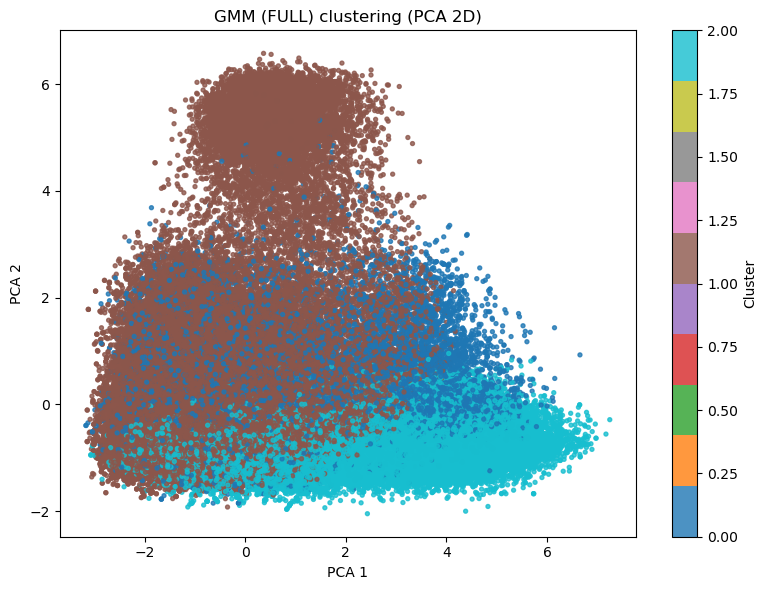

In [146]:
# PCA 2D for visualisation
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled) 

plot_results(X_2d, gmm_full['labels'], title="GMM (FULL) clustering (PCA 2D)")

In [148]:
# GMM on full cleaned data
gmm_full_clean = run_gmm(X_scaled_clean, n_components=3, covariance_type="full",
                           original_df=df_clean, interpret=True)

Cluster Sizes (GMM, n_components=3, covariance_type=full):
  Cluster 0: 85981
  Cluster 1: 23223
  Cluster 2: 28207

GMM Results on data with shape: 137411 samples × 10 features
Time taken                               : 4.35 sec
Silhouette Score (Range -1 to 1)         : -0.002
Davies-Bouldin Index (Lower is better)   : 5.572
Calinski-Harabasz Index (Higher is better): 3512.4

Cluster Feature Means (n_components=3, covariance_type=full):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            45.935         0.249         0.607   0.646             0.000   
1            43.936         0.314         0.563   0.597             0.001   
2            44.100         0.269         0.574   0.632             0.018   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.171    -6.788        0.072  121.16

## PCA2D

In [149]:
# GMM on full 2D data
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

gmm_2d_full = run_gmm(X_2d, n_components=3, covariance_type="full",
                           original_df=df, interpret=True)

Cluster Sizes (GMM, n_components=3, covariance_type=full):
  Cluster 0: 155806
  Cluster 1: 55784
  Cluster 2: 21135

GMM Results on data with shape: 232725 samples × 2 features
Time taken                               : 3.26 sec
Silhouette Score (Range -1 to 1)         : 0.560
Davies-Bouldin Index (Lower is better)   : 0.771
Calinski-Harabasz Index (Higher is better): 258074.8

Cluster Feature Means (n_components=3, covariance_type=full):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            46.858         0.183         0.616   0.687             0.061   
1            31.180         0.792         0.384   0.230             0.437   
2            25.138         0.618         0.549   0.614             0.028   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.178    -6.756        0.094  123.0

In [32]:
# GMM on full 2D data spherical covariance
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

gmm_2d_spherical = run_gmm(X_2d, n_components=3, covariance_type="spherical",
                           original_df=df, interpret=True)

Cluster Sizes (GMM, n_components=3, covariance_type=spherical):
  Cluster 0: 171563
  Cluster 1: 50966
  Cluster 2: 10196

GMM Results on data with shape: 232725 samples × 2 features
Time taken                               : 0.97 sec
Silhouette Score (Range -1 to 1)         : 0.601
Davies-Bouldin Index (Lower is better)   : 0.541
Calinski-Harabasz Index (Higher is better): 289119.0

Cluster Feature Means (n_components=3, covariance_type=spherical):

         popularity  acousticness  danceability  energy  instrumentalness  \
cluster                                                                     
0            45.980         0.207         0.611   0.673             0.065   
1            28.912         0.828         0.362   0.207             0.457   
2            20.541         0.788         0.561   0.667             0.001   

         liveness  loudness  speechiness    tempo  valence  
cluster                                                     
0           0.197    -6.986        0.

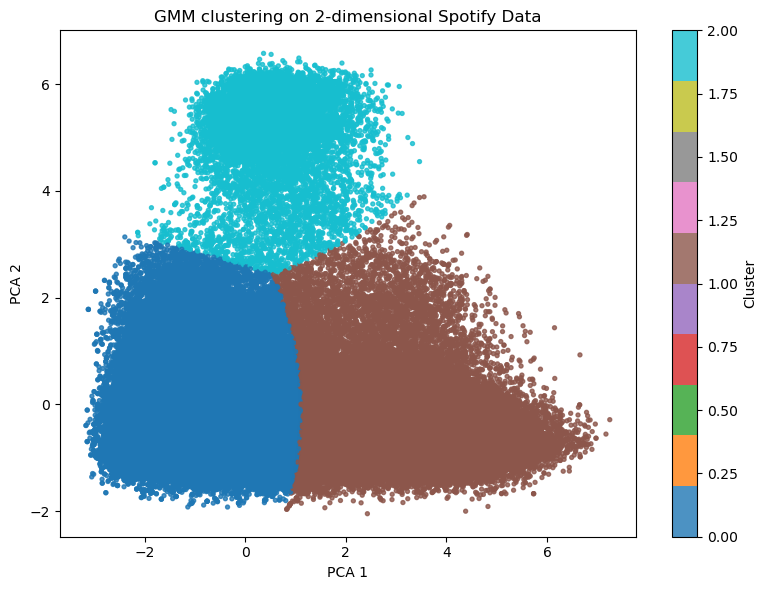

In [33]:
plot_results(X_2d, gmm_2d_spherical['labels'], title="GMM clustering on 2-dimensional Spotify Data")

In [150]:
# Store results in a list of dicts
gmm_results_list = []

pca_dimensions = [2, 3, 4, 5, 6, 7]
cov_types = ['full', 'tied', 'diag', 'spherical']

for cov in cov_types:
    for dim in pca_dimensions:
        X_pca = PCA(n_components=dim, random_state=42).fit_transform(X_scaled)
        
        gmm = GaussianMixture(n_components=3, covariance_type=cov, random_state=42)
        labels = gmm.fit_predict(X_pca)
        
        gmm_results_list.append({
            "Covariance_Type": cov,
            "PCA_Dim": dim,
            "Silhouette": silhouette_score(X_pca, labels),
            "DBI": davies_bouldin_score(X_pca, labels),
            "CHI": calinski_harabasz_score(X_pca, labels)
        })
    
    # Full data (no PCA)
    gmm_full = GaussianMixture(n_components=3, covariance_type=cov, random_state=42)
    labels_full = gmm_full.fit_predict(X_scaled)
    
    gmm_results_list.append({
        "Covariance_Type": cov,
        "PCA_Dim": X_scaled.shape[1],
        "Silhouette": silhouette_score(X_scaled, labels_full),
        "DBI": davies_bouldin_score(X_scaled, labels_full),
        "CHI": calinski_harabasz_score(X_scaled, labels_full)
    })

# Convert to DataFrame
gmm_results_df = pd.DataFrame(gmm_results_list)

In [152]:
gmm_results_df.to_csv("gmm_results_spo.csv", index=False)

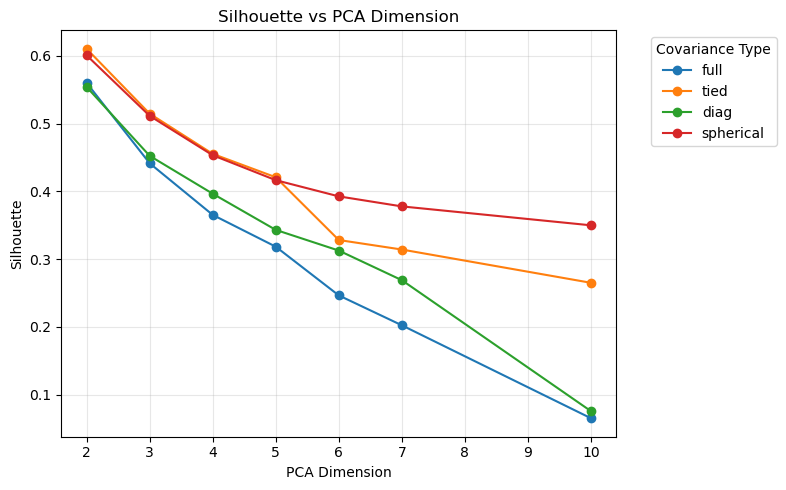

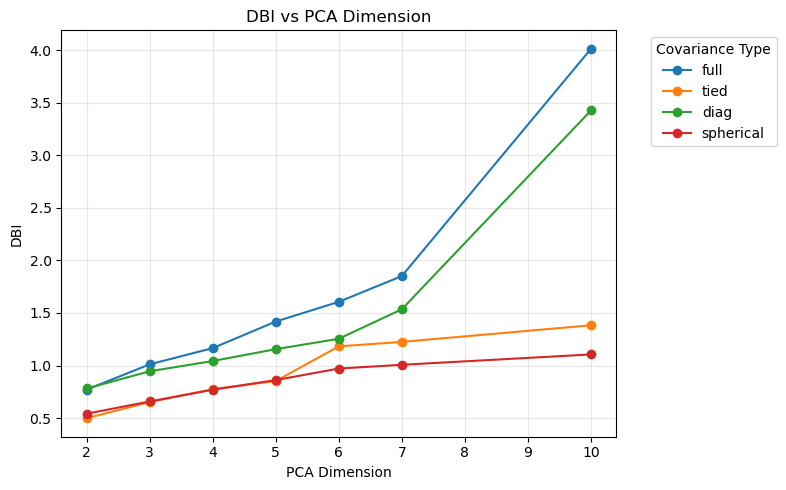

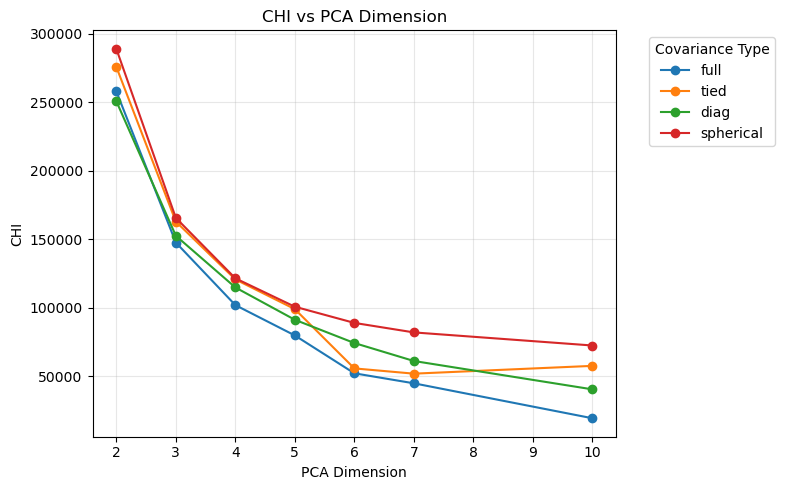

In [160]:
metrics = ["Silhouette", "DBI", "CHI"]

for metric in metrics:
    plt.figure(figsize=(8, 5))
    for cov in gmm_results_df["Covariance_Type"].unique():
        subset = (gmm_results_df[gmm_results_df["Covariance_Type"] == cov]
                  .sort_values("PCA_Dim"))
        plt.plot(subset["PCA_Dim"], subset[metric], marker='o', label=cov)
    plt.title(f"{metric} vs PCA Dimension")
    plt.xlabel("PCA Dimension")
    plt.ylabel(metric)
    plt.legend(title="Covariance Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [34]:
kmeans_2d

{'labels': array([0, 0, 1, ..., 0, 0, 0]),
 'model': KMeans(n_clusters=3, n_init='auto', random_state=42),
 'cluster_sizes': {0: 170296, 1: 50900, 2: 11529},
 'silhouette': 0.6001142813310759,
 'dbi': 0.5539375897991791,
 'chi': 292538.39441718766,
 'cluster_means':          popularity  acousticness  danceability    energy  instrumentalness  \
 cluster                                                                       
 0         46.041410      0.205225      0.611553  0.674311          0.065234   
 1         29.261886      0.826042      0.362670  0.206978          0.458735   
 2         20.929829      0.761442      0.555942  0.651275          0.004739   
 
          liveness   loudness  speechiness       tempo   valence  
 cluster                                                          
 0        0.195696  -6.967968     0.096296  122.432154  0.528020  
 1        0.161162 -17.770624     0.050540  105.897185  0.216857  
 2        0.738021 -11.797184     0.792242   99.235248  0.426132

In [35]:
dbscan_full_k20

{'labels': array([-1,  0,  0, ...,  0,  0,  0], dtype=int64),
 'model': DBSCAN(eps=1.0, min_samples=20),
 'cluster_sizes': {-1: 18961, 0: 205563, 1: 8163, 2: 38},
 'silhouette': 0.38714154297020853,
 'dbi': 0.7370362143823286,
 'chi': 15972.176011779311,
 'cluster_means':          popularity  acousticness  danceability    energy  instrumentalness  \
 cluster                                                                       
 0         42.699435      0.340806      0.556117  0.570500          0.140092   
 1         20.973784      0.813769      0.560300  0.695346          0.000086   
 2          0.578947      0.843711      0.683579  0.165003          0.000001   
 
          liveness   loudness  speechiness       tempo   valence  
 cluster                                                          
 0        0.176573  -9.302865     0.080926  117.806848  0.454560  
 1        0.773461 -11.697719     0.917270   95.554848  0.395644  
 2        0.165024 -21.195053     0.881368   95.606211  0.

In [36]:
agg_results_pca2 

{'labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'model': AgglomerativeClustering(n_clusters=3),
 'cluster_sizes': {0: 8205, 1: 1329, 2: 466},
 'silhouette': 0.6030720107029922,
 'dbi': 0.4927395155608166,
 'chi': 9908.3166938531,
 'cluster_means':          popularity  acousticness  danceability    energy  instrumentalness  \
 cluster                                                                       
 0         45.244485      0.249070      0.599591  0.642040          0.087715   
 1         24.657637      0.898081      0.303850  0.146725          0.563429   
 2         20.450644      0.778163      0.557180  0.630219          0.004133   
 
          liveness   loudness  speechiness       tempo   valence  
 cluster                                                          
 0        0.195301  -7.524233     0.091334  121.801831  0.507869  
 1        0.159604 -20.635524     0.049961   99.632333  0.168568  
 2        0.720987 -11.865586     0.800427   98.446036  0.415626  }

In [37]:
gmm_2d_spherical 

{'labels': array([0, 0, 1, ..., 0, 0, 0], dtype=int64),
 'model': GaussianMixture(covariance_type='spherical', n_components=3, random_state=42),
 'cluster_sizes': {0: 171563, 1: 50966, 2: 10196},
 'silhouette': 0.6008417389800996,
 'dbi': 0.5412006003020399,
 'chi': 289119.0255243504,
 'time_sec': 0.9658966064453125,
 'cluster_means':          popularity  acousticness  danceability    energy  instrumentalness  \
 cluster                                                                       
 0         45.979961      0.207307      0.611043  0.673327          0.065433   
 1         28.911510      0.827534      0.362226  0.207167          0.456687   
 2         20.540800      0.787650      0.561100  0.666892          0.001178   
 
          liveness   loudness  speechiness       tempo   valence  
 cluster                                                          
 0        0.197472  -6.986046     0.096585  122.351478  0.527402  
 1        0.168839 -17.807986     0.053693  105.807938  0.218

In [38]:
results_dict = {
    "KMeans": kmeans_2d,
    "DBSCAN": dbscan_full_k20,
    "Agglomerative": agg_results_pca2,
    "GMM": gmm_2d_spherical
}

rows = []

for algo_name, res in results_dict.items():
    sil = res.get("silhouette")
    dbi = res.get("dbi")
    chi = res.get("chi")
    sizes = res.get("cluster_sizes", {})
    means = res.get("cluster_means")

    # If cluster_means is a DataFrame indexed by cluster
    if isinstance(means, pd.DataFrame):
        # For each cluster that has means, add a row (skip noise like -1 if not in means)
        for clust in means.index:
            # Get count for that cluster if available
            count = sizes.get(int(clust), sizes.get(clust))
            # Convert the means row to a dict
            feat_dict = means.loc[clust].to_dict()
            rows.append({
                "algorithm": algo_name,
                "silhouette": sil,
                "dbi": dbi,
                "chi": chi,
                "cluster": int(clust) if isinstance(clust, (int, float)) else clust,
                "cluster_count": int(count) if count is not None else None,
                **feat_dict
            })
    else:
        # Fallback: no means table; still record cluster counts if desired (optional)
        for clust, count in sizes.items():
            # Skip noise here or include with NaNs if you prefer
            continue

# Build DataFrame
thedf = pd.DataFrame(rows)

# Optional: order columns nicely (keep any extra feature columns at the end)
first_cols = ["algorithm", "silhouette", "dbi", "chi", "cluster", "cluster_count"]
feature_cols = [c for c in [
    "popularity","acousticness","danceability","energy","instrumentalness",
    "liveness","loudness","speechiness","tempo","valence"
] if c in thedf.columns]
other_cols = [c for c in thedf.columns if c not in first_cols + feature_cols]
thedf = thedf[first_cols + feature_cols + other_cols]

# Peek
thedf

algorithm  silhouette       dbi            chi  cluster  \
0          KMeans    0.600114  0.553938  292538.394417        0   
1          KMeans    0.600114  0.553938  292538.394417        1   
2          KMeans    0.600114  0.553938  292538.394417        2   
3          DBSCAN    0.387142  0.737036   15972.176012        0   
4          DBSCAN    0.387142  0.737036   15972.176012        1   
5          DBSCAN    0.387142  0.737036   15972.176012        2   
6   Agglomerative    0.603072  0.492740    9908.316694        0   
7   Agglomerative    0.603072  0.492740    9908.316694        1   
8   Agglomerative    0.603072  0.492740    9908.316694        2   
9             GMM    0.600842  0.541201  289119.025524        0   
10            GMM    0.600842  0.541201  289119.025524        1   
11            GMM    0.600842  0.541201  289119.025524        2   

    cluster_count  popularity  acousticness  danceability    energy  \
0          170296   46.041410      0.205225      0.611553  0.674311   
1           50900   29.261886      0.826042      0.362670  0.206978   
2           11529   20.929829      0.761442      0.555942  0.651275   
3          205563   42.699435      0.340806      0.556117  0.570500   
4            8163   20.973784      0.813769      0.560300  0.695346   
5              38    0.578947      0.843711      0.683579  0.165003   
6            8205   45.244485      0.249070      0.599591  0.642040   
7            1329   24.657637      0.898081      0.303850  0.146725   
8             466   20.450644      0.778163      0.557180  0.630219   
9          171563   45.979961      0.207307      0.611043  0.673327   
10          50966   28.911510      0.827534      0.362226  0.207167   
11          10196   20.540800      0.787650      0.561100  0.666892   

    instrumentalness  liveness   loudness  speechiness       tempo   valence  
0           0.065234  0.195696  -6.967968     0.096296  122.432154  0.528020  
1           0.458735  0.161162 -17.770624     0.050540  105.897185  0.216857  
2           0.004739  0.738021 -11.797184     0.792242   99.235248  0.426132  
3           0.140092  0.176573  -9.302865     0.080926  117.806848  0.454560  
4           0.000086  0.773461 -11.697719     0.917270   95.554848  0.395644  
5           0.000001  0.165024 -21.195053     0.881368   95.606211  0.583421  
6           0.087715  0.195301  -7.524233     0.091334  121.801831  0.507869  
7           0.563429  0.159604 -20.635524     0.049961   99.632333  0.168568  
8           0.004133  0.720987 -11.865586     0.800427   98.446036  0.415626  
9           0.065433  0.197472  -6.986046     0.096585  122.351478  0.527402  
10          0.456687  0.168839 -17.807986     0.053693  105.807938  0.218296  
11          0.001178  0.740889 -11.867665     0.862892   98.113186  0.418024

In [39]:
# Save DataFrame to CSV
thedf.to_csv("spo_clustering_results.csv", index=False)

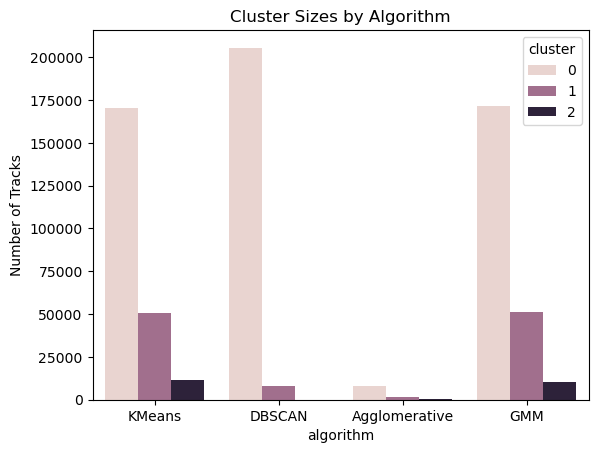

In [40]:
sns.barplot(data=thedf, x="algorithm", y="cluster_count", hue="cluster")
plt.title("Cluster Sizes by Algorithm")
plt.ylabel("Number of Tracks")
plt.show()

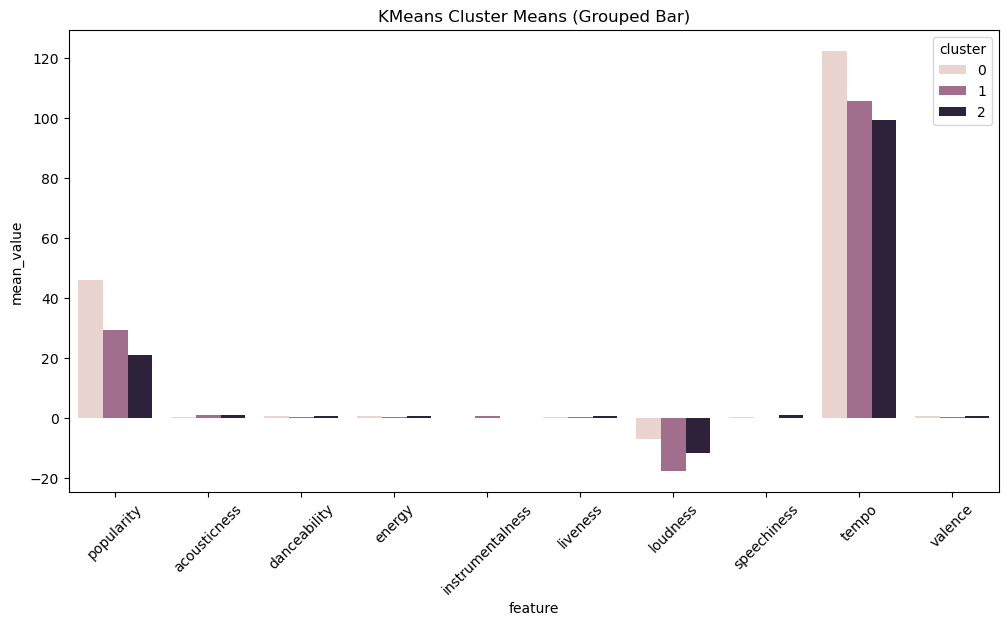

In [41]:
features = ["popularity","acousticness","danceability","energy",
            "instrumentalness","liveness","loudness","speechiness","tempo","valence"]

df_kmeans = thedf[thedf["algorithm"]=="KMeans"].melt(
    id_vars=["cluster"], value_vars=features,
    var_name="feature", value_name="mean_value"
)

plt.figure(figsize=(12,6))
sns.barplot(data=df_kmeans, x="feature", y="mean_value", hue="cluster")
plt.xticks(rotation=45)
plt.title("KMeans Cluster Means (Grouped Bar)")
plt.show()


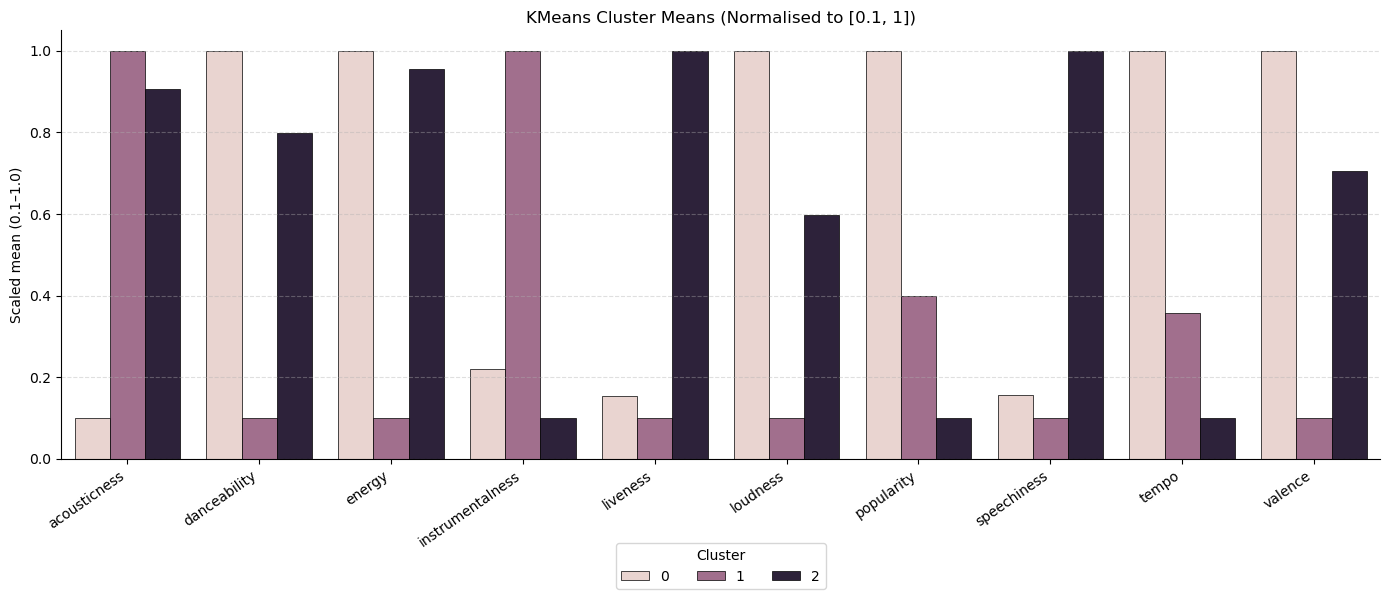

In [42]:
features = ["popularity","acousticness","danceability","energy",
            "instrumentalness","liveness","loudness","speechiness","tempo","valence"]

# Filter KMeans
df_kmeans = thedf[thedf["algorithm"]=="KMeans"].copy()

# Min–max to [0.1, 1]
a, b = 0.1, 1.0
mins = df_kmeans[features].min()
maxs = df_kmeans[features].max()
den = (maxs - mins).replace(0, 1e-9)
df_kmeans[features] = a + (df_kmeans[features] - mins) / den * (b - a)

# Long form for plotting
melted = df_kmeans.melt(id_vars=["cluster"], value_vars=features,
                        var_name="feature", value_name="scaled_value")

# (optional) order features by the cluster that wins each feature
order = (melted.sort_values(["feature","scaled_value"])
               .groupby("feature").tail(1)
               .sort_values("scaled_value", ascending=False)["feature"].tolist())

plt.figure(figsize=(14,6))
ax = sns.barplot(
    data=melted, x="feature", y="scaled_value", hue="cluster",
    order=order, hue_order=sorted(df_kmeans["cluster"].unique()),
    errorbar=None, edgecolor="black", linewidth=0.5
)

ax.set_title("KMeans Cluster Means (Normalised to [0.1, 1])")
ax.set_xlabel("")
ax.set_ylabel("Scaled mean (0.1–1.0)")
ax.set_ylim(0, 1.05)
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=35, ha="right")

# Legend below
leg = plt.legend(title="Cluster", loc="upper center",
                 bbox_to_anchor=(0.5, -0.18), ncol=3)

# Give extra bottom margin so legend doesn't overlap
plt.subplots_adjust(bottom=0.25)
sns.despine()

plt.tight_layout()
plt.show()


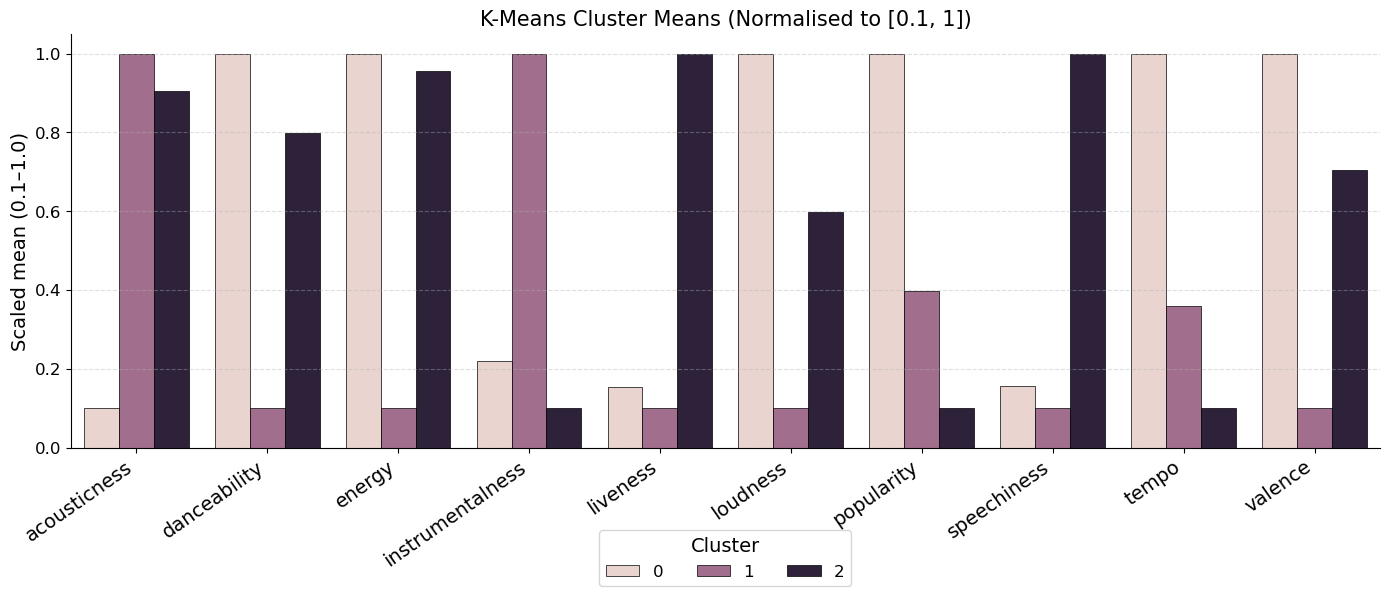

In [53]:
plt.figure(figsize=(14,6))

ax = sns.barplot(
    data=melted, x="feature", y="scaled_value", hue="cluster",
    order=order, hue_order=sorted(df_kmeans["cluster"].unique()),
    errorbar=None, edgecolor="black", linewidth=0.5
)

# Bigger title and labels
ax.set_title("K-Means Cluster Means (Normalised to [0.1, 1])", fontsize=15)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("Scaled mean (0.1–1.0)", fontsize=14)

# Bigger ticks
ax.set_ylim(0, 1.05)
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=35, ha="right", fontsize=14)
plt.yticks(fontsize=12)

# Legend with bigger font
leg = plt.legend(
    title="Cluster", loc="upper center",
    bbox_to_anchor=(0.5, -0.18), ncol=3,
    fontsize=12, title_fontsize=14
)

# Extra bottom margin so legend doesn't overlap
plt.subplots_adjust(bottom=0.25)
sns.despine()

plt.tight_layout()
plt.show()


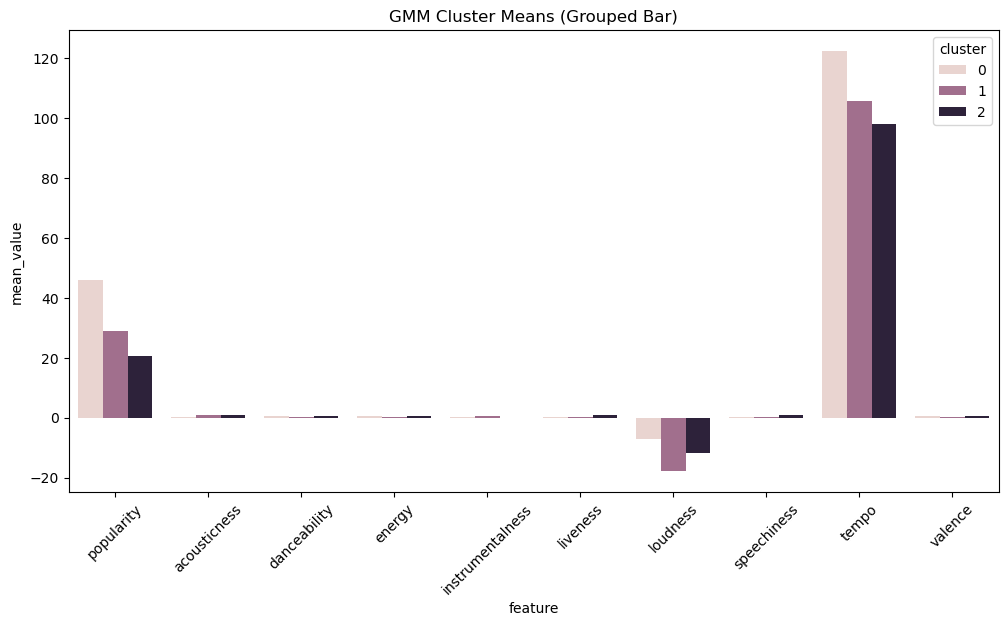

In [91]:
features = ["popularity","acousticness","danceability","energy",
            "instrumentalness","liveness","loudness","speechiness","tempo","valence"]

df_gmm = thedf[thedf["algorithm"]=="GMM"].melt(
    id_vars=["cluster"], value_vars=features,
    var_name="feature", value_name="mean_value"
)

plt.figure(figsize=(12,6))
sns.barplot(data=df_kmeans, x="feature", y="mean_value", hue="cluster")
plt.xticks(rotation=45)
plt.title("GMM Cluster Means (Grouped Bar)")
plt.show()


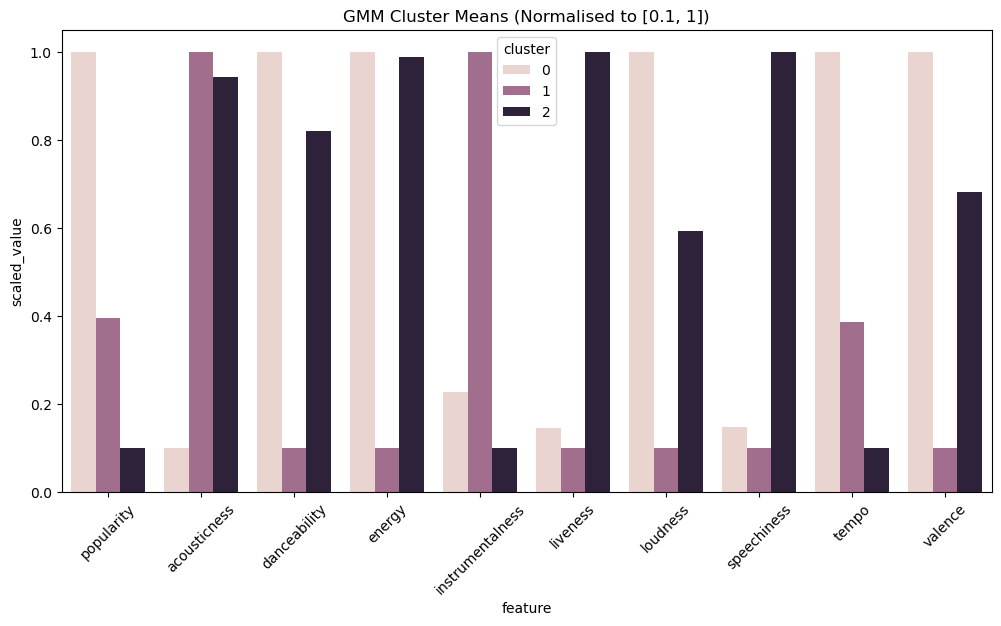

In [92]:
features = ["popularity","acousticness","danceability","energy",
            "instrumentalness","liveness","loudness","speechiness","tempo","valence"]

# Filter KMeans
df_gmm = thedf[thedf["algorithm"]=="GMM"].copy()

# Min-max scale each feature to [0.1, 1]
a, b = 0.1, 1.0
mins = df_kmeans[features].min()
maxs = df_kmeans[features].max()
df_kmeans[features] = a + (df_kmeans[features] - mins) / (maxs - mins) * (b - a)

# Melt for plotting
df_kmeans_melt = df_kmeans.melt(
    id_vars=["cluster"], value_vars=features,
    var_name="feature", value_name="scaled_value"
)

plt.figure(figsize=(12,6))
sns.barplot(data=df_kmeans_melt, x="feature", y="scaled_value", hue="cluster")
plt.xticks(rotation=45)
plt.title("GMM Cluster Means (Normalised to [0.1, 1])")
plt.ylim(0, 1.05)
plt.show()
